In [ ]:
!unzip /content/drive/MyDrive/SMAI_Data/RightVideo.zip -d /content

Archive:  /content/drive/MyDrive/SMAI_Data/RightVideo.zip
   creating: /content/RightVideo/
  inflating: /content/RightVideo/13.mp4  
  inflating: /content/RightVideo/10.mp4  
  inflating: /content/RightVideo/18.mp4  
  inflating: /content/RightVideo/1.mp4  
  inflating: /content/RightVideo/11.mp4  
  inflating: /content/RightVideo/2.mp4  
  inflating: /content/RightVideo/3.mp4  
  inflating: /content/RightVideo/4.mp4  
  inflating: /content/RightVideo/5.mp4  
  inflating: /content/RightVideo/6.mp4  
  inflating: /content/RightVideo/7.mp4  
  inflating: /content/RightVideo/8.mp4  
  inflating: /content/RightVideo/19.mp4  
  inflating: /content/RightVideo/9.mp4  
  inflating: /content/RightVideo/12.mp4  
  inflating: /content/RightVideo/14.mp4  
  inflating: /content/RightVideo/15.mp4  
  inflating: /content/RightVideo/16.mp4  
  inflating: /content/RightVideo/17.mp4  
  inflating: /content/RightVideo/0.mp4  
  inflating: /content/RightVideo/videolist.txt  


In [ ]:
import cv2
import torch
import json
import os
import time
import numpy as np
from tqdm import tqdm
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

# Configuration
INPUT_JSON = "/content/drive/MyDrive/SMAI_Data/selected_frames.json"
VIDEOS_DIR = "/content/RightVideo"
OUTPUT_JSON = "/content/drive/MyDrive/SMAI_Data/detected_regions.json"
MAX_FRAMES_PER_VIDEO = 1000
PROMPTS = ["table tennis table top surface plane", "Legs of the table tennis table", "Human", "Table tennis bat"]
MODEL_ID = "IDEA-Research/grounding-dino-tiny"
BOX_THRESHOLD = 0.25
TEXT_THRESHOLD = 0.30

def load_model():
    """Load the Grounding DINO model"""
    print("Loading Grounding DINO model...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AutoProcessor.from_pretrained(MODEL_ID)
    model = AutoModelForZeroShotObjectDetection.from_pretrained(MODEL_ID).to(device)
    print(f"Model loaded on {device}")
    return model, processor, device

def process_frame(frame_rgb, model, processor, device):
    """Process a single frame with Grounding DINO"""
    try:
        # Convert frame to PIL image
        image = Image.fromarray(frame_rgb)

        # Format text prompts
        text_labels = [[prompt.strip() for prompt in PROMPTS]]

        # Run inference
        inputs = processor(images=image, text=text_labels, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        # Post-process results
        results = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD,
            target_sizes=[image.size[::-1]]  # [H, W] format
        )
        result = results[0]

        # Format detections
        detections = []
        for box, score, label in zip(result["boxes"], result["scores"], result["labels"]):
            box_coords = [float(round(x.item(), 2)) for x in box]
            score_val = float(round(score.item(), 3))
            detections.append({
                "label": label,
                "box": box_coords,
                "score": score_val
            })

        return detections
    except Exception as e:
        print(f"Error processing frame: {e}")
        return None

def process_video(video_name, video_data, model, processor, device, results_dict):
    """Process a single video and its positive frames"""
    # Get positive frames
    positive_frames = video_data.get("positive_frames", [])
    if not positive_frames:
        print(f"No positive frames found for {video_name}, skipping...")
        return False

    # Limit to MAX_FRAMES_PER_VIDEO
    if len(positive_frames) > MAX_FRAMES_PER_VIDEO:
        # Take evenly spaced frames if we need to limit
        step = len(positive_frames) / MAX_FRAMES_PER_VIDEO
        selected_indices = [int(i * step) for i in range(MAX_FRAMES_PER_VIDEO)]
        positive_frames = [positive_frames[i] for i in selected_indices if i < len(positive_frames)]
        print(f"Limited to {len(positive_frames)} evenly distributed frames")

    # Open the video
    video_path = os.path.join(VIDEOS_DIR, video_name)
    if not os.path.exists(video_path):
        print(f"Video file not found: {video_path}")
        return False

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Could not open video: {video_path}")
        return False

    # Initialize result dictionary for this video
    results_dict[video_name] = {}

    # Process each positive frame using fixed tqdm
    # Use position=0 and leave=False to avoid creating new lines
    with tqdm(total=len(positive_frames), desc=f"Video {video_name}",
              unit="frame", position=0, leave=True, ncols=100) as pbar:
        for frame_idx in positive_frames:
            try:
                # Set the frame position
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()

                if not ret:
                    results_dict[video_name][f"frame_{frame_idx}"] = None
                    pbar.update(1)
                    continue

                # Convert frame from BGR to RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Process frame
                detections = process_frame(frame_rgb, model, processor, device)

                # Store results
                if detections is not None and len(detections) > 0:
                    results_dict[video_name][f"frame_{frame_idx}"] = detections
                else:
                    results_dict[video_name][f"frame_{frame_idx}"] = None
            except Exception as e:
                print(f"\nError processing frame {frame_idx}: {e}")
                results_dict[video_name][f"frame_{frame_idx}"] = None

            pbar.update(1)

    # Release video
    cap.release()
    return True

def process_videos_in_batches(selected_frames_data, model, processor, device, batch_size=3):
    """Process videos in batches to better manage resources"""
    results = {}

    # Get list of videos
    video_names = list(selected_frames_data.keys())

    # Process in batches
    for i in range(0, len(video_names), batch_size):
        batch_videos = video_names[i:i+batch_size]
        print(f"\nProcessing batch {i//batch_size + 1}/{(len(video_names)-1)//batch_size + 1}: {batch_videos}")

        for video_name in batch_videos:
            print(f"\nProcessing video: {video_name}")
            video_data = selected_frames_data[video_name]
            process_video(video_name, video_data, model, processor, device, results)

            # Save intermediate results after each video
            with open(OUTPUT_JSON, 'w') as f:
                json.dump(results, f, indent=2)

        # Clear CUDA cache between batches
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return results

def main():
    # Load the selected frames JSON
    print(f"Loading selected frames from {INPUT_JSON}")
    try:
        with open(INPUT_JSON, 'r') as f:
            selected_frames_data = json.load(f)
    except Exception as e:
        print(f"Failed to load input JSON: {e}")
        return

    print(f"Found {len(selected_frames_data)} videos in the selected frames data")

    # Load model
    model, processor, device = load_model()

    # Process videos with improved batching
    results = process_videos_in_batches(selected_frames_data, model, processor, device)

    # Final save
    with open(OUTPUT_JSON, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"\nAll processing complete. Final results saved to {OUTPUT_JSON}")

    # Print summary
    total_frames = sum(len(video_data) for video_data in results.values())
    print(f"Processed {total_frames} frames from {len(results)} videos")

# Optional: Process specific video(s)
def process_specific_videos(video_list):
    """Process only specific videos from the JSON file"""
    # Load the selected frames JSON
    print(f"Loading selected frames from {INPUT_JSON}")
    try:
        with open(INPUT_JSON, 'r') as f:
            selected_frames_data = json.load(f)
    except Exception as e:
        print(f"Failed to load input JSON: {e}")
        return

    # Filter to just the requested videos
    filtered_data = {video: selected_frames_data[video] for video in video_list if video in selected_frames_data}

    if not filtered_data:
        print("None of the specified videos found in the JSON data!")
        return

    print(f"Processing {len(filtered_data)} specified videos")

    # Load model
    model, processor, device = load_model()

    # Load existing results if they exist
    results = {}
    if os.path.exists(OUTPUT_JSON):
        try:
            with open(OUTPUT_JSON, 'r') as f:
                results = json.load(f)
            print(f"Loaded existing results with {len(results)} videos")
        except:
            print("Could not load existing results, starting fresh")

    # Process the filtered videos
    for video_name, video_data in filtered_data.items():
        print(f"\nProcessing video: {video_name}")
        process_video(video_name, video_data, model, processor, device, results)

        # Save after each video
        with open(OUTPUT_JSON, 'w') as f:
            json.dump(results, f, indent=2)

    print(f"\nProcessing complete for specified videos. Results saved to {OUTPUT_JSON}")

if __name__ == "__main__":
    start_time = time.time()

    # Uncomment and modify this to process specific videos:
    # process_specific_videos(["0.mp4", "1.mp4", "2.mp4"])

    # Or process all videos:
    main()

    elapsed_time = time.time() - start_time
    print(f"Total processing time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

Loading selected frames from /content/drive/MyDrive/SMAI_Data/selected_frames.json
Found 19 videos in the selected frames data
Loading Grounding DINO model...
Model loaded on cuda

Processing batch 1/7: ['14.mp4', '11.mp4', '19.mp4']

Processing video: 14.mp4
Limited to 1000 evenly distributed frames


Video 14.mp4:   0%|                                                     | 0/1000 [00:00<?, ?frame/s]<ipython-input-3-5b335439acb5>:45: FutureWarning: `box_threshold` is deprecated and will be removed in version 4.51.0 for `GroundingDinoProcessor.post_process_grounded_object_detection`. Use `threshold` instead.
  results = processor.post_process_grounded_object_detection(
/usr/local/lib/python3.11/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:95: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)
Video 14.mp4: 100%|██████████████████████████████████████████| 1000/1000 [06:29<00:00,  2.56frame/s]



Processing video: 11.mp4


Video 11.mp4: 100%|████████████████████████████████████████████| 764/764 [05:01<00:00,  2.54frame/s]



Processing video: 19.mp4
Limited to 1000 evenly distributed frames


Video 19.mp4: 100%|██████████████████████████████████████████| 1000/1000 [06:27<00:00,  2.58frame/s]



Processing batch 2/7: ['17.mp4', '5.mp4', '3.mp4']

Processing video: 17.mp4
Limited to 1000 evenly distributed frames


Video 17.mp4: 100%|██████████████████████████████████████████| 1000/1000 [06:26<00:00,  2.59frame/s]



Processing video: 5.mp4
Limited to 1000 evenly distributed frames


Video 5.mp4: 100%|███████████████████████████████████████████| 1000/1000 [06:27<00:00,  2.58frame/s]



Processing video: 3.mp4
Limited to 1000 evenly distributed frames


Video 3.mp4: 100%|███████████████████████████████████████████| 1000/1000 [06:28<00:00,  2.57frame/s]



Processing batch 3/7: ['8.mp4', '18.mp4', '9.mp4']

Processing video: 8.mp4
Limited to 1000 evenly distributed frames


Video 8.mp4: 100%|███████████████████████████████████████████| 1000/1000 [06:29<00:00,  2.57frame/s]



Processing video: 18.mp4
Limited to 1000 evenly distributed frames


Video 18.mp4: 100%|██████████████████████████████████████████| 1000/1000 [06:30<00:00,  2.56frame/s]



Processing video: 9.mp4
Limited to 1000 evenly distributed frames


Video 9.mp4: 100%|███████████████████████████████████████████| 1000/1000 [06:26<00:00,  2.58frame/s]



Processing batch 4/7: ['1.mp4', '6.mp4', '13.mp4']

Processing video: 1.mp4
Limited to 1000 evenly distributed frames


Video 1.mp4: 100%|███████████████████████████████████████████| 1000/1000 [06:29<00:00,  2.57frame/s]



Processing video: 6.mp4
Limited to 1000 evenly distributed frames


Video 6.mp4: 100%|███████████████████████████████████████████| 1000/1000 [06:29<00:00,  2.57frame/s]



Processing video: 13.mp4
Limited to 1000 evenly distributed frames


Video 13.mp4: 100%|██████████████████████████████████████████| 1000/1000 [06:29<00:00,  2.57frame/s]



Processing batch 5/7: ['4.mp4', '10.mp4', '7.mp4']

Processing video: 4.mp4
Limited to 1000 evenly distributed frames


Video 4.mp4: 100%|███████████████████████████████████████████| 1000/1000 [06:30<00:00,  2.56frame/s]



Processing video: 10.mp4
Limited to 1000 evenly distributed frames


Video 10.mp4: 100%|██████████████████████████████████████████| 1000/1000 [06:29<00:00,  2.56frame/s]



Processing video: 7.mp4
Limited to 1000 evenly distributed frames


Video 7.mp4: 100%|███████████████████████████████████████████| 1000/1000 [06:30<00:00,  2.56frame/s]



Processing batch 6/7: ['16.mp4', '0.mp4', '15.mp4']

Processing video: 16.mp4


Video 16.mp4: 100%|████████████████████████████████████████████| 550/550 [03:36<00:00,  2.54frame/s]



Processing video: 0.mp4
Limited to 1000 evenly distributed frames


Video 0.mp4: 100%|███████████████████████████████████████████| 1000/1000 [06:27<00:00,  2.58frame/s]



Processing video: 15.mp4
Limited to 1000 evenly distributed frames


Video 15.mp4: 100%|██████████████████████████████████████████| 1000/1000 [06:30<00:00,  2.56frame/s]



Processing batch 7/7: ['2.mp4']

Processing video: 2.mp4


Video 2.mp4: 100%|█████████████████████████████████████████████| 367/367 [02:22<00:00,  2.58frame/s]



All processing complete. Final results saved to /content/drive/MyDrive/SMAI_Data/detected_regions.json
Processed 17681 frames from 19 videos
Total processing time: 6906.53 seconds (115.11 minutes)


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
import json
import os
import random
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

# Configuration
DETECTED_REGIONS_JSON = "/content/drive/MyDrive/SMAI_Data/detected_regions.json"
VIDEOS_DIR = "/content/RightVideo"
OUTPUT_DIR = "/content/visualization_output"
FRAMES_PER_VIDEO = 10

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_detections():
    """Load the detected regions from JSON file"""
    print(f"Loading detections from {DETECTED_REGIONS_JSON}")
    with open(DETECTED_REGIONS_JSON, 'r') as f:
        return json.load(f)

def get_random_frames(video_data, num_frames=FRAMES_PER_VIDEO):
    """Select random frames from a video that have detections"""
    # Get all frames that have detections (not None)
    valid_frames = [frame for frame, detections in video_data.items()
                   if detections is not None and len(detections) > 0]

    if not valid_frames:
        print("No frames with valid detections found")
        return []

    # Select random frames
    if len(valid_frames) <= num_frames:
        return valid_frames
    else:
        return random.sample(valid_frames, num_frames)

def get_frame_number(frame_key):
    """Extract frame number from frame key (e.g., 'frame_123' -> 123)"""
    return int(frame_key.split('_')[1])

def get_unique_colors(num_classes):
    """Generate distinct colors for different classes"""
    colors = []
    for i in range(num_classes):
        # Generate colors in HSV space for better distinction
        h = i / float(num_classes)
        s = 0.8
        v = 0.9
        rgb = hsv_to_rgb((h, s, v))
        # Convert from 0-1 range to 0-255 range
        colors.append(tuple(int(255 * c) for c in rgb))
    return colors

def visualize_detections():
    """Main function to visualize detections"""
    # Load detections
    detections_data = load_detections()
    print(f"Found {len(detections_data)} videos in the detections data")

    # Create a mapping from class names to colors
    all_classes = set()
    for video_data in detections_data.values():
        for frame_data in video_data.values():
            if frame_data:  # If not None
                for detection in frame_data:
                    all_classes.add(detection["label"])

    class_list = sorted(list(all_classes))
    colors = get_unique_colors(len(class_list))
    class_to_color = {class_name: colors[i] for i, class_name in enumerate(class_list)}

    # Process each video
    for video_name, video_data in detections_data.items():
        print(f"\nProcessing video: {video_name}")

        # Get random frames with detections
        selected_frames = get_random_frames(video_data)
        if not selected_frames:
            print(f"No frames with detections found in {video_name}, skipping...")
            continue

        print(f"Selected {len(selected_frames)} frames from {video_name}")

        # Open the video
        video_path = os.path.join(VIDEOS_DIR, video_name)
        if not os.path.exists(video_path):
            print(f"Video file not found: {video_path}")
            continue

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Could not open video: {video_path}")
            continue

        # Create a grid for displaying this video's frames
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()

        for i, frame_key in enumerate(selected_frames[:FRAMES_PER_VIDEO]):
            frame_idx = get_frame_number(frame_key)
            detections = video_data[frame_key]

            # Set the frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Could not read frame {frame_idx} from {video_name}")
                continue

            # Convert from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Draw detections
            for detection in detections:
                label = detection["label"]
                box = detection["box"]
                score = detection["score"]

                # Convert box to int coordinates [x1, y1, x2, y2]
                x1, y1, x2, y2 = map(int, box)

                # Get color for this class
                color = class_to_color[label]

                # Draw rectangle
                cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), color, 2)

                # Draw label background
                label_text = f"{label}: {score:.2f}"
                (text_width, text_height), _ = cv2.getTextSize(
                    label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(
                    frame_rgb,
                    (x1, y1 - text_height - 4),
                    (x1 + text_width, y1),
                    color,
                    -1
                )

                # Draw label text
                cv2.putText(
                    frame_rgb,
                    label_text,
                    (x1, y1 - 4),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (255, 255, 255),
                    1
                )

            # Display in the grid
            axes[i].imshow(frame_rgb)
            axes[i].set_title(f"Frame {frame_idx}")
            axes[i].axis('off')

        # Turn off any unused subplots
        for j in range(len(selected_frames), len(axes)):
            axes[j].axis('off')

        # Add a title for the entire figure
        plt.suptitle(f"Detections from {video_name}", fontsize=16)
        plt.tight_layout()

        # Save the figure
        output_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(video_name)[0]}_detections.png")
        plt.savefig(output_path, dpi=150)
        print(f"Saved visualization to {output_path}")

        # Show the plot
        plt.show()

        # Release video
        cap.release()

    print(f"\nVisualization complete. Results saved to {OUTPUT_DIR}")

if __name__ == "__main__":
    visualize_detections()

In [ ]:
# prompt: zip the folder /content/visualization_output

!zip -r /content/visualization_output.zip /content/visualization_output


  adding: content/visualization_output/ (stored 0%)
  adding: content/visualization_output/7_detections.png (deflated 1%)
  adding: content/visualization_output/8_detections.png (deflated 1%)
  adding: content/visualization_output/16_detections.png (deflated 1%)
  adding: content/visualization_output/10_detections.png (deflated 1%)
  adding: content/visualization_output/14_detections.png (deflated 1%)
  adding: content/visualization_output/18_detections.png (deflated 1%)
  adding: content/visualization_output/4_detections.png (deflated 1%)
  adding: content/visualization_output/6_detections.png (deflated 1%)
  adding: content/visualization_output/17_detections.png (deflated 1%)
  adding: content/visualization_output/0_detections.png (deflated 1%)
  adding: content/visualization_output/13_detections.png (deflated 1%)
  adding: content/visualization_output/9_detections.png (deflated 1%)
  adding: content/visualization_output/11_detections.png (deflated 1%)
  adding: content/visualization

In [ ]:
import json
import os
import random
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

# Configuration
DETECTED_REGIONS_JSON = "/content/drive/MyDrive/SMAI_Data/detected_regions.json"
VIDEOS_DIR = "/content/RightVideo"
OUTPUT_DIR = "/content/table_visualization_output"
FRAMES_PER_VIDEO = 10

# Target keywords to filter detections
TARGET_KEYWORDS = ["table", "top", "surface"]

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_detections():
    """Load the detected regions from JSON file"""
    print(f"Loading detections from {DETECTED_REGIONS_JSON}")
    with open(DETECTED_REGIONS_JSON, 'r') as f:
        return json.load(f)

def contains_target_keywords(label):
    """Check if detection label contains any of the target keywords"""
    label_lower = label.lower()
    for keyword in TARGET_KEYWORDS:
        if keyword.lower() in label_lower:
            return True
    return False

def filter_detections(detections):
    """Filter detections to only include those with target keywords"""
    if detections is None:
        return None

    filtered = [d for d in detections if contains_target_keywords(d["label"])]
    return filtered if filtered else None

def get_random_frames_with_table_detections(video_data, num_frames=FRAMES_PER_VIDEO):
    """Select random frames from a video that have table-related detections"""
    # Get all frames that have table-related detections
    valid_frames = []

    for frame, detections in video_data.items():
        if detections is not None:
            # Check if any detection contains target keywords
            filtered_detections = filter_detections(detections)
            if filtered_detections:
                valid_frames.append(frame)

    if not valid_frames:
        print("No frames with table-related detections found")
        return []

    # Select random frames
    if len(valid_frames) <= num_frames:
        return valid_frames
    else:
        return random.sample(valid_frames, num_frames)

def get_frame_number(frame_key):
    """Extract frame number from frame key (e.g., 'frame_123' -> 123)"""
    return int(frame_key.split('_')[1])

def get_unique_colors(num_classes):
    """Generate distinct colors for different classes"""
    colors = []
    for i in range(num_classes):
        # Generate colors in HSV space for better distinction
        h = i / float(num_classes)
        s = 0.8
        v = 0.9
        rgb = hsv_to_rgb((h, s, v))
        # Convert from 0-1 range to 0-255 range
        colors.append(tuple(int(255 * c) for c in rgb))
    return colors

def visualize_table_detections():
    """Main function to visualize table-related detections"""
    # Load detections
    detections_data = load_detections()
    print(f"Found {len(detections_data)} videos in the detections data")

    # Create a mapping from class names to colors
    all_classes = set()
    for video_data in detections_data.values():
        for frame_data in video_data.values():
            if frame_data:  # If not None
                filtered_detections = filter_detections(frame_data)
                if filtered_detections:
                    for detection in filtered_detections:
                        all_classes.add(detection["label"])

    class_list = sorted(list(all_classes))
    print(f"Found {len(class_list)} table-related classes: {', '.join(class_list)}")
    colors = get_unique_colors(len(class_list))
    class_to_color = {class_name: colors[i] for i, class_name in enumerate(class_list)}

    # Process each video
    for video_name, video_data in detections_data.items():
        print(f"\nProcessing video: {video_name}")

        # Get random frames with table-related detections
        selected_frames = get_random_frames_with_table_detections(video_data)
        if not selected_frames:
            print(f"No frames with table-related detections found in {video_name}, skipping...")
            continue

        print(f"Selected {len(selected_frames)} frames from {video_name}")

        # Open the video
        video_path = os.path.join(VIDEOS_DIR, video_name)
        if not os.path.exists(video_path):
            print(f"Video file not found: {video_path}")
            continue

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Could not open video: {video_path}")
            continue

        # Create a grid for displaying this video's frames
        num_frames_to_display = min(FRAMES_PER_VIDEO, len(selected_frames))
        rows = (num_frames_to_display + 4) // 5  # Calculate rows needed (ceil division)
        cols = min(5, num_frames_to_display)

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
        # Handle case where only one frame is displayed
        if num_frames_to_display == 1:
            axes = np.array([axes])
        axes = axes.flatten()

        for i, frame_key in enumerate(selected_frames[:num_frames_to_display]):
            frame_idx = get_frame_number(frame_key)
            all_detections = video_data[frame_key]

            # Filter detections to only include table-related ones
            detections = filter_detections(all_detections)

            # Set the frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Could not read frame {frame_idx} from {video_name}")
                continue

            # Convert from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Draw filtered detections
            for detection in detections:
                label = detection["label"]
                box = detection["box"]
                score = detection["score"]

                # Convert box to int coordinates [x1, y1, x2, y2]
                x1, y1, x2, y2 = map(int, box)

                # Get color for this class
                color = class_to_color[label]

                # Draw rectangle
                cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), color, 2)

                # Draw label background
                label_text = f"{label}: {score:.2f}"
                (text_width, text_height), _ = cv2.getTextSize(
                    label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(
                    frame_rgb,
                    (x1, y1 - text_height - 4),
                    (x1 + text_width, y1),
                    color,
                    -1
                )

                # Draw label text
                cv2.putText(
                    frame_rgb,
                    label_text,
                    (x1, y1 - 4),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (255, 255, 255),
                    1
                )

            # Display in the grid
            axes[i].imshow(frame_rgb)
            axes[i].set_title(f"Frame {frame_idx}")
            axes[i].axis('off')

        # Turn off any unused subplots
        for j in range(num_frames_to_display, len(axes)):
            axes[j].axis('off')

        # Add a title for the entire figure
        plt.suptitle(f"Table-related Detections from {video_name}", fontsize=16)
        plt.tight_layout()

        # Save the figure
        output_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(video_name)[0]}_table_detections.png")
        plt.savefig(output_path, dpi=150)
        print(f"Saved visualization to {output_path}")

        # Show the plot
        plt.show()

        # Release video
        cap.release()

    print(f"\nVisualization complete. Results saved to {OUTPUT_DIR}")

if __name__ == "__main__":
    visualize_table_detections()

In [ ]:
# prompt: /content/table_visualization_output compress to zip

!zip -r /content/table_visualization_output.zip /content/table_visualization_output


  adding: content/table_visualization_output/ (stored 0%)
  adding: content/table_visualization_output/10_table_detections.png (deflated 1%)
  adding: content/table_visualization_output/15_table_detections.png (deflated 1%)
  adding: content/table_visualization_output/13_table_detections.png (deflated 1%)
  adding: content/table_visualization_output/0_table_detections.png (deflated 1%)
  adding: content/table_visualization_output/14_table_detections.png (deflated 1%)
  adding: content/table_visualization_output/4_table_detections.png (deflated 1%)
  adding: content/table_visualization_output/11_table_detections.png (deflated 1%)
  adding: content/table_visualization_output/6_table_detections.png (deflated 1%)
  adding: content/table_visualization_output/18_table_detections.png (deflated 1%)
  adding: content/table_visualization_output/9_table_detections.png (deflated 1%)
  adding: content/table_visualization_output/5_table_detections.png (deflated 1%)
  adding: content/table_visualizat

In [ ]:
import json
import os
import random
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

# Configuration
DETECTED_REGIONS_JSON = "/content/drive/MyDrive/SMAI_Data/detected_regions.json"
VIDEOS_DIR = "/content/RightVideo"
OUTPUT_DIR = "/content/filtered_table_visualization_output"
FRAMES_PER_VIDEO = 10

# Target keywords to filter detections
TARGET_KEYWORDS = ["table", "top", "surface"]
# Keywords to exclude
EXCLUDE_KEYWORDS = ["bat"]

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_detections():
    """Load the detected regions from JSON file"""
    print(f"Loading detections from {DETECTED_REGIONS_JSON}")
    with open(DETECTED_REGIONS_JSON, 'r') as f:
        return json.load(f)

def should_include_detection(label):
    """Check if detection label should be included based on keywords"""
    label_lower = label.lower()

    # First check exclusion - if any exclude keyword is found, return False
    for exclude_word in EXCLUDE_KEYWORDS:
        if exclude_word.lower() in label_lower:
            return False

    # Then check inclusion - if any target keyword is found, return True
    for keyword in TARGET_KEYWORDS:
        if keyword.lower() in label_lower:
            return True

    # If no target keywords found, return False
    return False

def filter_detections(detections):
    """Filter detections to only include those with target keywords and exclude unwanted ones"""
    if detections is None:
        return None

    filtered = [d for d in detections if should_include_detection(d["label"])]
    return filtered if filtered else None

def get_random_frames_with_table_detections(video_data, num_frames=FRAMES_PER_VIDEO):
    """Select random frames from a video that have table-related detections"""
    # Get all frames that have table-related detections
    valid_frames = []

    for frame, detections in video_data.items():
        if detections is not None:
            # Check if any detection contains target keywords
            filtered_detections = filter_detections(detections)
            if filtered_detections:
                valid_frames.append(frame)

    if not valid_frames:
        print("No frames with filtered table-related detections found")
        return []

    # Select random frames
    if len(valid_frames) <= num_frames:
        return valid_frames
    else:
        return random.sample(valid_frames, num_frames)

def get_frame_number(frame_key):
    """Extract frame number from frame key (e.g., 'frame_123' -> 123)"""
    return int(frame_key.split('_')[1])

def get_unique_colors(num_classes):
    """Generate distinct colors for different classes"""
    colors = []
    for i in range(num_classes):
        # Generate colors in HSV space for better distinction
        h = i / float(num_classes)
        s = 0.8
        v = 0.9
        rgb = hsv_to_rgb((h, s, v))
        # Convert from 0-1 range to 0-255 range
        colors.append(tuple(int(255 * c) for c in rgb))
    return colors

def visualize_filtered_detections():
    """Main function to visualize filtered table-related detections"""
    # Load detections
    detections_data = load_detections()
    print(f"Found {len(detections_data)} videos in the detections data")

    # Create a mapping from class names to colors
    all_classes = set()
    for video_data in detections_data.values():
        for frame_data in video_data.values():
            if frame_data:  # If not None
                filtered_detections = filter_detections(frame_data)
                if filtered_detections:
                    for detection in filtered_detections:
                        all_classes.add(detection["label"])

    class_list = sorted(list(all_classes))
    print(f"Found {len(class_list)} filtered table-related classes: {', '.join(class_list)}")
    colors = get_unique_colors(len(class_list))
    class_to_color = {class_name: colors[i] for i, class_name in enumerate(class_list)}

    # Process each video
    for video_name, video_data in detections_data.items():
        print(f"\nProcessing video: {video_name}")

        # Get random frames with filtered table-related detections
        selected_frames = get_random_frames_with_table_detections(video_data)
        if not selected_frames:
            print(f"No frames with filtered table-related detections found in {video_name}, skipping...")
            continue

        print(f"Selected {len(selected_frames)} frames from {video_name}")

        # Open the video
        video_path = os.path.join(VIDEOS_DIR, video_name)
        if not os.path.exists(video_path):
            print(f"Video file not found: {video_path}")
            continue

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Could not open video: {video_path}")
            continue

        # Create a grid for displaying this video's frames
        num_frames_to_display = min(FRAMES_PER_VIDEO, len(selected_frames))
        rows = (num_frames_to_display + 4) // 5  # Calculate rows needed (ceil division)
        cols = min(5, num_frames_to_display)

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
        # Handle case where only one frame is displayed
        if num_frames_to_display == 1:
            axes = np.array([axes])
        axes = axes.flatten()

        for i, frame_key in enumerate(selected_frames[:num_frames_to_display]):
            frame_idx = get_frame_number(frame_key)
            all_detections = video_data[frame_key]

            # Filter detections to only include table-related ones and exclude bat-related ones
            detections = filter_detections(all_detections)

            # Set the frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Could not read frame {frame_idx} from {video_name}")
                continue

            # Convert from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Draw filtered detections
            for detection in detections:
                label = detection["label"]
                box = detection["box"]
                score = detection["score"]

                # Convert box to int coordinates [x1, y1, x2, y2]
                x1, y1, x2, y2 = map(int, box)

                # Get color for this class
                color = class_to_color[label]

                # Draw rectangle
                cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), color, 2)

                # Draw label background
                label_text = f"{label}: {score:.2f}"
                (text_width, text_height), _ = cv2.getTextSize(
                    label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(
                    frame_rgb,
                    (x1, y1 - text_height - 4),
                    (x1 + text_width, y1),
                    color,
                    -1
                )

                # Draw label text
                cv2.putText(
                    frame_rgb,
                    label_text,
                    (x1, y1 - 4),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (255, 255, 255),
                    1
                )

            # Display in the grid
            axes[i].imshow(frame_rgb)
            axes[i].set_title(f"Frame {frame_idx}")
            axes[i].axis('off')

        # Turn off any unused subplots
        for j in range(num_frames_to_display, len(axes)):
            axes[j].axis('off')

        # Add a title for the entire figure
        plt.suptitle(f"Filtered Table Detections from {video_name} (No Bat)", fontsize=16)
        plt.tight_layout()

        # Save the figure
        output_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(video_name)[0]}_filtered_detections.png")
        plt.savefig(output_path, dpi=150)
        print(f"Saved visualization to {output_path}")

        # Show the plot
        plt.show()

        # Release video
        cap.release()

    print(f"\nVisualization complete. Results saved to {OUTPUT_DIR}")

if __name__ == "__main__":
    visualize_filtered_detections()

In [ ]:
# prompt:  /content/filtered_table_visualization_output compress this folder

!zip -r /content/filtered_table_visualization_output.zip /content/filtered_table_visualization_output


  adding: content/filtered_table_visualization_output/ (stored 0%)
  adding: content/filtered_table_visualization_output/7_filtered_detections.png (deflated 1%)
  adding: content/filtered_table_visualization_output/8_filtered_detections.png (deflated 1%)
  adding: content/filtered_table_visualization_output/1_filtered_detections.png (deflated 1%)
  adding: content/filtered_table_visualization_output/3_filtered_detections.png (deflated 1%)
  adding: content/filtered_table_visualization_output/9_filtered_detections.png (deflated 1%)
  adding: content/filtered_table_visualization_output/6_filtered_detections.png (deflated 1%)
  adding: content/filtered_table_visualization_output/16_filtered_detections.png (deflated 1%)
  adding: content/filtered_table_visualization_output/14_filtered_detections.png (deflated 1%)
  adding: content/filtered_table_visualization_output/18_filtered_detections.png (deflated 1%)
  adding: content/filtered_table_visualization_output/15_filtered_detections.png (de

In [ ]:
import json
import os
import random
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

# Configuration
DETECTED_REGIONS_JSON = "/content/drive/MyDrive/SMAI_Data/detected_regions.json"
VIDEOS_DIR = "/content/RightVideo"
OUTPUT_DIR = "/content/filtered_table_visualization_output"
FRAMES_PER_VIDEO = 10

# Target keywords to filter detections
TARGET_KEYWORDS = ["table", "top", "surface"]
# Keywords to exclude
EXCLUDE_KEYWORDS = ["bat"]
# Size threshold: boxes smaller than this percentage of the largest box will be excluded
SIZE_THRESHOLD = 0.15  # 15%

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_detections():
    """Load the detected regions from JSON file"""
    print(f"Loading detections from {DETECTED_REGIONS_JSON}")
    with open(DETECTED_REGIONS_JSON, 'r') as f:
        return json.load(f)

def should_include_detection(label):
    """Check if detection label should be included based on keywords"""
    label_lower = label.lower()

    # First check exclusion - if any exclude keyword is found, return False
    for exclude_word in EXCLUDE_KEYWORDS:
        if exclude_word.lower() in label_lower:
            return False

    # Then check inclusion - if any target keyword is found, return True
    for keyword in TARGET_KEYWORDS:
        if keyword.lower() in label_lower:
            return True

    # If no target keywords found, return False
    return False

def calculate_box_area(box):
    """Calculate the area of a bounding box [x1, y1, x2, y2]"""
    width = box[2] - box[0]
    height = box[3] - box[1]
    return width * height

def filter_detections_by_keywords_and_size(detections):
    """Filter detections based on keywords and size threshold"""
    if detections is None:
        return None

    # First filter by keywords
    keyword_filtered = [d for d in detections if should_include_detection(d["label"])]
    if not keyword_filtered:
        return None

    # Find the largest box
    largest_area = 0
    for detection in keyword_filtered:
        area = calculate_box_area(detection["box"])
        if area > largest_area:
            largest_area = area

    # Calculate the area threshold
    area_threshold = largest_area * SIZE_THRESHOLD

    # Filter out small boxes
    size_filtered = []
    for detection in keyword_filtered:
        area = calculate_box_area(detection["box"])
        if area >= area_threshold:
            size_filtered.append(detection)

    return size_filtered if size_filtered else None

def get_random_frames_with_filtered_detections(video_data, num_frames=FRAMES_PER_VIDEO):
    """Select random frames from a video that have filtered detections"""
    valid_frames = []

    for frame, detections in video_data.items():
        if detections is not None:
            # Check if any detection passes all filters
            filtered_detections = filter_detections_by_keywords_and_size(detections)
            if filtered_detections:
                valid_frames.append(frame)

    if not valid_frames:
        print("No frames with valid filtered detections found")
        return []

    # Select random frames
    if len(valid_frames) <= num_frames:
        return valid_frames
    else:
        return random.sample(valid_frames, num_frames)

def get_frame_number(frame_key):
    """Extract frame number from frame key (e.g., 'frame_123' -> 123)"""
    return int(frame_key.split('_')[1])

def get_unique_colors(num_classes):
    """Generate distinct colors for different classes"""
    colors = []
    for i in range(num_classes):
        # Generate colors in HSV space for better distinction
        h = i / float(num_classes)
        s = 0.8
        v = 0.9
        rgb = hsv_to_rgb((h, s, v))
        # Convert from 0-1 range to 0-255 range
        colors.append(tuple(int(255 * c) for c in rgb))
    return colors

def visualize_enhanced_filtered_detections():
    """Main function to visualize filtered detections with size threshold"""
    # Load detections
    detections_data = load_detections()
    print(f"Found {len(detections_data)} videos in the detections data")

    # Create a mapping from class names to colors
    all_classes = set()
    for video_data in detections_data.values():
        for frame_data in video_data.values():
            if frame_data:  # If not None
                filtered_detections = filter_detections_by_keywords_and_size(frame_data)
                if filtered_detections:
                    for detection in filtered_detections:
                        all_classes.add(detection["label"])

    class_list = sorted(list(all_classes))
    print(f"Found {len(class_list)} filtered classes: {', '.join(class_list)}")
    colors = get_unique_colors(len(class_list))
    class_to_color = {class_name: colors[i] for i, class_name in enumerate(class_list)}

    # Process each video
    for video_name, video_data in detections_data.items():
        print(f"\nProcessing video: {video_name}")

        # Get random frames with filtered detections
        selected_frames = get_random_frames_with_filtered_detections(video_data)
        if not selected_frames:
            print(f"No frames with filtered detections found in {video_name}, skipping...")
            continue

        print(f"Selected {len(selected_frames)} frames from {video_name}")

        # Open the video
        video_path = os.path.join(VIDEOS_DIR, video_name)
        if not os.path.exists(video_path):
            print(f"Video file not found: {video_path}")
            continue

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Could not open video: {video_path}")
            continue

        # Create a grid for displaying this video's frames
        num_frames_to_display = min(FRAMES_PER_VIDEO, len(selected_frames))
        rows = (num_frames_to_display + 4) // 5  # Calculate rows needed (ceil division)
        cols = min(5, num_frames_to_display)

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
        # Handle case where only one frame is displayed
        if num_frames_to_display == 1:
            axes = np.array([axes])
        axes = axes.flatten()

        for i, frame_key in enumerate(selected_frames[:num_frames_to_display]):
            frame_idx = get_frame_number(frame_key)
            all_detections = video_data[frame_key]

            # Apply all filters
            detections = filter_detections_by_keywords_and_size(all_detections)

            # Set the frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Could not read frame {frame_idx} from {video_name}")
                continue

            # Convert from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Draw filtered detections
            for detection in detections:
                label = detection["label"]
                box = detection["box"]
                score = detection["score"]

                # Convert box to int coordinates [x1, y1, x2, y2]
                x1, y1, x2, y2 = map(int, box)

                # Get color for this class
                color = class_to_color[label]

                # Draw rectangle
                cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), color, 2)

                # Draw label background
                label_text = f"{label}: {score:.2f}"
                (text_width, text_height), _ = cv2.getTextSize(
                    label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(
                    frame_rgb,
                    (x1, y1 - text_height - 4),
                    (x1 + text_width, y1),
                    color,
                    -1
                )

                # Draw label text
                cv2.putText(
                    frame_rgb,
                    label_text,
                    (x1, y1 - 4),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (255, 255, 255),
                    1
                )

                # Add box area text
                area = calculate_box_area(box)
                area_text = f"Area: {area:.0f}px²"
                cv2.putText(
                    frame_rgb,
                    area_text,
                    (x1, y2 + 15),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.4,
                    color,
                    1
                )

            # Display in the grid
            axes[i].imshow(frame_rgb)
            axes[i].set_title(f"Frame {frame_idx}")
            axes[i].axis('off')

        # Turn off any unused subplots
        for j in range(num_frames_to_display, len(axes)):
            axes[j].axis('off')

        # Add a title for the entire figure
        plt.suptitle(f"Enhanced Filtered Detections - {video_name}\n(No bat, Min size: {SIZE_THRESHOLD*100}% of largest box)", fontsize=14)
        plt.tight_layout()

        # Save the figure
        output_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(video_name)[0]}_enhanced_filtered.png")
        plt.savefig(output_path, dpi=150)
        print(f"Saved visualization to {output_path}")

        # Show the plot
        plt.show()

        # Release video
        cap.release()

    print(f"\nVisualization complete. Results saved to {OUTPUT_DIR}")

if __name__ == "__main__":
    visualize_enhanced_filtered_detections()

In [ ]:
import json
import os
import random
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

# Configuration
DETECTED_REGIONS_JSON = "/content/drive/MyDrive/SMAI_Data/detected_regions.json"
VIDEOS_DIR = "/content/RightVideo"
OUTPUT_DIR = "/content/smaller_box_visualization_output"
FRAMES_PER_VIDEO = 10

# Target keywords to filter detections
TARGET_KEYWORDS = ["table", "top", "surface"]
# Keywords to exclude
EXCLUDE_KEYWORDS = ["bat"]
# Size threshold: boxes smaller than this percentage of the largest box will be excluded
SIZE_THRESHOLD = 0.15  # 15%

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_detections():
    """Load the detected regions from JSON file"""
    print(f"Loading detections from {DETECTED_REGIONS_JSON}")
    with open(DETECTED_REGIONS_JSON, 'r') as f:
        return json.load(f)

def should_include_detection(label):
    """Check if detection label should be included based on keywords"""
    label_lower = label.lower()

    # First check exclusion - if any exclude keyword is found, return False
    for exclude_word in EXCLUDE_KEYWORDS:
        if exclude_word.lower() in label_lower:
            return False

    # Then check inclusion - if any target keyword is found, return True
    for keyword in TARGET_KEYWORDS:
        if keyword.lower() in label_lower:
            return True

    # If no target keywords found, return False
    return False

def calculate_box_area(box):
    """Calculate the area of a bounding box [x1, y1, x2, y2]"""
    width = box[2] - box[0]
    height = box[3] - box[1]
    return width * height

def filter_initial(detections):
    """Apply initial keyword and size filtering"""
    if detections is None:
        return None

    # First filter by keywords
    keyword_filtered = [d for d in detections if should_include_detection(d["label"])]
    if not keyword_filtered:
        return None

    # Find the largest box
    largest_area = 0
    for detection in keyword_filtered:
        area = calculate_box_area(detection["box"])
        if area > largest_area:
            largest_area = area

    # Calculate the area threshold
    area_threshold = largest_area * SIZE_THRESHOLD

    # Filter out small boxes
    size_filtered = []
    for detection in keyword_filtered:
        area = calculate_box_area(detection["box"])
        if area >= area_threshold:
            size_filtered.append(detection)

    return size_filtered if size_filtered else None

def keep_only_smaller_box(detections):
    """From the filtered detections, keep only the smaller box if there are exactly two"""
    if detections is None or len(detections) != 2:
        return None

    # Calculate areas of both boxes
    area1 = calculate_box_area(detections[0]["box"])
    area2 = calculate_box_area(detections[1]["box"])

    # Return only the smaller box
    if area1 <= area2:
        return [detections[0]]
    else:
        return [detections[1]]

def get_random_frames_with_two_boxes(video_data, num_frames=FRAMES_PER_VIDEO):
    """Select random frames that have exactly two boxes after initial filtering"""
    valid_frames = []

    for frame, detections in video_data.items():
        if detections is not None:
            # Apply initial filtering
            filtered_detections = filter_initial(detections)

            # Check if we have exactly two boxes after filtering
            if filtered_detections and len(filtered_detections) == 2:
                valid_frames.append(frame)

    if not valid_frames:
        print("No frames with exactly two filtered detections found")
        return []

    # Select random frames
    if len(valid_frames) <= num_frames:
        return valid_frames
    else:
        return random.sample(valid_frames, num_frames)

def get_frame_number(frame_key):
    """Extract frame number from frame key (e.g., 'frame_123' -> 123)"""
    return int(frame_key.split('_')[1])

def get_unique_colors(num_classes):
    """Generate distinct colors for different classes"""
    colors = []
    for i in range(num_classes):
        # Generate colors in HSV space for better distinction
        h = i / float(num_classes)
        s = 0.8
        v = 0.9
        rgb = hsv_to_rgb((h, s, v))
        # Convert from 0-1 range to 0-255 range
        colors.append(tuple(int(255 * c) for c in rgb))
    return colors

def visualize_smaller_box_detections():
    """Main function to visualize only the smaller of two boxes per frame"""
    # Load detections
    detections_data = load_detections()
    print(f"Found {len(detections_data)} videos in the detections data")

    # Create a mapping from class names to colors
    all_classes = set()
    for video_data in detections_data.values():
        for frame_data in video_data.values():
            if frame_data:  # If not None
                # Apply initial filtering
                filtered_detections = filter_initial(frame_data)
                # Keep only the smaller box if there are exactly two
                if filtered_detections and len(filtered_detections) == 2:
                    smaller_box = keep_only_smaller_box(filtered_detections)
                    if smaller_box:
                        for detection in smaller_box:
                            all_classes.add(detection["label"])

    class_list = sorted(list(all_classes))
    print(f"Found {len(class_list)} classes after filtering: {', '.join(class_list)}")
    colors = get_unique_colors(len(class_list))
    class_to_color = {class_name: colors[i] for i, class_name in enumerate(class_list)}

    # Process each video
    for video_name, video_data in detections_data.items():
        print(f"\nProcessing video: {video_name}")

        # Get random frames with exactly two boxes after filtering
        selected_frames = get_random_frames_with_two_boxes(video_data)
        if not selected_frames:
            print(f"No frames with exactly two filtered detections found in {video_name}, skipping...")
            continue

        print(f"Selected {len(selected_frames)} frames from {video_name}")

        # Open the video
        video_path = os.path.join(VIDEOS_DIR, video_name)
        if not os.path.exists(video_path):
            print(f"Video file not found: {video_path}")
            continue

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Could not open video: {video_path}")
            continue

        # Create a grid for displaying this video's frames
        num_frames_to_display = min(FRAMES_PER_VIDEO, len(selected_frames))
        rows = (num_frames_to_display + 4) // 5  # Calculate rows needed (ceil division)
        cols = min(5, num_frames_to_display)

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
        # Handle case where only one frame is displayed
        if num_frames_to_display == 1:
            axes = np.array([axes])
        axes = axes.flatten()

        for i, frame_key in enumerate(selected_frames[:num_frames_to_display]):
            frame_idx = get_frame_number(frame_key)
            all_detections = video_data[frame_key]

            # Apply initial filtering
            filtered_detections = filter_initial(all_detections)

            # Keep only the smaller box
            detections = keep_only_smaller_box(filtered_detections)

            # Set the frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Could not read frame {frame_idx} from {video_name}")
                continue

            # Convert from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Show all filtered boxes in light gray first (to show what was filtered out)
            for detection in filtered_detections:
                box = detection["box"]
                # Convert box to int coordinates
                x1, y1, x2, y2 = map(int, box)
                # Draw light gray rectangle for all initially filtered boxes
                cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), (200, 200, 200), 1)

            # Draw the smaller box with color
            for detection in detections:
                label = detection["label"]
                box = detection["box"]
                score = detection["score"]
                area = calculate_box_area(box)

                # Convert box to int coordinates
                x1, y1, x2, y2 = map(int, box)

                # Get color for this class
                color = class_to_color[label]

                # Draw rectangle
                cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), color, 2)

                # Draw label background
                label_text = f"{label}: {score:.2f}"
                (text_width, text_height), _ = cv2.getTextSize(
                    label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(
                    frame_rgb,
                    (x1, y1 - text_height - 4),
                    (x1 + text_width, y1),
                    color,
                    -1
                )

                # Draw label text
                cv2.putText(
                    frame_rgb,
                    label_text,
                    (x1, y1 - 4),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (255, 255, 255),
                    1
                )

                # Add box area text
                area_text = f"SMALLER - Area: {area:.0f}px²"
                cv2.putText(
                    frame_rgb,
                    area_text,
                    (x1, y2 + 15),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.4,
                    color,
                    1
                )

            # Display in the grid
            axes[i].imshow(frame_rgb)
            axes[i].set_title(f"Frame {frame_idx}")
            axes[i].axis('off')

        # Turn off any unused subplots
        for j in range(num_frames_to_display, len(axes)):
            axes[j].axis('off')

        # Add a title for the entire figure
        plt.suptitle(f"Smaller Box Detection - {video_name}\n(Only frames with exactly two boxes, showing smaller one)", fontsize=14)
        plt.tight_layout()

        # Save the figure
        output_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(video_name)[0]}_smaller_box.png")
        plt.savefig(output_path, dpi=150)
        print(f"Saved visualization to {output_path}")

        # Show the plot
        plt.show()

        # Release video
        cap.release()

    print(f"\nVisualization complete. Results saved to {OUTPUT_DIR}")

if __name__ == "__main__":
    visualize_smaller_box_detections()

In [ ]:
import json
import os
import time
import copy

# Configuration
DETECTED_REGIONS_JSON = "/content/drive/MyDrive/SMAI_Data/detected_regions.json"
OUTPUT_JSON = "/content/drive/MyDrive/SMAI_Data/filtered_frame.json"

# Target keywords to filter detections
TARGET_KEYWORDS = ["table", "top", "surface"]
# Keywords to exclude
EXCLUDE_KEYWORDS = ["bat"]
# Size threshold: boxes smaller than this percentage of the largest box will be excluded
SIZE_THRESHOLD = 0.15  # 15%

def load_detections():
    """Load the detected regions from JSON file"""
    print(f"Loading detections from {DETECTED_REGIONS_JSON}")
    with open(DETECTED_REGIONS_JSON, 'r') as f:
        return json.load(f)

def should_include_detection(label):
    """Check if detection label should be included based on keywords"""
    label_lower = label.lower()

    # First check exclusion - if any exclude keyword is found, return False
    for exclude_word in EXCLUDE_KEYWORDS:
        if exclude_word.lower() in label_lower:
            return False

    # Then check inclusion - if any target keyword is found, return True
    for keyword in TARGET_KEYWORDS:
        if keyword.lower() in label_lower:
            return True

    # If no target keywords found, return False
    return False

def calculate_box_area(box):
    """Calculate the area of a bounding box [x1, y1, x2, y2]"""
    width = box[2] - box[0]
    height = box[3] - box[1]
    return width * height

def apply_initial_filtering(detections):
    """Apply keyword and size filtering, adding 'selected' field and 'passed_filters' data"""
    if detections is None:
        return None

    # Create a deep copy to avoid modifying the original data
    filtered_detections = copy.deepcopy(detections)

    # First mark all as not selected
    for detection in filtered_detections:
        detection["selected"] = False
        detection["passed_filters"] = {
            "keyword_filter": False,
            "size_filter": False,
            "two_box_filter": False
        }
        detection["area"] = calculate_box_area(detection["box"])

    # Apply keyword filter
    keyword_filtered = []
    for detection in filtered_detections:
        if should_include_detection(detection["label"]):
            detection["passed_filters"]["keyword_filter"] = True
            keyword_filtered.append(detection)

    if not keyword_filtered:
        return filtered_detections  # Return all with selected=False

    # Find the largest box
    largest_area = 0
    for detection in keyword_filtered:
        if detection["area"] > largest_area:
            largest_area = detection["area"]

    # Calculate the area threshold
    area_threshold = largest_area * SIZE_THRESHOLD

    # Apply size filter
    size_filtered = []
    for detection in keyword_filtered:
        if detection["area"] >= area_threshold:
            detection["passed_filters"]["size_filter"] = True
            size_filtered.append(detection)

    if not size_filtered:
        return filtered_detections  # Return all with selected=False

    # Check if we have exactly two boxes after filtering
    if len(size_filtered) == 2:
        # Find the smaller box
        if size_filtered[0]["area"] <= size_filtered[1]["area"]:
            smaller_index = 0
        else:
            smaller_index = 1

        # Mark only the smaller box as selected
        size_filtered[smaller_index]["passed_filters"]["two_box_filter"] = True
        size_filtered[smaller_index]["selected"] = True

    return filtered_detections

def process_all_detections(detections_data):
    """Process all frames in all videos with the filtering logic"""
    filtered_data = {}

    # Process each video
    total_videos = len(detections_data)
    for video_idx, (video_name, video_data) in enumerate(detections_data.items()):
        print(f"Processing video {video_idx+1}/{total_videos}: {video_name}")
        filtered_data[video_name] = {}

        # Process each frame
        total_frames = len(video_data)
        for frame_idx, (frame_key, frame_detections) in enumerate(video_data.items()):
            if (frame_idx + 1) % 100 == 0 or frame_idx + 1 == total_frames:
                print(f"  Processed {frame_idx+1}/{total_frames} frames...")

            if frame_detections is not None:
                filtered_detections = apply_initial_filtering(frame_detections)
                filtered_data[video_name][frame_key] = filtered_detections
            else:
                filtered_data[video_name][frame_key] = None

    return filtered_data

def count_selected_boxes(filtered_data):
    """Count the number of selected boxes across all videos and frames"""
    total_boxes = 0
    selected_boxes = 0
    valid_frames = 0  # Frames with exactly one selected box

    for video_name, video_data in filtered_data.items():
        for frame_key, frame_detections in video_data.items():
            if frame_detections is not None:
                frame_selected = 0
                for detection in frame_detections:
                    total_boxes += 1
                    if detection["selected"]:
                        selected_boxes += 1
                        frame_selected += 1

                if frame_selected == 1:
                    valid_frames += 1

    return {
        "total_boxes": total_boxes,
        "selected_boxes": selected_boxes,
        "valid_frames": valid_frames
    }

def main():
    # Start timing
    start_time = time.time()

    # Load the detected regions data
    detections_data = load_detections()
    print(f"Loaded data for {len(detections_data)} videos")

    # Process all detections with our filtering logic
    print("Applying filtering logic to all detections...")
    filtered_data = process_all_detections(detections_data)

    # Get statistics
    stats = count_selected_boxes(filtered_data)

    # Save the filtered data
    print(f"Saving filtered data to {OUTPUT_JSON}")
    with open(OUTPUT_JSON, 'w') as f:
        json.dump(filtered_data, f, indent=2)

    # Print summary
    print("\nFiltering Summary:")
    print(f"Total boxes processed: {stats['total_boxes']}")
    print(f"Selected boxes: {stats['selected_boxes']} ({stats['selected_boxes']/stats['total_boxes']*100:.2f}%)")
    print(f"Valid frames (with exactly one selected box): {stats['valid_frames']}")

    # Print timing
    elapsed_time = time.time() - start_time
    print(f"\nProcessing completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

if __name__ == "__main__":
    main()

Loading detections from /content/drive/MyDrive/SMAI_Data/detected_regions.json
Loaded data for 18 videos
Applying filtering logic to all detections...
Processing video 1/18: 14.mp4
  Processed 100/1000 frames...
  Processed 200/1000 frames...
  Processed 300/1000 frames...
  Processed 400/1000 frames...
  Processed 500/1000 frames...
  Processed 600/1000 frames...
  Processed 700/1000 frames...
  Processed 800/1000 frames...
  Processed 900/1000 frames...
  Processed 1000/1000 frames...
Processing video 2/18: 11.mp4
  Processed 100/764 frames...
  Processed 200/764 frames...
  Processed 300/764 frames...
  Processed 400/764 frames...
  Processed 500/764 frames...
  Processed 600/764 frames...
  Processed 700/764 frames...
  Processed 764/764 frames...
Processing video 3/18: 19.mp4
  Processed 100/1000 frames...
  Processed 200/1000 frames...
  Processed 300/1000 frames...
  Processed 400/1000 frames...
  Processed 500/1000 frames...
  Processed 600/1000 frames...
  Processed 700/1000 f

In [ ]:
import os
import json
import time
import torch
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
from transformers import SamModel, SamProcessor
from skimage import measure
import gc

# Configuration
FILTERED_FRAMES_JSON = "/content/drive/MyDrive/SMAI_Data/filtered_frame.json"
VIDEOS_DIR = "/content/RightVideo"
OUTPUT_JSON = "/content/drive/MyDrive/SMAI_Data/segmentation_results.json"
SAM_MODEL_ID = "facebook/sam-vit-base"  # Lighter model for efficiency
BATCH_SIZE = 4  # Number of frames to process in a single batch

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_filtered_data():
    """Load the filtered frames JSON file"""
    print(f"Loading filtered frames data from {FILTERED_FRAMES_JSON}")
    with open(FILTERED_FRAMES_JSON, 'r') as f:
        return json.load(f)

def init_sam_model():
    """Initialize the SAM model and processor"""
    print(f"Loading SAM model from {SAM_MODEL_ID}...")
    processor = SamProcessor.from_pretrained(SAM_MODEL_ID)
    model = SamModel.from_pretrained(SAM_MODEL_ID).to(device)
    print("SAM model loaded successfully")
    return model, processor

def find_selected_frames(filtered_data):
    """Find frames with exactly one selected box"""
    selected_frames = {}

    for video_name, video_data in filtered_data.items():
        video_frames = []

        for frame_key, frame_detections in video_data.items():
            if frame_detections is not None:
                selected_boxes = [d for d in frame_detections if d["selected"]]

                if len(selected_boxes) == 1:
                    frame_idx = int(frame_key.split("_")[1])
                    video_frames.append({
                        "frame_key": frame_key,
                        "frame_idx": frame_idx,
                        "selected_box": selected_boxes[0]
                    })

        if video_frames:
            selected_frames[video_name] = video_frames

    return selected_frames

def mask_to_polygon(mask, simplify_factor=2.0):
    """Convert binary mask to polygon using skimage.measure"""
    # Find contours in the mask
    contours = measure.find_contours(mask, 0.5)

    # Get the largest contour
    if not contours:
        return None

    # Sort contours by length (area) and take the largest one
    largest_contour = max(contours, key=lambda x: len(x))

    # Simplify the contour to reduce points (make it more efficient)
    # Only keep every Nth point, where N is determined by simplify_factor
    simplified = largest_contour[::int(simplify_factor)]

    # Convert to list of [x, y] points
    polygon = [[float(x), float(y)] for y, x in simplified]

    return polygon

def segment_frame(frame_rgb, box, sam_model, sam_processor):
    """Segment the image using SAM with the provided box as prompt"""
    # Convert frame to PIL image for the processor
    pil_image = Image.fromarray(frame_rgb)

    # Prepare inputs for SAM using the box as prompt
    inputs = sam_processor(
        images=pil_image,
        input_boxes=[[[box[0], box[1], box[2], box[3]]]],  # Box format: [x1, y1, x2, y2]
        return_tensors="pt"
    ).to(device)

    # Generate segmentation
    with torch.no_grad():
        outputs = sam_model(**inputs)

    # Get the predicted mask
    masks = sam_processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(),
        inputs["original_sizes"].cpu(),
        inputs["reshaped_input_sizes"].cpu()
    )

    # Get the best mask (first one)
    mask = masks[0][0][0].numpy() > 0

    # Convert binary mask to polygon
    polygon = mask_to_polygon(mask)

    # Calculate IoU between the mask and box
    box_mask = np.zeros(mask.shape, dtype=bool)
    int_box = [int(b) for b in box]
    box_mask[int_box[1]:int_box[3], int_box[0]:int_box[2]] = True

    intersection = np.logical_and(mask, box_mask).sum()
    union = np.logical_or(mask, box_mask).sum()
    iou = intersection / union if union > 0 else 0

    return {
        "mask_polygon": polygon,
        "iou_with_box": float(iou),
        "mask_area": int(mask.sum()),
    }

def process_video_frames(video_name, frames_data, sam_model, sam_processor, pbar):
    """Process all frames with selected boxes for a single video"""
    results = []

    # Open the video
    video_path = os.path.join(VIDEOS_DIR, video_name)
    if not os.path.exists(video_path):
        print(f"Video file not found: {video_path}")
        return results

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Could not open video: {video_path}")
        return results

    # Process frames in batches to improve efficiency
    for i in range(0, len(frames_data), BATCH_SIZE):
        batch = frames_data[i:i+BATCH_SIZE]

        for frame_data in batch:
            frame_idx = frame_data["frame_idx"]
            frame_key = frame_data["frame_key"]
            selected_box = frame_data["selected_box"]

            # Set the frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Could not read frame {frame_idx} from {video_name}")
                pbar.update(1)  # Update progress bar even for failed frames
                continue

            # Convert from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            try:
                # Segment the frame using the selected box
                segmentation = segment_frame(
                    frame_rgb,
                    selected_box["box"],
                    sam_model,
                    sam_processor
                )

                # Store the result with all necessary metadata
                result = {
                    "video_name": video_name,
                    "frame_key": frame_key,
                    "frame_idx": frame_idx,
                    "original_detection": {
                        "label": selected_box["label"],
                        "box": selected_box["box"],
                        "score": selected_box["score"],
                        "area": selected_box["area"]
                    },
                    "segmentation": segmentation,
                    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
                }

                results.append(result)

            except Exception as e:
                print(f"Error processing frame {frame_idx} from {video_name}: {e}")

            # Update the progress bar
            pbar.set_postfix(video=video_name, frame=frame_idx)
            pbar.update(1)

    # Release video
    cap.release()
    return results

def process_videos_sequentially(selected_frames, sam_model, sam_processor):
    """Process videos sequentially one at a time with a single progress bar"""
    all_results = []

    # Calculate total frames to process
    total_frames = sum(len(frames) for frames in selected_frames.values())

    # Create a single progress bar for all frames
    with tqdm(total=total_frames, desc="Segmenting frames", ncols=100, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]') as pbar:
        # Process each video sequentially
        for video_idx, (video_name, frames_data) in enumerate(selected_frames.items()):
            print(f"Starting video {video_idx+1}/{len(selected_frames)}: {video_name} ({len(frames_data)} frames)")

            # Process this video
            video_results = process_video_frames(video_name, frames_data, sam_model, sam_processor, pbar)

            # Add results to overall results
            all_results.extend(video_results)

            # Print completion summary
            print(f"Completed video {video_name} with {len(video_results)} segmentations")

            # Optionally save intermediate results after each video
            with open(OUTPUT_JSON, 'w') as f:
                json.dump(all_results, f, indent=2)
            print(f"Saved intermediate results with {len(all_results)} segmentations so far")

    return all_results

def main():
    start_time = time.time()

    # Load the filtered frames data
    filtered_data = load_filtered_data()

    # Find frames with selected boxes
    selected_frames = find_selected_frames(filtered_data)

    # Count total frames to process
    total_frames = sum(len(frames) for frames in selected_frames.values())
    print(f"Found {len(selected_frames)} videos with {total_frames} frames containing selected boxes")

    # Initialize SAM model
    sam_model, sam_processor = init_sam_model()

    # Process all videos sequentially
    results = process_videos_sequentially(selected_frames, sam_model, sam_processor)

    # Save final results
    print(f"Saving {len(results)} segmentation results to {OUTPUT_JSON}")
    with open(OUTPUT_JSON, 'w') as f:
        json.dump(results, f, indent=2)

    # Print summary
    elapsed_time = time.time() - start_time
    print(f"\nProcessing completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    print(f"Total segmentations generated: {len(results)}")

    # Clean up to free memory
    del sam_model, sam_processor
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    gc.collect()

if __name__ == "__main__":
    main()

Using device: cuda
Loading filtered frames data from /content/drive/MyDrive/SMAI_Data/filtered_frame.json
Found 18 videos with 8216 frames containing selected boxes
Loading SAM model from facebook/sam-vit-base...
SAM model loaded successfully


Segmenting frames:   0%|                                                   | 0/8216 [00:00<?, ?it/s]

Starting video 1/18: 14.mp4 (362 frames)


Segmenting frames:   4%|█▊                                       | 362/8216 [02:01<42:54,  3.05it/s]

Completed video 14.mp4 with 362 segmentations
Saved intermediate results with 362 segmentations so far
Starting video 2/18: 11.mp4 (408 frames)


Segmenting frames:   9%|███▊                                     | 770/8216 [04:20<41:29,  2.99it/s]

Completed video 11.mp4 with 408 segmentations
Saved intermediate results with 770 segmentations so far
Starting video 3/18: 19.mp4 (427 frames)


Segmenting frames:  15%|█████▊                                  | 1197/8216 [06:45<39:03,  3.00it/s]

Completed video 19.mp4 with 427 segmentations
Saved intermediate results with 1197 segmentations so far
Starting video 4/18: 17.mp4 (589 frames)


Segmenting frames:  22%|████████▋                               | 1786/8216 [10:01<34:57,  3.07it/s]

Completed video 17.mp4 with 589 segmentations
Saved intermediate results with 1786 segmentations so far
Starting video 5/18: 5.mp4 (803 frames)


Segmenting frames:  32%|████████████▌                           | 2589/8216 [14:30<31:50,  2.95it/s]

Completed video 5.mp4 with 803 segmentations
Saved intermediate results with 2589 segmentations so far
Starting video 6/18: 3.mp4 (334 frames)


Segmenting frames:  36%|██████████████▏                         | 2923/8216 [16:25<29:58,  2.94it/s]

Completed video 3.mp4 with 334 segmentations
Saved intermediate results with 2923 segmentations so far
Starting video 7/18: 8.mp4 (702 frames)


Segmenting frames:  44%|█████████████████▋                      | 3625/8216 [20:22<25:13,  3.03it/s]

Completed video 8.mp4 with 702 segmentations
Saved intermediate results with 3625 segmentations so far
Starting video 8/18: 18.mp4 (309 frames)


Segmenting frames:  48%|███████████████████▏                    | 3934/8216 [22:11<24:20,  2.93it/s]

Completed video 18.mp4 with 309 segmentations
Saved intermediate results with 3934 segmentations so far
Starting video 9/18: 9.mp4 (515 frames)


Segmenting frames:  54%|█████████████████████▋                  | 4449/8216 [25:08<20:47,  3.02it/s]

Completed video 9.mp4 with 515 segmentations
Saved intermediate results with 4449 segmentations so far
Starting video 10/18: 1.mp4 (256 frames)


Segmenting frames:  57%|██████████████████████▉                 | 4705/8216 [26:39<19:34,  2.99it/s]

Completed video 1.mp4 with 256 segmentations
Saved intermediate results with 4705 segmentations so far
Starting video 11/18: 6.mp4 (442 frames)


Segmenting frames:  63%|█████████████████████████               | 5147/8216 [29:13<17:23,  2.94it/s]

Completed video 6.mp4 with 442 segmentations
Saved intermediate results with 5147 segmentations so far
Starting video 12/18: 13.mp4 (236 frames)


Segmenting frames:  66%|██████████████████████████▏             | 5383/8216 [30:38<15:58,  2.95it/s]

Completed video 13.mp4 with 236 segmentations
Saved intermediate results with 5383 segmentations so far
Starting video 13/18: 4.mp4 (574 frames)


Segmenting frames:  73%|█████████████████████████████           | 5957/8216 [33:58<12:32,  3.00it/s]

Completed video 4.mp4 with 574 segmentations
Saved intermediate results with 5957 segmentations so far
Starting video 14/18: 10.mp4 (514 frames)


Segmenting frames:  79%|███████████████████████████████▌        | 6471/8216 [37:00<09:49,  2.96it/s]

Completed video 10.mp4 with 514 segmentations
Saved intermediate results with 6471 segmentations so far
Starting video 15/18: 7.mp4 (382 frames)


Segmenting frames:  83%|█████████████████████████████████▎      | 6853/8216 [39:16<07:48,  2.91it/s]

Completed video 7.mp4 with 382 segmentations
Saved intermediate results with 6853 segmentations so far
Starting video 16/18: 16.mp4 (277 frames)


Segmenting frames:  87%|██████████████████████████████████▋     | 7130/8216 [40:58<06:09,  2.94it/s]

Completed video 16.mp4 with 277 segmentations
Saved intermediate results with 7130 segmentations so far
Starting video 17/18: 0.mp4 (589 frames)


Segmenting frames:  94%|█████████████████████████████████████▌  | 7719/8216 [44:22<02:49,  2.94it/s]

Completed video 0.mp4 with 589 segmentations
Saved intermediate results with 7719 segmentations so far
Starting video 18/18: 15.mp4 (497 frames)


Segmenting frames: 100%|████████████████████████████████████████| 8216/8216 [47:19<00:00,  2.94it/s]

Completed video 15.mp4 with 497 segmentations


Segmenting frames: 100%|████████████████████████████████████████| 8216/8216 [47:28<00:00,  2.88it/s]

Saved intermediate results with 8216 segmentations so far
Saving 8216 segmentation results to /content/drive/MyDrive/SMAI_Data/segmentation_results.json



Processing completed in 2860.22 seconds (47.67 minutes)
Total segmentations generated: 8216


In [ ]:
# -*- coding: utf-8 -*-
"""
Renders segmentation polygons onto randomly selected video frames.

Reads segmentation results from a JSON file, selects a specified number
of frames per video randomly, loads the corresponding frame from the
original video, draws the segmentation polygon, and saves the resulting image.
"""

import os
import json
import random
import cv2
import numpy as np
from tqdm import tqdm

# --- Configuration ---

# Path to the JSON file containing segmentation results
SEGMENTATION_RESULTS_JSON = "/content/drive/MyDrive/SMAI_Data/segmentation_results.json"

# Directory containing the original video files
VIDEOS_DIR = "/content/RightVideo" # Make sure this matches the location of your videos

# Directory where the rendered frames will be saved
OUTPUT_RENDER_DIR = "/content/rendered_segmentations"

# Number of random frames to render per video
NUM_RANDOM_FRAMES_PER_VIDEO = 10

# Polygon drawing settings
POLYGON_COLOR_BGR = (0, 255, 0)  # Bright Green in BGR format
POLYGON_THICKNESS = 2
IS_POLYGON_CLOSED = True

# --- Helper Functions ---

def load_segmentation_data(json_path):
    """Loads the segmentation results from the JSON file."""
    print(f"Loading segmentation data from: {json_path}")
    if not os.path.exists(json_path):
        print(f"Error: Segmentation results file not found at {json_path}")
        return None
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} segmentation results.")
        return data
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from {json_path}: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading {json_path}: {e}")
        return None

def group_data_by_video(segmentation_data):
    """Groups the segmentation results by video name."""
    grouped_data = {}
    if not segmentation_data:
        return grouped_data

    print("Grouping results by video name...")
    for item in segmentation_data:
        video_name = item.get("video_name")
        if video_name:
            if video_name not in grouped_data:
                grouped_data[video_name] = []
            grouped_data[video_name].append(item)

    print(f"Found data for {len(grouped_data)} videos.")
    return grouped_data

def draw_polygon(frame, polygon_points, color, thickness, is_closed):
    """Draws a polygon on a given frame."""
    if not polygon_points or len(polygon_points) < 3:
        # print("Warning: Polygon has less than 3 points, cannot draw.")
        return frame # Return original frame if polygon is invalid

    # Convert polygon points to NumPy array of int32, required by cv2.polylines
    # Expected shape: (num_points, 1, 2)
    try:
        pts = np.array(polygon_points, dtype=np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.polylines(frame, [pts], isClosed=is_closed, color=color, thickness=thickness)
    except Exception as e:
        print(f"Error drawing polygon: {e}. Polygon data: {polygon_points}")
        # Return original frame in case of drawing error
        return frame
    return frame

# --- Main Execution ---

def main():
    """Main function to load data, select frames, render polygons, and save."""
    print("--- Starting Polygon Rendering Process ---")

    # 1. Load Segmentation Data
    segmentation_data = load_segmentation_data(SEGMENTATION_RESULTS_JSON)
    if not segmentation_data:
        print("Exiting due to issues loading segmentation data.")
        return

    # 2. Group Data by Video
    results_by_video = group_data_by_video(segmentation_data)
    if not results_by_video:
        print("No video data found after grouping. Exiting.")
        return

    # 3. Create Output Directory
    os.makedirs(OUTPUT_RENDER_DIR, exist_ok=True)
    print(f"Output directory '{OUTPUT_RENDER_DIR}' ensured.")

    # 4. Process Each Video
    print(f"\nProcessing {len(results_by_video)} videos...")
    total_rendered_count = 0
    skipped_videos = []

    for video_name, results in tqdm(results_by_video.items(), desc="Processing Videos"):
        video_path = os.path.join(VIDEOS_DIR, video_name)

        if not os.path.exists(video_path):
            print(f"Warning: Video file not found for '{video_name}' at '{video_path}'. Skipping.")
            skipped_videos.append(video_name)
            continue

        if not results:
            print(f"Info: No segmentation results found for video '{video_name}'. Skipping.")
            continue

        # 5. Select Random Frames for the current video
        num_available_frames = len(results)
        num_to_select = min(num_available_frames, NUM_RANDOM_FRAMES_PER_VIDEO)

        if num_available_frames < NUM_RANDOM_FRAMES_PER_VIDEO:
            print(f"Info: Video '{video_name}' has only {num_available_frames} segmented frames. Rendering all.")

        selected_results = random.sample(results, num_to_select)
        # print(f"Selected {num_to_select} random frames for video '{video_name}'.")

        # 6. Render Polygon for Each Selected Frame
        rendered_in_video = 0
        for result in selected_results:
            frame_idx = result.get("frame_idx")
            frame_key = result.get("frame_key", f"frame_{frame_idx}") # Fallback key name
            segmentation = result.get("segmentation", {})
            polygon = segmentation.get("mask_polygon")

            if frame_idx is None:
                print(f"Warning: Missing 'frame_idx' in result for video '{video_name}'. Skipping this entry.")
                continue

            if not polygon:
                # print(f"Info: No 'mask_polygon' found for {frame_key} in video '{video_name}'. Skipping rendering for this frame.")
                continue # Skip if no polygon data

            # Open video capture *for each frame* for simplicity and robustness against seeking issues
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video '{video_path}' to read frame {frame_idx}. Skipping this frame.")
                continue

            # Set the frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Error: Could not read frame {frame_idx} from video '{video_name}'. Skipping this frame.")
                cap.release()
                continue

            # Draw the polygon on the frame
            frame_with_polygon = draw_polygon(
                frame,
                polygon,
                POLYGON_COLOR_BGR,
                POLYGON_THICKNESS,
                IS_POLYGON_CLOSED
            )

            # Save the rendered frame
            output_filename = f"{video_name}__{frame_key}.png" # Using double underscore for clarity
            output_filepath = os.path.join(OUTPUT_RENDER_DIR, output_filename)

            try:
                cv2.imwrite(output_filepath, frame_with_polygon)
                rendered_in_video += 1
            except Exception as e:
                print(f"Error saving rendered frame to '{output_filepath}': {e}")

            # Release video capture object
            cap.release()

        total_rendered_count += rendered_in_video
        # if rendered_in_video > 0:
        #     print(f"Successfully rendered and saved {rendered_in_video} frames for video '{video_name}'.")

    # 7. Final Summary
    print("\n--- Rendering Process Complete ---")
    print(f"Total videos processed: {len(results_by_video)}")
    if skipped_videos:
        print(f"Skipped {len(skipped_videos)} videos due to missing files: {skipped_videos}")
    print(f"Total frames rendered and saved: {total_rendered_count}")
    print(f"Rendered images saved to: {OUTPUT_RENDER_DIR}")

if __name__ == "__main__":
    main()

--- Starting Polygon Rendering Process ---
Loading segmentation data from: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Successfully loaded 8216 segmentation results.
Grouping results by video name...
Found data for 18 videos.
Output directory '/content/rendered_segmentations' ensured.

Processing 18 videos...


Processing Videos: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


--- Rendering Process Complete ---
Total videos processed: 18
Total frames rendered and saved: 180
Rendered images saved to: /content/rendered_segmentations


In [ ]:
# -*- coding: utf-8 -*-
"""
Smooths polygon coordinates from a segmentation results JSON file.

Reads segmentation results, applies Gaussian smoothing to the
'mask_polygon' coordinates for each entry, and saves the results
to a new JSON file while maintaining the original data structure.
"""

import os
import json
import copy
import numpy as np
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm

# --- Configuration ---

# Path to the input JSON file with original segmentation results
INPUT_JSON = "/content/drive/MyDrive/SMAI_Data/segmentation_results.json"

# Path for the output JSON file with smoothed polygons
OUTPUT_JSON = "/content/drive/MyDrive/SMAI_Data/smooth_polygons.json"

# --- Smoothing Parameters ---

# Standard deviation for the Gaussian kernel. Higher values mean more smoothing.
# Start with values like 1.5, 2.0, or 3.0 and adjust based on visual inspection
# of the results if needed.
SMOOTHING_SIGMA = 20

# Mode for handling boundaries during filtering.
# 'wrap' is suitable for closed polygons. Other options: 'reflect', 'nearest'.
SMOOTHING_MODE = 'wrap'

# Minimum number of points required in a polygon to attempt smoothing
MIN_POLYGON_POINTS = 4 # Need at least a few points for smoothing to make sense

# --- Helper Functions ---

def load_data(json_path):
    """Loads data from a JSON file."""
    print(f"Loading data from: {json_path}")
    if not os.path.exists(json_path):
        print(f"Error: Input file not found at {json_path}")
        return None
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries.")
        return data
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from {json_path}: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading {json_path}: {e}")
        return None

def save_data(data, json_path):
    """Saves data to a JSON file."""
    print(f"Saving {len(data)} entries to: {json_path}")
    try:
        # Ensure parent directory exists
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        with open(json_path, 'w') as f:
            json.dump(data, f, indent=2) # Use indent for readability
        print("Data saved successfully.")
    except Exception as e:
        print(f"An error occurred while saving data to {json_path}: {e}")

def smooth_polygon_gaussian(polygon, sigma, mode='wrap', min_points=4):
    """
    Smooths a polygon using Gaussian filtering on its coordinates.

    Args:
        polygon (list): A list of [x, y] coordinates.
        sigma (float): Standard deviation for the Gaussian kernel.
        mode (str): Boundary handling mode for the filter.
        min_points (int): Minimum points required to perform smoothing.

    Returns:
        list: A new list of smoothed [x, y] coordinates, or the original
              polygon if smoothing could not be applied.
    """
    if not polygon or len(polygon) < min_points:
        # Return original polygon if it's too small or empty
        return polygon

    try:
        # Convert list of points to a NumPy array (N, 2)
        points = np.array(polygon, dtype=float)

        # Separate x and y coordinates
        x_coords = points[:, 0]
        y_coords = points[:, 1]

        # Apply 1D Gaussian filter separately to x and y
        smoothed_x = gaussian_filter1d(x_coords, sigma=sigma, mode=mode)
        smoothed_y = gaussian_filter1d(y_coords, sigma=sigma, mode=mode)

        # Combine back into list of [x, y] coordinates
        # Ensure output is a list of lists of standard floats for JSON compatibility
        smoothed_polygon = [[float(x), float(y)] for x, y in zip(smoothed_x, smoothed_y)]

        return smoothed_polygon

    except Exception as e:
        print(f"Warning: Could not smooth polygon due to error: {e}. Returning original.")
        # print(f"Polygon data causing error: {polygon}") # Uncomment for debugging
        return polygon # Return original polygon in case of any error

# --- Main Execution ---

def main():
    """Main function to load, smooth polygons, and save results."""
    print("--- Starting Polygon Smoothing Process ---")

    # 1. Load the original segmentation data
    original_data = load_data(INPUT_JSON)
    if not original_data:
        print("Exiting due to issues loading input data.")
        return

    # 2. Create a deep copy to store the smoothed results
    # This is important to avoid modifying the original data in memory
    # if it were being used elsewhere, and ensures the structure is preserved.
    smoothed_data = copy.deepcopy(original_data)
    print("Created a deep copy of the data for processing.")

    # 3. Iterate through the data and smooth polygons
    smoothing_count = 0
    skipped_count = 0
    print(f"Applying Gaussian smoothing (sigma={SMOOTHING_SIGMA}, mode={SMOOTHING_MODE})...")

    for i, item in enumerate(tqdm(smoothed_data, desc="Smoothing Polygons")):
        try:
            # Navigate to the polygon data
            polygon = item.get("segmentation", {}).get("mask_polygon")

            if polygon and isinstance(polygon, list) and len(polygon) >= MIN_POLYGON_POINTS:
                # Apply smoothing
                smoothed_polygon = smooth_polygon_gaussian(
                    polygon,
                    sigma=SMOOTHING_SIGMA,
                    mode=SMOOTHING_MODE,
                    min_points=MIN_POLYGON_POINTS
                )

                # Update the polygon in the copied data structure
                item["segmentation"]["mask_polygon"] = smoothed_polygon
                if smoothed_polygon != polygon: # Check if smoothing actually happened
                   smoothing_count += 1
                else:
                   # Smoothing might return original if points < min_points or error
                   skipped_count +=1

            else:
                # Handle cases where polygon is missing, not a list, or too small
                # print(f"Info: Skipping smoothing for entry {i} - invalid/missing/small polygon.")
                skipped_count += 1

        except KeyError:
            print(f"Warning: Skipping entry {i} due to missing 'segmentation' or 'mask_polygon' key.")
            skipped_count += 1
        except Exception as e:
            print(f"Warning: An unexpected error occurred processing entry {i}: {e}. Skipping smoothing.")
            skipped_count += 1
            # Optionally put the original polygon back if structure exists
            if i < len(original_data) and "segmentation" in original_data[i] and "mask_polygon" in original_data[i]["segmentation"]:
                 item["segmentation"]["mask_polygon"] = original_data[i]["segmentation"]["mask_polygon"]


    print(f"\nSmoothing applied to {smoothing_count} polygons.")
    print(f"Skipped smoothing for {skipped_count} entries (invalid/missing/small polygon or errors).")

    # 4. Save the modified data with smoothed polygons
    save_data(smoothed_data, OUTPUT_JSON)

    print("\n--- Polygon Smoothing Process Complete ---")

if __name__ == "__main__":
    main()

--- Starting Polygon Smoothing Process ---
Loading data from: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Successfully loaded 8216 entries.
Created a deep copy of the data for processing.
Applying Gaussian smoothing (sigma=20, mode=wrap)...


Smoothing Polygons: 100%|██████████| 8216/8216 [00:02<00:00, 3073.79it/s]



Smoothing applied to 8216 polygons.
Skipped smoothing for 0 entries (invalid/missing/small polygon or errors).
Saving 8216 entries to: /content/drive/MyDrive/SMAI_Data/smooth_polygons.json
Data saved successfully.

--- Polygon Smoothing Process Complete ---


In [ ]:
# -*- coding: utf-8 -*-
"""
Finds the maximum area quadrilateral inscribed within the convex hull
of polygon points from a segmentation results JSON file.

Reads segmentation results, computes the convex hull for each polygon,
finds the 4 hull points forming the quadrilateral with the maximum area,
and saves these 4 points to a new JSON file, maintaining the original
data structure.
"""

import os
import json
import copy
import numpy as np
from scipy.spatial import ConvexHull, QhullError
from itertools import combinations
from tqdm import tqdm
import time # Import time for logging

# --- Configuration ---

# Path to the input JSON file with original segmentation results
INPUT_JSON = "/content/drive/MyDrive/SMAI_Data/segmentation_results.json"

# Path for the output JSON file with max-area quadrilateral points
OUTPUT_JSON = "/content/drive/MyDrive/SMAI_Data/max_area_quad_results.json"

# Minimum number of unique points required to attempt convex hull
MIN_UNIQUE_POINTS_FOR_HULL = 3

# Minimum number of hull points required to find a quadrilateral
MIN_HULL_POINTS_FOR_QUAD = 4

# --- Helper Functions ---

def load_data(json_path):
    """Loads data from a JSON file."""
    print(f"Loading data from: {json_path}")
    if not os.path.exists(json_path):
        print(f"Error: Input file not found at {json_path}")
        return None
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries.")
        return data
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from {json_path}: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading {json_path}: {e}")
        return None

def save_data(data, json_path):
    """Saves data to a JSON file."""
    print(f"Saving {len(data)} entries to: {json_path}")
    try:
        # Ensure parent directory exists
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        with open(json_path, 'w') as f:
            json.dump(data, f, indent=2) # Use indent for readability
        print("Data saved successfully.")
    except Exception as e:
        print(f"An error occurred while saving data to {json_path}: {e}")

def triangle_area(p1, p2, p3):
    """Calculates the area of a triangle given its vertices using determinant formula."""
    return 0.5 * abs(p1[0]*(p2[1] - p3[1]) + p2[0]*(p3[1] - p1[1]) + p3[0]*(p1[1] - p2[1]))

def find_max_area_quadrilateral(polygon_points):
    """
    Finds the 4 points on the convex hull of the input points
    that form the quadrilateral with the maximum area.

    Args:
        polygon_points (list): A list of [x, y] coordinates.

    Returns:
        list: A list containing the 4 [x, y] coordinates of the max area
              quadrilateral, or the original polygon_points if a valid
              quadrilateral could not be found (e.g., < 4 hull points).
    """
    if not polygon_points or len(polygon_points) < MIN_UNIQUE_POINTS_FOR_HULL:
        # print("Warning: Too few points for convex hull. Returning original.")
        return polygon_points

    try:
        # Ensure points are numpy array and handle potential duplicates for hull robustness
        points_array = np.array(polygon_points, dtype=float)
        # Optional: Remove duplicate points before hull calculation
        # unique_points = np.unique(points_array, axis=0)
        # if len(unique_points) < MIN_UNIQUE_POINTS_FOR_HULL:
            # return polygon_points # Not enough unique points
        # points_for_hull = unique_points
        # Using original array directly is usually fine for ConvexHull
        points_for_hull = points_array


        # 1. Compute Convex Hull
        hull = ConvexHull(points_for_hull)
        hull_indices = hull.vertices # Indices of points forming the hull
        hull_points = points_for_hull[hull_indices] # Get actual coordinates of hull points

    except QhullError:
        # print("Warning: QhullError (e.g., collinear points). Returning original.")
        return polygon_points # Often happens if points are collinear
    except Exception as e:
        print(f"Warning: Error during ConvexHull: {e}. Returning original.")
        return polygon_points

    # 2. Check if enough hull points exist to form a quadrilateral
    num_hull_points = len(hull_points)
    if num_hull_points < MIN_HULL_POINTS_FOR_QUAD:
        # print(f"Warning: Only {num_hull_points} hull points found (< 4). Cannot form quadrilateral. Returning original.")
        return polygon_points

    # 3. Iterate through combinations of 4 hull points
    max_area = 0.0
    best_quad_points = None

    # Use itertools.combinations to get all unique sets of 4 points from hull_points
    for quad_candidate_points in combinations(hull_points, 4):
        # Convert tuple of points back to list/array if needed
        p1, p2, p3, p4 = quad_candidate_points

        # Calculate area - sum of two triangles (assumes convex)
        # Triangulation choice (e.g., p1-p2-p3 + p1-p3-p4) shouldn't matter for convex quad.
        current_area = triangle_area(p1, p2, p3) + triangle_area(p1, p3, p4)

        if current_area > max_area:
            max_area = current_area
            # Store the points that gave this max area
            best_quad_points = [p1.tolist(), p2.tolist(), p3.tolist(), p4.tolist()] # Store as list of lists

    if best_quad_points:
        # Ensure points are standard lists of floats for JSON
        best_quad_points_json = [[float(coord[0]), float(coord[1])] for coord in best_quad_points]
        return best_quad_points_json
    else:
        # Should not happen if num_hull_points >= 4, but as a fallback
        print("Warning: Could not determine best quadrilateral despite sufficient hull points. Returning original.")
        return polygon_points


# --- Main Execution ---

def main():
    """Main function to load, process polygons, and save results."""
    print("--- Starting Max Area Quadrilateral Calculation Process ---")
    current_time_str = time.strftime("%Y-%m-%d %H:%M:%S %Z", time.localtime())
    print(f"Current time: {current_time_str} (Hyderabad, India)")

    # 1. Load the original segmentation data
    original_data = load_data(INPUT_JSON)
    if not original_data:
        print("Exiting due to issues loading input data.")
        return

    # 2. Create a deep copy to store the results
    processed_data = copy.deepcopy(original_data)
    print("Created a deep copy of the data for processing.")

    # 3. Iterate through the data and find max area quadrilaterals
    processed_count = 0
    skipped_count = 0
    print("Calculating Convex Hulls and finding Max Area Quadrilaterals...")

    for i, item in enumerate(tqdm(processed_data, desc="Processing Polygons")):
        try:
            # Navigate to the polygon data
            original_polygon = item.get("segmentation", {}).get("mask_polygon")

            if original_polygon and isinstance(original_polygon, list) and len(original_polygon) >= MIN_UNIQUE_POINTS_FOR_HULL:
                # Find the max area quadrilateral points
                max_area_quad = find_max_area_quadrilateral(original_polygon)

                # Update the polygon in the copied data structure
                # This replaces the original list of points with the list of 4 points
                item["segmentation"]["mask_polygon"] = max_area_quad

                # Check if the result is different from original (i.e., processing was successful)
                # Compare list lengths and potentially content if needed, length check is often sufficient here
                if isinstance(max_area_quad, list) and len(max_area_quad) == 4:
                     # A basic check if we got 4 points back
                     processed_count += 1
                else:
                     # Returned original polygon or encountered an issue
                     skipped_count += 1
            else:
                # Handle cases where polygon is missing, not a list, or too small
                # print(f"Info: Skipping entry {i} - invalid/missing/small polygon.")
                skipped_count += 1

        except KeyError:
            print(f"Warning: Skipping entry {i} due to missing 'segmentation' or 'mask_polygon' key.")
            skipped_count += 1
        except Exception as e:
            print(f"Warning: An unexpected error occurred processing entry {i}: {e}. Skipping.")
            skipped_count += 1
            # Ensure original polygon is kept if error occurs mid-processing
            if "segmentation" in item and "mask_polygon" in item["segmentation"]:
                 item["segmentation"]["mask_polygon"] = original_data[i].get("segmentation",{}).get("mask_polygon")


    print(f"\nMax area quadrilateral calculation attempted.")
    print(f"Successfully generated 4-point quadrilaterals for {processed_count} entries.")
    print(f"Skipped or kept original polygon for {skipped_count} entries (errors or < 4 hull points).")

    # 4. Save the modified data
    save_data(processed_data, OUTPUT_JSON)

    print("\n--- Max Area Quadrilateral Process Complete ---")
    current_time_str_end = time.strftime("%Y-%m-%d %H:%M:%S %Z", time.localtime())
    print(f"Completion time: {current_time_str_end} (Hyderabad, India)")


if __name__ == "__main__":
    main()

--- Starting Max Area Quadrilateral Calculation Process ---
Current time: 2025-04-15 11:39:42 UTC (Hyderabad, India)
Loading data from: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Successfully loaded 8216 entries.
Created a deep copy of the data for processing.
Calculating Convex Hulls and finding Max Area Quadrilaterals...


Processing Polygons: 100%|██████████| 8216/8216 [01:59<00:00, 68.96it/s]



Max area quadrilateral calculation attempted.
Successfully generated 4-point quadrilaterals for 8216 entries.
Skipped or kept original polygon for 0 entries (errors or < 4 hull points).
Saving 8216 entries to: /content/drive/MyDrive/SMAI_Data/max_area_quad_results.json
Data saved successfully.

--- Max Area Quadrilateral Process Complete ---
Completion time: 2025-04-15 11:41:55 UTC (Hyderabad, India)


In [ ]:
!rm -r /content/comparison_renders

In [ ]:
# prompt: compress /content/comparison_renders

!zip -r /content/comparison_renders.zip /content/comparison_renders


  adding: content/comparison_renders/ (stored 0%)
  adding: content/comparison_renders/COMP_7.mp4__frame_3638.png (deflated 8%)
  adding: content/comparison_renders/COMP_7.mp4__frame_8318.png (deflated 6%)
  adding: content/comparison_renders/COMP_6.mp4__frame_33078.png (deflated 6%)
  adding: content/comparison_renders/COMP_16.mp4__frame_16209.png (deflated 5%)
  adding: content/comparison_renders/COMP_4.mp4__frame_40703.png (deflated 3%)
  adding: content/comparison_renders/COMP_6.mp4__frame_19456.png (deflated 5%)
  adding: content/comparison_renders/COMP_0.mp4__frame_20751.png (deflated 7%)
  adding: content/comparison_renders/COMP_14.mp4__frame_46451.png (deflated 3%)
  adding: content/comparison_renders/COMP_9.mp4__frame_4697.png (deflated 7%)
  adding: content/comparison_renders/COMP_7.mp4__frame_9853.png (deflated 7%)
  adding: content/comparison_renders/COMP_9.mp4__frame_6130.png (deflated 8%)
  adding: content/comparison_renders/COMP_0.mp4__frame_19983.png (deflated 8%)
  add

In [ ]:
# -*- coding: utf-8 -*-
"""
Extracts features from segmentation polygons, clusters them using K-Means,
and visualizes samples from each cluster.
"""

import os
import json
import random
import copy
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull, QhullError
from tqdm import tqdm
import time
import warnings

# --- Configuration ---

# Path to the JSON file with segmentation results (use smoothed if preferred)
INPUT_JSON = "/content/drive/MyDrive/SMAI_Data/smooth_polygons.json"
# Or use the original non-smoothed ones:
# INPUT_JSON = "/content/drive/MyDrive/SMAI_Data/segmentation_results.json"

# Directory containing the original video files
VIDEOS_DIR = "/content/RightVideo"

# Output directory for rendered sample images
OUTPUT_RENDER_DIR = "/content/cluster_renders"

# Output path for the JSON file containing data + cluster labels
OUTPUT_CLUSTERED_JSON = "/content/drive/MyDrive/SMAI_Data/clustered_segmentation_results.json"

# K-Means parameters
NUM_CLUSTERS = 3
KMEANS_N_INIT = 10 # Number of times k-means runs with different centroids

# Sampling parameters
NUM_SAMPLES_PER_CLUSTER = 10

# Polygon drawing settings
POLYGON_THICKNESS = 2
IS_POLYGON_CLOSED = True
# Use distinct colors for each cluster (BGR format)
CLUSTER_COLORS = [
    (255, 0, 0),    # Blue for Cluster 0
    (0, 255, 0),    # Green for Cluster 1
    (0, 0, 255),    # Red for Cluster 2
    # Add more colors if NUM_CLUSTERS > 3
]

# Minimum number of points for feature calculation
MIN_POLYGON_POINTS_FOR_FEATURES = 4

# Suppress RuntimeWarnings that can occur in feature calculations (e.g., division by zero)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# --- Helper Functions ---

def load_data(json_path):
    """Loads data from a JSON file."""
    print(f"Loading data from: {json_path}")
    if not os.path.exists(json_path):
        print(f"Error: Input file not found at {json_path}")
        return None
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries.")
        return data
    except Exception as e:
        print(f"An unexpected error occurred while loading {json_path}: {e}")
        return None

def save_data(data, json_path):
    """Saves data to a JSON file."""
    print(f"Saving {len(data)} entries to: {json_path}")
    try:
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        with open(json_path, 'w') as f:
            json.dump(data, f, indent=2)
        print("Data saved successfully.")
    except Exception as e:
        print(f"An error occurred while saving data to {json_path}: {e}")

def draw_polygon_with_label(frame, polygon_points, color, thickness, is_closed, label_text):
    """Draws a polygon and a text label on a given frame."""
    if not polygon_points or len(polygon_points) < 3:
        return frame

    # Draw Polygon
    try:
        pts = np.array(polygon_points, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(frame, [pts], isClosed=is_closed, color=color, thickness=thickness)
    except Exception as e:
        print(f"Error drawing polygon: {e}. Polygon data: {polygon_points}")
        # Continue to try drawing label

    # Draw Label Text
    try:
        # Find a position for the label (e.g., near the top-left of the polygon bounding box)
        min_x = min(p[0] for p in polygon_points)
        min_y = min(p[1] for p in polygon_points)
        text_x = int(min_x) + 5
        text_y = int(min_y) + 20 # Offset down

        # Ensure text stays within frame boundaries (simple check)
        h, w = frame.shape[:2]
        text_y = max(20, min(text_y, h - 10))
        text_x = max(5, min(text_x, w - 50))

        cv2.putText(frame, label_text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, thickness)
    except Exception as e:
        print(f"Error drawing label '{label_text}': {e}")

    return frame


# --- Feature Extraction Functions ---

def calculate_polygon_features(polygon_points):
    """
    Calculates geometric features for a given polygon.

    Args:
        polygon_points (list): List of [x, y] coordinates.

    Returns:
        dict: Dictionary containing calculated features, or None if invalid.
              Features: 'area', 'perimeter', 'circularity', 'solidity', 'num_vertices'.
    """
    if not polygon_points or len(polygon_points) < MIN_POLYGON_POINTS_FOR_FEATURES:
        return None

    try:
        points_array = np.array(polygon_points, dtype=np.float32)
        contour = points_array.reshape((-1, 1, 2)).astype(np.int32) # Format for cv2 functions

        # 1. Area
        area = cv2.contourArea(contour)
        if area <= 0: return None # Ignore degenerate polygons

        # 2. Perimeter
        perimeter = cv2.arcLength(contour, closed=True)
        if perimeter <= 0: return None

        # 3. Circularity (Compactness) = 4 * pi * Area / Perimeter^2
        # Ranges from 0 to 1 (1 for a perfect circle)
        circularity = (4 * np.pi * area) / (perimeter ** 2)

        # 4. Solidity = Area / Convex Hull Area
        hull = ConvexHull(points_array)
        hull_area = hull.volume # In 2D, 'volume' gives area
        if hull_area <= 0: return None
        solidity = area / hull_area

        # 5. Number of Vertices
        num_vertices = len(polygon_points)

        return {
            "area": float(area),
            "perimeter": float(perimeter),
            "circularity": float(circularity),
            "solidity": float(solidity),
            "num_vertices": int(num_vertices),
        }

    except QhullError:
        # print("Warning: QhullError during feature extraction (collinear points?). Skipping.")
        return None
    except Exception as e:
        # print(f"Warning: Error calculating features: {e}. Skipping.")
        return None

# --- Main Execution ---

def main():
    """Main function for feature extraction, clustering, and visualization."""
    print("--- Starting Polygon Clustering Process ---")
    start_time = time.time()

    # 1. Load Data
    segmentation_data = load_data(INPUT_JSON)
    if not segmentation_data:
        print("Exiting due to issues loading input data.")
        return

    # 2. Extract Features
    print("Extracting features from polygons...")
    feature_list = []
    valid_data_indices = [] # Keep track of which original data items are valid

    for i, item in enumerate(tqdm(segmentation_data, desc="Extracting Features")):
        polygon = item.get("segmentation", {}).get("mask_polygon")
        if polygon:
            features = calculate_polygon_features(polygon)
            if features:
                # Store features in a consistent order for clustering
                feature_vector = [
                    features["area"],
                    features["perimeter"],
                    features["circularity"],
                    features["solidity"],
                    features["num_vertices"]
                ]
                feature_list.append(feature_vector)
                valid_data_indices.append(i) # Store index of the original item

    if not feature_list:
        print("Error: No valid features could be extracted. Exiting.")
        return

    feature_matrix = np.array(feature_list)
    print(f"Extracted features for {len(feature_list)} polygons.")
    print(f"Feature matrix shape: {feature_matrix.shape}")

    # 3. Scale Features
    print("Scaling features...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)
    print("Features scaled successfully.")

    # 4. Perform K-Means Clustering
    print(f"Performing K-Means clustering (K={NUM_CLUSTERS})...")
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=KMEANS_N_INIT)
    cluster_labels = kmeans.fit_predict(scaled_features)
    print("Clustering complete.")

    # 5. Combine Results and Save Clustered Data
    print("Adding cluster labels to data...")
    clustered_data = copy.deepcopy(segmentation_data) # Start with a copy
    assigned_count = 0
    for i, original_index in enumerate(valid_data_indices):
        # Add the cluster label to the corresponding item in the copied data
        # Place it logically, e.g., within the 'segmentation' dict or top-level
        if "segmentation" not in clustered_data[original_index]:
             clustered_data[original_index]["segmentation"] = {} # Ensure dict exists
        clustered_data[original_index]["segmentation"]["cluster_label"] = int(cluster_labels[i])
        assigned_count += 1

    print(f"Assigned cluster labels to {assigned_count} entries.")
    save_data(clustered_data, OUTPUT_CLUSTERED_JSON)

    # 6. Prepare Data for Sampling and Visualization
    print("Preparing data for visualization sampling...")
    items_by_cluster = {i: [] for i in range(NUM_CLUSTERS)}
    for i, original_index in enumerate(valid_data_indices):
        cluster_id = int(cluster_labels[i])
        items_by_cluster[cluster_id].append(segmentation_data[original_index]) # Store original item for easy access

    # Create output directory for renders
    os.makedirs(OUTPUT_RENDER_DIR, exist_ok=True)
    print(f"Output directory for renders: '{OUTPUT_RENDER_DIR}'")

    # 7. Sample and Render from Each Cluster
    print("Sampling and rendering frames for each cluster...")
    total_rendered_count = 0

    for cluster_id in range(NUM_CLUSTERS):
        print(f"\nProcessing Cluster {cluster_id}...")
        cluster_items = items_by_cluster[cluster_id]
        num_items_in_cluster = len(cluster_items)
        print(f"Found {num_items_in_cluster} items in Cluster {cluster_id}.")

        if num_items_in_cluster == 0:
            print("Skipping rendering for empty cluster.")
            continue

        num_to_sample = min(num_items_in_cluster, NUM_SAMPLES_PER_CLUSTER)
        sampled_items = random.sample(cluster_items, num_to_sample)
        print(f"Sampling {num_to_sample} items for rendering...")

        rendered_in_cluster = 0
        for item in tqdm(sampled_items, desc=f"Rendering Cluster {cluster_id}"):
            video_name = item.get("video_name")
            frame_idx = item.get("frame_idx")
            frame_key = item.get("frame_key", f"frame_{frame_idx}")
            polygon = item.get("segmentation", {}).get("mask_polygon")

            if not all([video_name, frame_idx is not None, polygon]):
                print(f"Warning: Skipping sample due to missing data (video, frame_idx, or polygon). Item: {item.get('frame_key')}")
                continue

            video_path = os.path.join(VIDEOS_DIR, video_name)
            if not os.path.exists(video_path):
                print(f"Warning: Video file not found '{video_path}'. Skipping.")
                continue

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video '{video_path}'. Skipping.")
                continue

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Error: Could not read frame {frame_idx} from '{video_name}'. Skipping.")
                cap.release()
                continue

            # Draw polygon and label
            cluster_color = CLUSTER_COLORS[cluster_id % len(CLUSTER_COLORS)] # Cycle through colors if needed
            label = f"Cluster {cluster_id}"
            frame_with_render = draw_polygon_with_label(
                frame, polygon, cluster_color, POLYGON_THICKNESS, IS_POLYGON_CLOSED, label
            )

            # Save the rendered frame
            output_filename = f"cluster_{cluster_id}__{video_name}__{frame_key}.png"
            output_filepath = os.path.join(OUTPUT_RENDER_DIR, output_filename)

            try:
                cv2.imwrite(output_filepath, frame_with_render)
                rendered_in_cluster += 1
            except Exception as e:
                print(f"Error saving rendered frame '{output_filepath}': {e}")

            cap.release()

        total_rendered_count += rendered_in_cluster
        print(f"Rendered {rendered_in_cluster} frames for Cluster {cluster_id}.")

    # 8. Final Summary
    end_time = time.time()
    print("\n--- Polygon Clustering and Rendering Complete ---")
    print(f"Total items processed: {len(segmentation_data)}")
    print(f"Items with valid features: {len(feature_list)}")
    print(f"Number of clusters: {NUM_CLUSTERS}")
    for c_id in range(NUM_CLUSTERS):
        print(f"  - Cluster {c_id}: {len(items_by_cluster[c_id])} items")
    print(f"Clustered data saved to: {OUTPUT_CLUSTERED_JSON}")
    print(f"Total frames rendered and saved: {total_rendered_count}")
    print(f"Rendered images saved to: {OUTPUT_RENDER_DIR}")
    print(f"Total execution time: {end_time - start_time:.2f} seconds")


if __name__ == "__main__":
    main()

# Optional: Zip the output render directory after running
# !zip -r /content/cluster_renders.zip /content/cluster_renders

--- Starting Polygon Clustering Process ---
Loading data from: /content/drive/MyDrive/SMAI_Data/smooth_polygons.json
Successfully loaded 8216 entries.
Extracting features from polygons...


Extracting Features: 100%|██████████| 8216/8216 [00:06<00:00, 1367.75it/s]


Extracted features for 8216 polygons.
Feature matrix shape: (8216, 5)
Scaling features...
Features scaled successfully.
Performing K-Means clustering (K=3)...
Clustering complete.
Adding cluster labels to data...
Assigned cluster labels to 8216 entries.
Saving 8216 entries to: /content/drive/MyDrive/SMAI_Data/clustered_segmentation_results.json
Data saved successfully.
Preparing data for visualization sampling...
Output directory for renders: '/content/cluster_renders'
Sampling and rendering frames for each cluster...

Processing Cluster 0...
Found 7226 items in Cluster 0.
Sampling 10 items for rendering...


Rendering Cluster 0: 100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Rendered 10 frames for Cluster 0.

Processing Cluster 1...
Found 968 items in Cluster 1.
Sampling 10 items for rendering...


Rendering Cluster 1: 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


Rendered 10 frames for Cluster 1.

Processing Cluster 2...
Found 22 items in Cluster 2.
Sampling 10 items for rendering...


Rendering Cluster 2: 100%|██████████| 10/10 [00:00<00:00, 12.23it/s]


Rendered 10 frames for Cluster 2.

--- Polygon Clustering and Rendering Complete ---
Total items processed: 8216
Items with valid features: 8216
Number of clusters: 3
  - Cluster 0: 7226 items
  - Cluster 1: 968 items
  - Cluster 2: 22 items
Clustered data saved to: /content/drive/MyDrive/SMAI_Data/clustered_segmentation_results.json
Total frames rendered and saved: 30
Rendered images saved to: /content/cluster_renders
Total execution time: 53.28 seconds


In [ ]:
!zip -r /content/cluster_renders.zip /content/cluster_renders

  adding: content/cluster_renders/ (stored 0%)
  adding: content/cluster_renders/cluster_1__15.mp4__frame_32867.png (deflated 4%)
  adding: content/cluster_renders/cluster_2__19.mp4__frame_23062.png (deflated 8%)
  adding: content/cluster_renders/cluster_1__16.mp4__frame_25913.png (deflated 4%)
  adding: content/cluster_renders/cluster_0__0.mp4__frame_4818.png (deflated 6%)
  adding: content/cluster_renders/cluster_0__4.mp4__frame_32503.png (deflated 4%)
  adding: content/cluster_renders/cluster_2__19.mp4__frame_35951.png (deflated 5%)
  adding: content/cluster_renders/cluster_1__9.mp4__frame_22909.png (deflated 5%)
  adding: content/cluster_renders/cluster_0__14.mp4__frame_27171.png (deflated 7%)
  adding: content/cluster_renders/cluster_0__0.mp4__frame_9301.png (deflated 8%)
  adding: content/cluster_renders/cluster_2__19.mp4__frame_12866.png (deflated 6%)
  adding: content/cluster_renders/cluster_0__6.mp4__frame_39101.png (deflated 6%)
  adding: content/cluster_renders/cluster_1__18

In [ ]:
# -*- coding: utf-8 -*-
"""
Extracts features from ORIGINAL segmentation polygons (before smoothing),
clusters them using K-Means (K=3), and visualizes samples from each cluster.
"""

import os
import json
import random
import copy
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull, QhullError
from tqdm import tqdm
import time
import warnings

# --- Configuration ---

# *** Use the ORIGINAL segmentation results ***
INPUT_JSON = "/content/drive/MyDrive/SMAI_Data/segmentation_results.json"

# Directory containing the original video files
VIDEOS_DIR = "/content/RightVideo"

# *** Adjust Output Names to indicate 'original' polygons ***
OUTPUT_RENDER_DIR = "/content/cluster_renders_original_polygons"
OUTPUT_CLUSTERED_JSON = "/content/drive/MyDrive/SMAI_Data/clustered_segmentation_results_original.json"

# K-Means parameters
NUM_CLUSTERS = 3 # Explicitly set to 3 as requested
KMEANS_N_INIT = 10 # Number of times k-means runs with different centroids, default is 10

# Sampling parameters
NUM_SAMPLES_PER_CLUSTER = 10

# Polygon drawing settings
POLYGON_THICKNESS = 2
IS_POLYGON_CLOSED = True
# Use distinct colors for each cluster (BGR format)
CLUSTER_COLORS = [
    (255, 0, 0),    # Blue for Cluster 0
    (0, 255, 0),    # Green for Cluster 1
    (0, 0, 255),    # Red for Cluster 2
]

# Minimum number of points for feature calculation
MIN_POLYGON_POINTS_FOR_FEATURES = 4

# Suppress RuntimeWarnings that can occur in feature calculations
warnings.filterwarnings('ignore', category=RuntimeWarning)

# --- Helper Functions (Identical to previous script) ---

def load_data(json_path):
    """Loads data from a JSON file."""
    print(f"Loading data from: {json_path}")
    if not os.path.exists(json_path):
        print(f"Error: Input file not found at {json_path}")
        return None
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries.")
        return data
    except Exception as e:
        print(f"An unexpected error occurred while loading {json_path}: {e}")
        return None

def save_data(data, json_path):
    """Saves data to a JSON file."""
    print(f"Saving {len(data)} entries to: {json_path}")
    try:
        # Ensure parent directory exists
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        with open(json_path, 'w') as f:
            json.dump(data, f, indent=2) # Use indent for readability
        print("Data saved successfully.")
    except Exception as e:
        print(f"An error occurred while saving data to {json_path}: {e}")

def draw_polygon_with_label(frame, polygon_points, color, thickness, is_closed, label_text):
    """Draws a polygon and a text label on a given frame."""
    if not polygon_points or len(polygon_points) < 3:
        return frame

    # Draw Polygon
    try:
        pts = np.array(polygon_points, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(frame, [pts], isClosed=is_closed, color=color, thickness=thickness)
    except Exception as e:
        print(f"Error drawing polygon: {e}. Polygon data: {polygon_points}")
        # Continue to try drawing label

    # Draw Label Text
    try:
        # Find a position for the label (e.g., near the top-left of the polygon bounding box)
        min_x = min(p[0] for p in polygon_points)
        min_y = min(p[1] for p in polygon_points)
        text_x = int(min_x) + 5
        text_y = int(min_y) + 20 # Offset down

        # Ensure text stays within frame boundaries (simple check)
        h, w = frame.shape[:2]
        text_y = max(20, min(text_y, h - 10))
        text_x = max(5, min(text_x, w - 50)) # Assume label won't be excessively long

        cv2.putText(frame, label_text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, thickness)
    except Exception as e:
        print(f"Error drawing label '{label_text}': {e}")

    return frame

# --- Feature Extraction Function (Identical to previous script) ---

def calculate_polygon_features(polygon_points):
    """
    Calculates geometric features for a given polygon.

    Args:
        polygon_points (list): List of [x, y] coordinates.

    Returns:
        dict: Dictionary containing calculated features, or None if invalid.
              Features: 'area', 'perimeter', 'circularity', 'solidity', 'num_vertices'.
    """
    if not polygon_points or len(polygon_points) < MIN_POLYGON_POINTS_FOR_FEATURES:
        return None

    try:
        points_array = np.array(polygon_points, dtype=np.float32)
        contour = points_array.reshape((-1, 1, 2)).astype(np.int32) # Format for cv2 functions

        # 1. Area
        area = cv2.contourArea(contour)
        if area <= 1e-6: return None # Ignore degenerate or near-zero area polygons

        # 2. Perimeter
        perimeter = cv2.arcLength(contour, closed=True)
        if perimeter <= 1e-6: return None

        # 3. Circularity (Compactness) = 4 * pi * Area / Perimeter^2
        circularity = (4 * np.pi * area) / (perimeter ** 2)

        # 4. Solidity = Area / Convex Hull Area
        hull = ConvexHull(points_array) # Can raise QhullError
        hull_area = hull.volume # In 2D, 'volume' gives area
        if hull_area <= 1e-6: return None # Avoid division by zero/small numbers
        solidity = area / hull_area

        # 5. Number of Vertices
        num_vertices = len(polygon_points)

        # Basic check for NaN/Inf values before returning
        features = {
            "area": float(area),
            "perimeter": float(perimeter),
            "circularity": float(circularity),
            "solidity": float(solidity),
            "num_vertices": int(num_vertices),
        }
        if any(not np.isfinite(v) for v in features.values()):
             # print(f"Warning: Non-finite feature calculated: {features}. Skipping.")
             return None

        return features

    except QhullError:
        # This happens with collinear points, common in simple polygons
        # print("Warning: QhullError during feature extraction (collinear points?). Skipping.")
        return None
    except Exception as e:
        # Catch any other unexpected errors during calculation
        # print(f"Warning: Error calculating features: {e}. Skipping.")
        return None

# --- Main Execution (Modified for clarity and input/output) ---

def main():
    """Main function for feature extraction, clustering, and visualization using ORIGINAL polygons."""
    print("--- Starting Clustering Process for ORIGINAL Polygons ---")
    start_time = time.time()

    # 1. Load Data (Using original segmentations)
    segmentation_data = load_data(INPUT_JSON)
    if not segmentation_data:
        print("Exiting due to issues loading input data.")
        return

    # 2. Extract Features (From original polygons)
    print("Extracting features from ORIGINAL polygons...")
    feature_list = []
    valid_data_indices = [] # Keep track of which original data items yielded valid features

    for i, item in enumerate(tqdm(segmentation_data, desc="Extracting Features")):
        polygon = item.get("segmentation", {}).get("mask_polygon")
        if polygon:
            features = calculate_polygon_features(polygon)
            if features:
                # Store features in a consistent order for clustering
                feature_vector = [
                    features["area"],
                    features["perimeter"],
                    features["circularity"],
                    features["solidity"],
                    features["num_vertices"]
                ]
                feature_list.append(feature_vector)
                valid_data_indices.append(i) # Store index of the original item

    if not feature_list:
        print("Error: No valid features could be extracted from original polygons. Exiting.")
        return

    feature_matrix = np.array(feature_list)
    print(f"Extracted features for {len(feature_list)} original polygons.")
    print(f"Feature matrix shape: {feature_matrix.shape}")

    # 3. Scale Features
    print("Scaling features...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)
    print("Features scaled successfully.")

    # 4. Perform K-Means Clustering (K=3)
    print(f"Performing K-Means clustering (K={NUM_CLUSTERS})...")
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=KMEANS_N_INIT)
    # Fit on the scaled features
    cluster_labels = kmeans.fit_predict(scaled_features)
    print("Clustering complete.")

    # 5. Combine Results and Save Clustered Data (New output file)
    print("Adding cluster labels to data...")
    # Start with a deep copy to preserve the original structure and add the label
    clustered_data = copy.deepcopy(segmentation_data)
    assigned_count = 0
    for i, original_index in enumerate(valid_data_indices):
        # Add the cluster label to the corresponding item in the copied data
        # Place it logically, e.g., within the 'segmentation' dict or top-level
        if "segmentation" not in clustered_data[original_index]:
             clustered_data[original_index]["segmentation"] = {} # Ensure dict exists

        # Use a distinct key to avoid conflicts if merging later
        clustered_data[original_index]["segmentation"]["cluster_label_original"] = int(cluster_labels[i])
        assigned_count += 1

    print(f"Assigned cluster labels (based on original polygons) to {assigned_count} entries.")
    # Save to the specific output file for this run
    save_data(clustered_data, OUTPUT_CLUSTERED_JSON)

    # 6. Prepare Data for Sampling and Visualization (New render folder)
    print("Preparing data for visualization sampling...")
    items_by_cluster = {cluster_id: [] for cluster_id in range(NUM_CLUSTERS)}
    # Iterate through the indices that had valid features and group original items
    for i, original_index in enumerate(valid_data_indices):
        cluster_id = int(cluster_labels[i])
        # Append the *original* data item for rendering purposes
        items_by_cluster[cluster_id].append(segmentation_data[original_index])

    # Create output directory for renders (New folder name)
    os.makedirs(OUTPUT_RENDER_DIR, exist_ok=True)
    print(f"Output directory for renders: '{OUTPUT_RENDER_DIR}'")

    # 7. Sample and Render from Each Cluster (Using original polygons)
    print("Sampling and rendering frames for each cluster (using original polygons)...")
    total_rendered_count = 0

    for cluster_id in range(NUM_CLUSTERS):
        print(f"\nProcessing Cluster {cluster_id}...")
        cluster_items = items_by_cluster[cluster_id]
        num_items_in_cluster = len(cluster_items)
        print(f"Found {num_items_in_cluster} items in Cluster {cluster_id}.")

        if num_items_in_cluster == 0:
            print("Skipping rendering for empty cluster.")
            continue

        # Determine how many items to sample
        num_to_sample = min(num_items_in_cluster, NUM_SAMPLES_PER_CLUSTER)
        # Sample randomly from the items belonging to this cluster
        sampled_items = random.sample(cluster_items, num_to_sample)
        print(f"Sampling {num_to_sample} items for rendering...")

        rendered_in_cluster = 0
        for item in tqdm(sampled_items, desc=f"Rendering Cluster {cluster_id}"):
            # Extract necessary info from the sampled item
            video_name = item.get("video_name")
            frame_idx = item.get("frame_idx")
            frame_key = item.get("frame_key", f"frame_{frame_idx}") # Fallback key name
            # Get the ORIGINAL polygon for rendering
            polygon = item.get("segmentation", {}).get("mask_polygon")

            # Basic check for required data
            if not all([video_name, frame_idx is not None, polygon]):
                print(f"Warning: Skipping sample due to missing data (video, frame_idx, or polygon). Item: {item.get('frame_key')}")
                continue

            # Construct video path and check existence
            video_path = os.path.join(VIDEOS_DIR, video_name)
            if not os.path.exists(video_path):
                print(f"Warning: Video file not found '{video_path}'. Skipping.")
                continue

            # Open video, read frame
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video '{video_path}'. Skipping.")
                continue

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Error: Could not read frame {frame_idx} from '{video_name}'. Skipping.")
                cap.release()
                continue

            # Draw polygon and label using the cluster ID and color
            cluster_color = CLUSTER_COLORS[cluster_id % len(CLUSTER_COLORS)] # Cycle through colors if needed
            label = f"Cluster {cluster_id} (Original Poly)" # Add note indicating source
            frame_with_render = draw_polygon_with_label(
                frame, polygon, cluster_color, POLYGON_THICKNESS, IS_POLYGON_CLOSED, label
            )

            # Save the rendered frame (to the new folder, with specific name)
            output_filename = f"cluster_{cluster_id}__{video_name}__{frame_key}_original.png" # Add suffix
            output_filepath = os.path.join(OUTPUT_RENDER_DIR, output_filename)

            try:
                cv2.imwrite(output_filepath, frame_with_render)
                rendered_in_cluster += 1
            except Exception as e:
                print(f"Error saving rendered frame '{output_filepath}': {e}")

            # Release video capture object
            cap.release()

        total_rendered_count += rendered_in_cluster
        print(f"Rendered {rendered_in_cluster} frames for Cluster {cluster_id}.")

    # 8. Final Summary
    end_time = time.time()
    print("\n--- ORIGINAL Polygon Clustering and Rendering Complete ---")
    print(f"Input data: {INPUT_JSON}")
    print(f"Total items processed: {len(segmentation_data)}")
    print(f"Items with valid features: {len(feature_list)}")
    print(f"Number of clusters: {NUM_CLUSTERS}")
    for c_id in range(NUM_CLUSTERS):
        print(f"  - Cluster {c_id}: {len(items_by_cluster[c_id])} items")
    print(f"Clustered data saved to: {OUTPUT_CLUSTERED_JSON}")
    print(f"Total frames rendered and saved: {total_rendered_count}")
    print(f"Rendered images saved to: {OUTPUT_RENDER_DIR}")
    print(f"Total execution time: {end_time - start_time:.2f} seconds")


if __name__ == "__main__":
    main()

# Optional: Zip the output render directory after running
!zip -r /content/cluster_renders_original_polygons.zip /content/cluster_renders_original_polygons

--- Starting Clustering Process for ORIGINAL Polygons ---
Loading data from: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Successfully loaded 8216 entries.
Extracting features from ORIGINAL polygons...


Extracting Features: 100%|██████████| 8216/8216 [00:03<00:00, 2389.48it/s]


Extracted features for 8216 original polygons.
Feature matrix shape: (8216, 5)
Scaling features...
Features scaled successfully.
Performing K-Means clustering (K=3)...
Clustering complete.
Adding cluster labels to data...
Assigned cluster labels (based on original polygons) to 8216 entries.
Saving 8216 entries to: /content/drive/MyDrive/SMAI_Data/clustered_segmentation_results_original.json
Data saved successfully.
Preparing data for visualization sampling...
Output directory for renders: '/content/cluster_renders_original_polygons'
Sampling and rendering frames for each cluster (using original polygons)...

Processing Cluster 0...
Found 5666 items in Cluster 0.
Sampling 10 items for rendering...


Rendering Cluster 0: 100%|██████████| 10/10 [00:01<00:00,  5.48it/s]


Rendered 10 frames for Cluster 0.

Processing Cluster 1...
Found 2013 items in Cluster 1.
Sampling 10 items for rendering...


Rendering Cluster 1: 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Rendered 10 frames for Cluster 1.

Processing Cluster 2...
Found 537 items in Cluster 2.
Sampling 10 items for rendering...


Rendering Cluster 2: 100%|██████████| 10/10 [00:01<00:00,  9.48it/s]


Rendered 10 frames for Cluster 2.

--- ORIGINAL Polygon Clustering and Rendering Complete ---
Input data: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Total items processed: 8216
Items with valid features: 8216
Number of clusters: 3
  - Cluster 0: 5666 items
  - Cluster 1: 2013 items
  - Cluster 2: 537 items
Clustered data saved to: /content/drive/MyDrive/SMAI_Data/clustered_segmentation_results_original.json
Total frames rendered and saved: 30
Rendered images saved to: /content/cluster_renders_original_polygons
Total execution time: 40.66 seconds
  adding: content/cluster_renders_original_polygons/ (stored 0%)
  adding: content/cluster_renders_original_polygons/cluster_2__16.mp4__frame_15185_original.png (deflated 4%)
  adding: content/cluster_renders_original_polygons/cluster_2__14.mp4__frame_43028_original.png (deflated 4%)
  adding: content/cluster_renders_original_polygons/cluster_0__3.mp4__frame_36401_original.png (deflated 6%)
  adding: content/cluster_renders_orig

In [ ]:
# -*- coding: utf-8 -*-
"""
Extracts features from ORIGINAL segmentation polygons (excluding num_vertices),
clusters them using K-Means (K=3), and visualizes samples from each cluster.
"""

import os
import json
import random
import copy
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull, QhullError
from tqdm import tqdm
import time
import warnings

# --- Configuration ---

# *** Use the ORIGINAL segmentation results ***
INPUT_JSON = "/content/drive/MyDrive/SMAI_Data/segmentation_results.json"

# Directory containing the original video files
VIDEOS_DIR = "/content/RightVideo"

# *** Adjust Output Names to indicate 'original' polygons and '4features' ***
OUTPUT_RENDER_DIR = "/content/cluster_renders_original_4features"
OUTPUT_CLUSTERED_JSON = "/content/drive/MyDrive/SMAI_Data/clustered_segmentation_results_original_4features.json"

# K-Means parameters
NUM_CLUSTERS = 4  # Explicitly set to 3
KMEANS_N_INIT = 10 # Number of times k-means runs with different centroids

# Sampling parameters
NUM_SAMPLES_PER_CLUSTER = 10

# Polygon drawing settings
POLYGON_THICKNESS = 2
IS_POLYGON_CLOSED = True
# Use distinct colors for each cluster (BGR format)
CLUSTER_COLORS = [
    (255, 0, 0),    # Blue for Cluster 0
    (0, 255, 0),    # Green for Cluster 1
    (0, 0, 255),    # Red for Cluster 2
]

# Minimum number of points for feature calculation
MIN_POLYGON_POINTS_FOR_FEATURES = 4

# Suppress RuntimeWarnings that can occur in feature calculations
warnings.filterwarnings('ignore', category=RuntimeWarning)

# --- Helper Functions (Identical to previous script) ---

def load_data(json_path):
    """Loads data from a JSON file."""
    print(f"Loading data from: {json_path}")
    if not os.path.exists(json_path):
        print(f"Error: Input file not found at {json_path}")
        return None
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries.")
        return data
    except Exception as e:
        print(f"An unexpected error occurred while loading {json_path}: {e}")
        return None

def save_data(data, json_path):
    """Saves data to a JSON file."""
    print(f"Saving {len(data)} entries to: {json_path}")
    try:
        # Ensure parent directory exists
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        with open(json_path, 'w') as f:
            json.dump(data, f, indent=2) # Use indent for readability
        print("Data saved successfully.")
    except Exception as e:
        print(f"An error occurred while saving data to {json_path}: {e}")

def draw_polygon_with_label(frame, polygon_points, color, thickness, is_closed, label_text):
    """Draws a polygon and a text label on a given frame."""
    if not polygon_points or len(polygon_points) < 3:
        return frame

    # Draw Polygon
    try:
        pts = np.array(polygon_points, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(frame, [pts], isClosed=is_closed, color=color, thickness=thickness)
    except Exception as e:
        print(f"Error drawing polygon: {e}. Polygon data: {polygon_points}")
        # Continue to try drawing label

    # Draw Label Text
    try:
        # Find a position for the label
        min_x = min(p[0] for p in polygon_points)
        min_y = min(p[1] for p in polygon_points)
        text_x = int(min_x) + 5
        text_y = int(min_y) + 20 # Offset down

        # Ensure text stays within frame boundaries
        h, w = frame.shape[:2]
        text_y = max(20, min(text_y, h - 10))
        text_x = max(5, min(text_x, w - 50))

        cv2.putText(frame, label_text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, thickness)
    except Exception as e:
        print(f"Error drawing label '{label_text}': {e}")

    return frame

# --- Feature Extraction Function (Modified to return dict without num_vertices for vector construction) ---

def calculate_polygon_features(polygon_points):
    """
    Calculates geometric features for a given polygon.

    Args:
        polygon_points (list): List of [x, y] coordinates.

    Returns:
        dict: Dictionary containing calculated features, or None if invalid.
              Features: 'area', 'perimeter', 'circularity', 'solidity'.
              (num_vertices is calculated but not returned for vector)
    """
    if not polygon_points or len(polygon_points) < MIN_POLYGON_POINTS_FOR_FEATURES:
        return None

    try:
        points_array = np.array(polygon_points, dtype=np.float32)
        contour = points_array.reshape((-1, 1, 2)).astype(np.int32) # Format for cv2 functions

        # 1. Area
        area = cv2.contourArea(contour)
        if area <= 1e-6: return None

        # 2. Perimeter
        perimeter = cv2.arcLength(contour, closed=True)
        if perimeter <= 1e-6: return None

        # 3. Circularity
        circularity = (4 * np.pi * area) / (perimeter ** 2)

        # 4. Solidity
        hull = ConvexHull(points_array)
        hull_area = hull.volume
        if hull_area <= 1e-6: return None
        solidity = area / hull_area

        # 5. Number of Vertices (Calculated but NOT returned for the feature vector)
        # num_vertices = len(polygon_points)

        # Construct the dictionary of features to return FOR THE VECTOR
        features_for_vector = {
            "area": float(area),
            "perimeter": float(perimeter),
            "circularity": float(circularity),
            "solidity": float(solidity),
        }

        # Check for NaN/Inf values before returning
        if any(not np.isfinite(v) for v in features_for_vector.values()):
             return None

        return features_for_vector

    except QhullError:
        return None
    except Exception as e:
        return None

# --- Main Execution (Modified feature vector construction) ---

def main():
    """Main function for feature extraction (4 features), clustering, and visualization using ORIGINAL polygons."""
    print("--- Starting Clustering Process (4 Features) for ORIGINAL Polygons ---")
    start_time = time.time()

    # 1. Load Data
    segmentation_data = load_data(INPUT_JSON)
    if not segmentation_data:
        print("Exiting due to issues loading input data.")
        return

    # 2. Extract Features (4 Features: Area, Perimeter, Circularity, Solidity)
    print("Extracting 4 features from ORIGINAL polygons...")
    feature_list = []
    valid_data_indices = []

    for i, item in enumerate(tqdm(segmentation_data, desc="Extracting Features")):
        polygon = item.get("segmentation", {}).get("mask_polygon")
        if polygon:
            features = calculate_polygon_features(polygon) # Gets dict with 4 features
            if features:
                # *** Construct feature vector using only the 4 features ***
                feature_vector = [
                    features["area"],
                    features["perimeter"],
                    features["circularity"],
                    features["solidity"]
                    # num_vertices is EXCLUDED here
                ]
                feature_list.append(feature_vector)
                valid_data_indices.append(i)

    if not feature_list:
        print("Error: No valid features (4 features) could be extracted. Exiting.")
        return

    feature_matrix = np.array(feature_list)
    print(f"Extracted features for {len(feature_list)} original polygons.")
    print(f"Feature matrix shape: {feature_matrix.shape}") # Should now have 4 columns

    # 3. Scale Features
    print("Scaling features...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)
    print("Features scaled successfully.")

    # 4. Perform K-Means Clustering (K=3)
    print(f"Performing K-Means clustering (K={NUM_CLUSTERS})...")
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=KMEANS_N_INIT)
    cluster_labels = kmeans.fit_predict(scaled_features)
    print("Clustering complete.")

    # 5. Combine Results and Save Clustered Data (New output file)
    print("Adding cluster labels to data...")
    clustered_data = copy.deepcopy(segmentation_data)
    assigned_count = 0
    for i, original_index in enumerate(valid_data_indices):
        if "segmentation" not in clustered_data[original_index]:
             clustered_data[original_index]["segmentation"] = {}

        # Use a distinct key
        clustered_data[original_index]["segmentation"]["cluster_label_original_4f"] = int(cluster_labels[i])
        assigned_count += 1

    print(f"Assigned cluster labels (based on 4 original features) to {assigned_count} entries.")
    save_data(clustered_data, OUTPUT_CLUSTERED_JSON)

    # 6. Prepare Data for Sampling and Visualization (New render folder)
    print("Preparing data for visualization sampling...")
    items_by_cluster = {cluster_id: [] for cluster_id in range(NUM_CLUSTERS)}
    for i, original_index in enumerate(valid_data_indices):
        cluster_id = int(cluster_labels[i])
        items_by_cluster[cluster_id].append(segmentation_data[original_index])

    os.makedirs(OUTPUT_RENDER_DIR, exist_ok=True)
    print(f"Output directory for renders: '{OUTPUT_RENDER_DIR}'")

    # 7. Sample and Render from Each Cluster
    print("Sampling and rendering frames for each cluster (using original polygons)...")
    total_rendered_count = 0

    for cluster_id in range(NUM_CLUSTERS):
        print(f"\nProcessing Cluster {cluster_id}...")
        cluster_items = items_by_cluster[cluster_id]
        num_items_in_cluster = len(cluster_items)
        print(f"Found {num_items_in_cluster} items in Cluster {cluster_id}.")

        if num_items_in_cluster == 0:
            print("Skipping rendering for empty cluster.")
            continue

        num_to_sample = min(num_items_in_cluster, NUM_SAMPLES_PER_CLUSTER)
        sampled_items = random.sample(cluster_items, num_to_sample)
        print(f"Sampling {num_to_sample} items for rendering...")

        rendered_in_cluster = 0
        for item in tqdm(sampled_items, desc=f"Rendering Cluster {cluster_id}"):
            video_name = item.get("video_name")
            frame_idx = item.get("frame_idx")
            frame_key = item.get("frame_key", f"frame_{frame_idx}")
            polygon = item.get("segmentation", {}).get("mask_polygon")

            if not all([video_name, frame_idx is not None, polygon]):
                print(f"Warning: Skipping sample due to missing data. Item: {item.get('frame_key')}")
                continue

            video_path = os.path.join(VIDEOS_DIR, video_name)
            if not os.path.exists(video_path):
                print(f"Warning: Video file not found '{video_path}'. Skipping.")
                continue

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video '{video_path}'. Skipping.")
                continue

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Error: Could not read frame {frame_idx} from '{video_name}'. Skipping.")
                cap.release()
                continue

            cluster_color = CLUSTER_COLORS[cluster_id % len(CLUSTER_COLORS)]
            label = f"Cluster {cluster_id} (Orig, 4 Feat)" # Updated label
            frame_with_render = draw_polygon_with_label(
                frame, polygon, cluster_color, POLYGON_THICKNESS, IS_POLYGON_CLOSED, label
            )

            output_filename = f"cluster_{cluster_id}__{video_name}__{frame_key}_original_4f.png" # Updated suffix
            output_filepath = os.path.join(OUTPUT_RENDER_DIR, output_filename)

            try:
                cv2.imwrite(output_filepath, frame_with_render)
                rendered_in_cluster += 1
            except Exception as e:
                print(f"Error saving rendered frame '{output_filepath}': {e}")

            cap.release()

        total_rendered_count += rendered_in_cluster
        print(f"Rendered {rendered_in_cluster} frames for Cluster {cluster_id}.")

    # 8. Final Summary
    end_time = time.time()
    print("\n--- ORIGINAL Polygon Clustering (4 Features) and Rendering Complete ---")
    print(f"Input data: {INPUT_JSON}")
    print(f"Features used: Area, Perimeter, Circularity, Solidity")
    print(f"Total items processed: {len(segmentation_data)}")
    print(f"Items with valid features: {len(feature_list)}")
    print(f"Number of clusters: {NUM_CLUSTERS}")
    for c_id in range(NUM_CLUSTERS):
        print(f"  - Cluster {c_id}: {len(items_by_cluster[c_id])} items")
    print(f"Clustered data saved to: {OUTPUT_CLUSTERED_JSON}")
    print(f"Total frames rendered and saved: {total_rendered_count}")
    print(f"Rendered images saved to: {OUTPUT_RENDER_DIR}")
    print(f"Total execution time: {end_time - start_time:.2f} seconds")


if __name__ == "__main__":
    main()

# Optional: Zip the output render directory after running
!zip -r /content/cluster_renders_original_4features.zip /content/cluster_renders_original_4features

--- Starting Clustering Process (4 Features) for ORIGINAL Polygons ---
Loading data from: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Successfully loaded 8216 entries.
Extracting 4 features from ORIGINAL polygons...


Extracting Features: 100%|██████████| 8216/8216 [00:02<00:00, 2937.78it/s]


Extracted features for 8216 original polygons.
Feature matrix shape: (8216, 4)
Scaling features...
Features scaled successfully.
Performing K-Means clustering (K=4)...
Clustering complete.
Adding cluster labels to data...
Assigned cluster labels (based on 4 original features) to 8216 entries.
Saving 8216 entries to: /content/drive/MyDrive/SMAI_Data/clustered_segmentation_results_original_4features.json
Data saved successfully.
Preparing data for visualization sampling...
Output directory for renders: '/content/cluster_renders_original_4features'
Sampling and rendering frames for each cluster (using original polygons)...

Processing Cluster 0...
Found 4356 items in Cluster 0.
Sampling 10 items for rendering...


Rendering Cluster 0: 100%|██████████| 10/10 [00:00<00:00, 10.52it/s]


Rendered 10 frames for Cluster 0.

Processing Cluster 1...
Found 429 items in Cluster 1.
Sampling 10 items for rendering...


Rendering Cluster 1: 100%|██████████| 10/10 [00:01<00:00,  9.11it/s]


Rendered 10 frames for Cluster 1.

Processing Cluster 2...
Found 2624 items in Cluster 2.
Sampling 10 items for rendering...


Rendering Cluster 2: 100%|██████████| 10/10 [00:01<00:00,  9.27it/s]


Rendered 10 frames for Cluster 2.

Processing Cluster 3...
Found 807 items in Cluster 3.
Sampling 10 items for rendering...


Rendering Cluster 3: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Rendered 10 frames for Cluster 3.

--- ORIGINAL Polygon Clustering (4 Features) and Rendering Complete ---
Input data: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Features used: Area, Perimeter, Circularity, Solidity
Total items processed: 8216
Items with valid features: 8216
Number of clusters: 4
  - Cluster 0: 4356 items
  - Cluster 1: 429 items
  - Cluster 2: 2624 items
  - Cluster 3: 807 items
Clustered data saved to: /content/drive/MyDrive/SMAI_Data/clustered_segmentation_results_original_4features.json
Total frames rendered and saved: 40
Rendered images saved to: /content/cluster_renders_original_4features
Total execution time: 35.42 seconds
updating: content/cluster_renders_original_4features/ (stored 0%)
updating: content/cluster_renders_original_4features/cluster_2__16.mp4__frame_13169_original_4f.png (deflated 4%)
updating: content/cluster_renders_original_4features/cluster_2__8.mp4__frame_29307_original_4f.png (deflated 5%)
updating: content/cluster_renders_or

In [ ]:
# -*- coding: utf-8 -*-
"""
Extracts enhanced features (incl. convexity/quadrilateralness metrics)
from ORIGINAL segmentation polygons, clusters them using K-Means (K=3),
and visualizes samples from each cluster.
"""

import os
import json
import random
import copy
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull, QhullError
from tqdm import tqdm
import time
import warnings

# --- Configuration ---

# *** Use the ORIGINAL segmentation results ***
INPUT_JSON = "/content/drive/MyDrive/SMAI_Data/segmentation_results.json"

# Directory containing the original video files
VIDEOS_DIR = "/content/RightVideo"

# *** Adjust Output Names to indicate 'original' polygons and '8features' ***
OUTPUT_RENDER_DIR = "/content/cluster_renders_original_8features"
OUTPUT_CLUSTERED_JSON = "/content/drive/MyDrive/SMAI_Data/clustered_segmentation_results_original_8features.json"

# K-Means parameters
NUM_CLUSTERS = 3 # Explicitly set to 3
KMEANS_N_INIT = 10

# Sampling parameters
NUM_SAMPLES_PER_CLUSTER = 10

# Polygon drawing settings
POLYGON_THICKNESS = 2
IS_POLYGON_CLOSED = True
CLUSTER_COLORS = [
    (255, 0, 0),    # Blue for Cluster 0
    (0, 255, 0),    # Green for Cluster 1
    (0, 0, 255),    # Red for Cluster 2
]

# Minimum number of points for feature calculation
MIN_POLYGON_POINTS_FOR_FEATURES = 5 # Need > 4 for convexity defects usually

# Suppress RuntimeWarnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# --- Helper Functions (Identical) ---
# ... (load_data, save_data, draw_polygon_with_label - keep these the same) ...
def load_data(json_path):
    """Loads data from a JSON file."""
    print(f"Loading data from: {json_path}")
    if not os.path.exists(json_path):
        print(f"Error: Input file not found at {json_path}")
        return None
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries.")
        return data
    except Exception as e:
        print(f"An unexpected error occurred while loading {json_path}: {e}")
        return None

def save_data(data, json_path):
    """Saves data to a JSON file."""
    print(f"Saving {len(data)} entries to: {json_path}")
    try:
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        with open(json_path, 'w') as f:
            json.dump(data, f, indent=2)
        print("Data saved successfully.")
    except Exception as e:
        print(f"An error occurred while saving data to {json_path}: {e}")

def draw_polygon_with_label(frame, polygon_points, color, thickness, is_closed, label_text):
    """Draws a polygon and a text label on a given frame."""
    if not polygon_points or len(polygon_points) < 3:
        return frame
    try:
        pts = np.array(polygon_points, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(frame, [pts], isClosed=is_closed, color=color, thickness=thickness)
    except Exception as e:
        print(f"Error drawing polygon: {e}. Polygon data: {polygon_points}")
    try:
        min_x = min(p[0] for p in polygon_points)
        min_y = min(p[1] for p in polygon_points)
        text_x = int(min_x) + 5
        text_y = int(min_y) + 20
        h, w = frame.shape[:2]
        text_y = max(20, min(text_y, h - 10))
        text_x = max(5, min(text_x, w - 50))
        cv2.putText(frame, label_text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, thickness)
    except Exception as e:
        print(f"Error drawing label '{label_text}': {e}")
    return frame

# --- Enhanced Feature Extraction Function ---

def calculate_enhanced_polygon_features(polygon_points):
    """
    Calculates enhanced geometric features for a given polygon.

    Args:
        polygon_points (list): List of [x, y] coordinates.

    Returns:
        dict: Dictionary containing calculated features, or None if invalid.
              Features: 'area', 'perimeter', 'circularity', 'solidity',
                        'num_defects', 'avg_defect_depth',
                        'min_rect_ratio', 'min_rect_aspect_ratio'.
    """
    if not polygon_points or len(polygon_points) < MIN_POLYGON_POINTS_FOR_FEATURES:
        return None

    try:
        points_array = np.array(polygon_points, dtype=np.float32)
        # Ensure contour has the shape (N, 1, 2) and integer type for OpenCV functions
        contour = points_array.reshape((-1, 1, 2)).astype(np.int32)

        # 1. Area
        area = cv2.contourArea(contour)
        if area <= 1e-6: return None

        # 2. Perimeter
        perimeter = cv2.arcLength(contour, closed=True)
        if perimeter <= 1e-6: return None

        # 3. Circularity
        circularity = (4 * np.pi * area) / (perimeter ** 2)

        # 4. Solidity & Convex Hull Related Features
        try:
            hull_indices = cv2.convexHull(contour, returnPoints=False)
            if hull_indices is None or len(hull_indices) < 3: return None # Cannot form hull

            hull_points = contour[hull_indices.flatten()] # Get actual hull points
            hull_area = cv2.contourArea(hull_points)
            if hull_area <= 1e-6: return None
            solidity = area / hull_area

            # 5. Number of Convexity Defects & 6. Average Defect Depth
            num_defects = 0
            total_defect_depth = 0
            # Need hull indices relative to the original contour for defects
            if len(contour) > 3: # convexityDefects requires contour size > 3
                 defects = cv2.convexityDefects(contour, hull_indices)
                 if defects is not None:
                     num_defects = defects.shape[0]
                     # defects format: [start_point_idx, end_point_idx, farthest_point_idx, depth]
                     # Depth is fixed-point number, divide by 256.0
                     valid_depths = defects[:, 0, 3] / 256.0
                     valid_depths = valid_depths[valid_depths > 0] # Consider only positive depths
                     if len(valid_depths) > 0:
                        total_defect_depth = np.sum(valid_depths)
                        avg_defect_depth = total_defect_depth / len(valid_depths)
                     else:
                         avg_defect_depth = 0.0 # No valid positive depth defects found
                 else:
                     avg_defect_depth = 0.0 # No defects found
            else:
                 avg_defect_depth = 0.0 # Too few points for defects

        except (cv2.error, ValueError, IndexError) as e: # Catch potential OpenCV/Numpy errors
            # print(f"Warning: Error during hull/defect calculation: {e}. Skipping defects.")
            # Assign default values if hull/defects fail but area/perimeter worked
            solidity = 1.0 # Assume convex if hull fails
            num_defects = 0
            avg_defect_depth = 0.0
        except QhullError: # From scipy.spatial if used
             # print(f"Warning: QhullError during feature extraction. Skipping.")
             return None


        # 7. Min Area Rectangle Ratio & 8. Aspect Ratio
        try:
            # minAreaRect requires points in shape (N, 2) or (N, 1, 2)
            min_rect = cv2.minAreaRect(contour)
            # min_rect: ((center_x, center_y), (width, height), angle)
            rect_width, rect_height = min_rect[1]

            min_rect_area = rect_width * rect_height
            if min_rect_area <= 1e-6: return None # Avoid division by zero

            min_rect_ratio = area / min_rect_area

            # Calculate aspect ratio (always >= 1)
            if rect_height > 1e-6 and rect_width > 1e-6:
                min_rect_aspect_ratio = max(rect_width / rect_height, rect_height / rect_width)
            else:
                min_rect_aspect_ratio = 1.0 # Default for degenerate rectangle

        except (cv2.error, ValueError) as e:
             # print(f"Warning: Error during minAreaRect calculation: {e}. Skipping rect features.")
             # Assign default values if minAreaRect fails
             min_rect_ratio = 0.0
             min_rect_aspect_ratio = 1.0

        # Construct the dictionary of features
        features = {
            "area": float(area),
            "perimeter": float(perimeter),
            "circularity": float(circularity),
            "solidity": float(solidity),
            "num_defects": int(num_defects),
            "avg_defect_depth": float(avg_defect_depth),
            "min_rect_ratio": float(min_rect_ratio),
            "min_rect_aspect_ratio": float(min_rect_aspect_ratio),
        }

        # Final check for NaN/Inf values
        if any(not np.isfinite(v) for v in features.values()):
             # print(f"Warning: Non-finite feature calculated: {features}. Skipping.")
             return None

        return features

    except Exception as e: # General catch-all for unexpected issues
        # print(f"Warning: Unexpected error calculating features: {e}. Skipping.")
        return None


# --- Main Execution (Modified feature extraction call and vector construction) ---

def main():
    """Main function for enhanced feature extraction (8 features), clustering, and visualization using ORIGINAL polygons."""
    print("--- Starting Clustering Process (8 Features) for ORIGINAL Polygons ---")
    start_time = time.time()

    # 1. Load Data
    segmentation_data = load_data(INPUT_JSON)
    if not segmentation_data:
        print("Exiting due to issues loading input data.")
        return

    # 2. Extract Features (8 Features)
    print("Extracting 8 features from ORIGINAL polygons...")
    feature_list = []
    valid_data_indices = []

    for i, item in enumerate(tqdm(segmentation_data, desc="Extracting Features")):
        polygon = item.get("segmentation", {}).get("mask_polygon")
        if polygon:
            # Call the enhanced feature function
            features = calculate_enhanced_polygon_features(polygon)
            if features:
                # *** Construct feature vector using all 8 features ***
                feature_vector = [
                    features["area"],
                    features["perimeter"],
                    features["circularity"],
                    features["solidity"],
                    features["num_defects"],
                    features["avg_defect_depth"],
                    features["min_rect_ratio"],
                    features["min_rect_aspect_ratio"]
                ]
                feature_list.append(feature_vector)
                valid_data_indices.append(i)

    if not feature_list:
        print("Error: No valid features (8 features) could be extracted. Exiting.")
        return

    feature_matrix = np.array(feature_list)
    print(f"Extracted features for {len(feature_list)} original polygons.")
    print(f"Feature matrix shape: {feature_matrix.shape}") # Should now have 8 columns

    # 3. Scale Features
    print("Scaling features...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)
    print("Features scaled successfully.")

    # 4. Perform K-Means Clustering (K=3)
    print(f"Performing K-Means clustering (K={NUM_CLUSTERS})...")
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=KMEANS_N_INIT)
    cluster_labels = kmeans.fit_predict(scaled_features)
    print("Clustering complete.")

    # 5. Combine Results and Save Clustered Data (New output file)
    print("Adding cluster labels to data...")
    clustered_data = copy.deepcopy(segmentation_data)
    assigned_count = 0
    for i, original_index in enumerate(valid_data_indices):
        if "segmentation" not in clustered_data[original_index]:
             clustered_data[original_index]["segmentation"] = {}

        # Use a distinct key
        clustered_data[original_index]["segmentation"]["cluster_label_original_8f"] = int(cluster_labels[i])
        assigned_count += 1

    print(f"Assigned cluster labels (based on 8 original features) to {assigned_count} entries.")
    save_data(clustered_data, OUTPUT_CLUSTERED_JSON)

    # 6. Prepare Data for Sampling and Visualization (New render folder)
    print("Preparing data for visualization sampling...")
    items_by_cluster = {cluster_id: [] for cluster_id in range(NUM_CLUSTERS)}
    for i, original_index in enumerate(valid_data_indices):
        cluster_id = int(cluster_labels[i])
        items_by_cluster[cluster_id].append(segmentation_data[original_index])

    os.makedirs(OUTPUT_RENDER_DIR, exist_ok=True)
    print(f"Output directory for renders: '{OUTPUT_RENDER_DIR}'")

    # 7. Sample and Render from Each Cluster
    print("Sampling and rendering frames for each cluster (using original polygons)...")
    total_rendered_count = 0

    for cluster_id in range(NUM_CLUSTERS):
        print(f"\nProcessing Cluster {cluster_id}...")
        cluster_items = items_by_cluster[cluster_id]
        num_items_in_cluster = len(cluster_items)
        print(f"Found {num_items_in_cluster} items in Cluster {cluster_id}.")

        if num_items_in_cluster == 0:
            print("Skipping rendering for empty cluster.")
            continue

        num_to_sample = min(num_items_in_cluster, NUM_SAMPLES_PER_CLUSTER)
        sampled_items = random.sample(cluster_items, num_to_sample)
        print(f"Sampling {num_to_sample} items for rendering...")

        rendered_in_cluster = 0
        for item in tqdm(sampled_items, desc=f"Rendering Cluster {cluster_id}"):
            video_name = item.get("video_name")
            frame_idx = item.get("frame_idx")
            frame_key = item.get("frame_key", f"frame_{frame_idx}")
            polygon = item.get("segmentation", {}).get("mask_polygon")

            if not all([video_name, frame_idx is not None, polygon]):
                print(f"Warning: Skipping sample due to missing data. Item: {item.get('frame_key')}")
                continue

            video_path = os.path.join(VIDEOS_DIR, video_name)
            if not os.path.exists(video_path):
                print(f"Warning: Video file not found '{video_path}'. Skipping.")
                continue

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video '{video_path}'. Skipping.")
                continue

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Error: Could not read frame {frame_idx} from '{video_name}'. Skipping.")
                cap.release()
                continue

            cluster_color = CLUSTER_COLORS[cluster_id % len(CLUSTER_COLORS)]
            label = f"Cluster {cluster_id} (Orig, 8 Feat)" # Updated label
            frame_with_render = draw_polygon_with_label(
                frame, polygon, cluster_color, POLYGON_THICKNESS, IS_POLYGON_CLOSED, label
            )

            output_filename = f"cluster_{cluster_id}__{video_name}__{frame_key}_original_8f.png" # Updated suffix
            output_filepath = os.path.join(OUTPUT_RENDER_DIR, output_filename)

            try:
                cv2.imwrite(output_filepath, frame_with_render)
                rendered_in_cluster += 1
            except Exception as e:
                print(f"Error saving rendered frame '{output_filepath}': {e}")

            cap.release()

        total_rendered_count += rendered_in_cluster
        print(f"Rendered {rendered_in_cluster} frames for Cluster {cluster_id}.")

    # 8. Final Summary
    end_time = time.time()
    print("\n--- ORIGINAL Polygon Clustering (8 Features) and Rendering Complete ---")
    print(f"Input data: {INPUT_JSON}")
    print(f"Features used: Area, Perimeter, Circularity, Solidity, NumDefects, AvgDefectDepth, MinRectRatio, MinRectAspectRatio")
    print(f"Total items processed: {len(segmentation_data)}")
    print(f"Items with valid features: {len(feature_list)}")
    print(f"Number of clusters: {NUM_CLUSTERS}")
    for c_id in range(NUM_CLUSTERS):
        print(f"  - Cluster {c_id}: {len(items_by_cluster[c_id])} items")
    print(f"Clustered data saved to: {OUTPUT_CLUSTERED_JSON}")
    print(f"Total frames rendered and saved: {total_rendered_count}")
    print(f"Rendered images saved to: {OUTPUT_RENDER_DIR}")
    print(f"Total execution time: {end_time - start_time:.2f} seconds")


if __name__ == "__main__":
    main()

# Optional: Zip the output render directory after running
!zip -r /content/cluster_renders_original_8features.zip /content/cluster_renders_original_8features

--- Starting Clustering Process (8 Features) for ORIGINAL Polygons ---
Loading data from: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Successfully loaded 8216 entries.
Extracting 8 features from ORIGINAL polygons...


Extracting Features: 100%|██████████| 8216/8216 [00:01<00:00, 4271.39it/s]


Extracted features for 8216 original polygons.
Feature matrix shape: (8216, 8)
Scaling features...
Features scaled successfully.
Performing K-Means clustering (K=3)...
Clustering complete.
Adding cluster labels to data...
Assigned cluster labels (based on 8 original features) to 8216 entries.
Saving 8216 entries to: /content/drive/MyDrive/SMAI_Data/clustered_segmentation_results_original_8features.json
Data saved successfully.
Preparing data for visualization sampling...
Output directory for renders: '/content/cluster_renders_original_8features'
Sampling and rendering frames for each cluster (using original polygons)...

Processing Cluster 0...
Found 3136 items in Cluster 0.
Sampling 10 items for rendering...


Rendering Cluster 0: 100%|██████████| 10/10 [00:01<00:00,  9.53it/s]


Rendered 10 frames for Cluster 0.

Processing Cluster 1...
Found 4576 items in Cluster 1.
Sampling 10 items for rendering...


Rendering Cluster 1: 100%|██████████| 10/10 [00:01<00:00,  8.89it/s]


Rendered 10 frames for Cluster 1.

Processing Cluster 2...
Found 504 items in Cluster 2.
Sampling 10 items for rendering...


Rendering Cluster 2: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Rendered 10 frames for Cluster 2.

--- ORIGINAL Polygon Clustering (8 Features) and Rendering Complete ---
Input data: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Features used: Area, Perimeter, Circularity, Solidity, NumDefects, AvgDefectDepth, MinRectRatio, MinRectAspectRatio
Total items processed: 8216
Items with valid features: 8216
Number of clusters: 3
  - Cluster 0: 3136 items
  - Cluster 1: 4576 items
  - Cluster 2: 504 items
Clustered data saved to: /content/drive/MyDrive/SMAI_Data/clustered_segmentation_results_original_8features.json
Total frames rendered and saved: 30
Rendered images saved to: /content/cluster_renders_original_8features
Total execution time: 37.42 seconds
  adding: content/cluster_renders_original_8features/ (stored 0%)
  adding: content/cluster_renders_original_8features/cluster_2__10.mp4__frame_8042_original_8f.png (deflated 4%)
  adding: content/cluster_renders_original_8features/cluster_0__9.mp4__frame_15977_original_8f.png (deflated 4%)


In [ ]:
# -*- coding: utf-8 -*-
"""
Extracts enhanced features (incl. convexity/quadrilateralness metrics)
from ORIGINAL segmentation polygons, clusters them using K-Means (K=3),
and visualizes samples from each cluster.
"""

import os
import json
import random
import copy
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull, QhullError
from tqdm import tqdm
import time
import warnings

# --- Configuration ---

# *** Use the ORIGINAL segmentation results ***
INPUT_JSON = "/content/drive/MyDrive/SMAI_Data/segmentation_results.json"

# Directory containing the original video files
VIDEOS_DIR = "/content/RightVideo"

# *** Adjust Output Names to indicate 'original' polygons and '8features' ***
OUTPUT_RENDER_DIR = "/content/cluster_renders_original_8features"
OUTPUT_CLUSTERED_JSON = "/content/drive/MyDrive/SMAI_Data/clustered_segmentation_results_original_8features.json"

# K-Means parameters
NUM_CLUSTERS = 3 # Explicitly set to 3
KMEANS_N_INIT = 10

# Sampling parameters
NUM_SAMPLES_PER_CLUSTER = 10

# Polygon drawing settings
POLYGON_THICKNESS = 2
IS_POLYGON_CLOSED = True
CLUSTER_COLORS = [
    (255, 0, 0),    # Blue for Cluster 0
    (0, 255, 0),    # Green for Cluster 1
    (0, 0, 255),    # Red for Cluster 2
]

# Minimum number of points for feature calculation
MIN_POLYGON_POINTS_FOR_FEATURES = 5 # Need > 4 for convexity defects usually

# Suppress RuntimeWarnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# --- Helper Functions (Identical) ---
# ... (load_data, save_data, draw_polygon_with_label - keep these the same) ...
def load_data(json_path):
    """Loads data from a JSON file."""
    print(f"Loading data from: {json_path}")
    if not os.path.exists(json_path):
        print(f"Error: Input file not found at {json_path}")
        return None
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries.")
        return data
    except Exception as e:
        print(f"An unexpected error occurred while loading {json_path}: {e}")
        return None

def save_data(data, json_path):
    """Saves data to a JSON file."""
    print(f"Saving {len(data)} entries to: {json_path}")
    try:
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        with open(json_path, 'w') as f:
            json.dump(data, f, indent=2)
        print("Data saved successfully.")
    except Exception as e:
        print(f"An error occurred while saving data to {json_path}: {e}")

def draw_polygon_with_label(frame, polygon_points, color, thickness, is_closed, label_text):
    """Draws a polygon and a text label on a given frame."""
    if not polygon_points or len(polygon_points) < 3:
        return frame
    try:
        pts = np.array(polygon_points, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(frame, [pts], isClosed=is_closed, color=color, thickness=thickness)
    except Exception as e:
        print(f"Error drawing polygon: {e}. Polygon data: {polygon_points}")
    try:
        min_x = min(p[0] for p in polygon_points)
        min_y = min(p[1] for p in polygon_points)
        text_x = int(min_x) + 5
        text_y = int(min_y) + 20
        h, w = frame.shape[:2]
        text_y = max(20, min(text_y, h - 10))
        text_x = max(5, min(text_x, w - 50))
        cv2.putText(frame, label_text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, thickness)
    except Exception as e:
        print(f"Error drawing label '{label_text}': {e}")
    return frame

# --- Enhanced Feature Extraction Function ---

def calculate_enhanced_polygon_features(polygon_points):
    """
    Calculates enhanced geometric features for a given polygon.

    Args:
        polygon_points (list): List of [x, y] coordinates.

    Returns:
        dict: Dictionary containing calculated features, or None if invalid.
              Features: 'area', 'perimeter', 'circularity', 'solidity',
                        'num_defects', 'avg_defect_depth',
                        'min_rect_ratio', 'min_rect_aspect_ratio'.
    """
    if not polygon_points or len(polygon_points) < MIN_POLYGON_POINTS_FOR_FEATURES:
        return None

    try:
        points_array = np.array(polygon_points, dtype=np.float32)
        # Ensure contour has the shape (N, 1, 2) and integer type for OpenCV functions
        contour = points_array.reshape((-1, 1, 2)).astype(np.int32)

        # 1. Area
        area = cv2.contourArea(contour)
        if area <= 1e-6: return None

        # 2. Perimeter
        perimeter = cv2.arcLength(contour, closed=True)
        if perimeter <= 1e-6: return None

        # 3. Circularity
        circularity = (4 * np.pi * area) / (perimeter ** 2)

        # 4. Solidity & Convex Hull Related Features
        try:
            hull_indices = cv2.convexHull(contour, returnPoints=False)
            if hull_indices is None or len(hull_indices) < 3: return None # Cannot form hull

            hull_points = contour[hull_indices.flatten()] # Get actual hull points
            hull_area = cv2.contourArea(hull_points)
            if hull_area <= 1e-6: return None
            solidity = area / hull_area

            # 5. Number of Convexity Defects & 6. Average Defect Depth
            num_defects = 0
            total_defect_depth = 0
            # Need hull indices relative to the original contour for defects
            if len(contour) > 3: # convexityDefects requires contour size > 3
                 defects = cv2.convexityDefects(contour, hull_indices)
                 if defects is not None:
                     num_defects = defects.shape[0]
                     # defects format: [start_point_idx, end_point_idx, farthest_point_idx, depth]
                     # Depth is fixed-point number, divide by 256.0
                     valid_depths = defects[:, 0, 3] / 256.0
                     valid_depths = valid_depths[valid_depths > 0] # Consider only positive depths
                     if len(valid_depths) > 0:
                        total_defect_depth = np.sum(valid_depths)
                        avg_defect_depth = total_defect_depth / len(valid_depths)
                     else:
                         avg_defect_depth = 0.0 # No valid positive depth defects found
                 else:
                     avg_defect_depth = 0.0 # No defects found
            else:
                 avg_defect_depth = 0.0 # Too few points for defects

        except (cv2.error, ValueError, IndexError) as e: # Catch potential OpenCV/Numpy errors
            # print(f"Warning: Error during hull/defect calculation: {e}. Skipping defects.")
            # Assign default values if hull/defects fail but area/perimeter worked
            solidity = 1.0 # Assume convex if hull fails
            num_defects = 0
            avg_defect_depth = 0.0
        except QhullError: # From scipy.spatial if used
             # print(f"Warning: QhullError during feature extraction. Skipping.")
             return None


        # 7. Min Area Rectangle Ratio & 8. Aspect Ratio
        try:
            # minAreaRect requires points in shape (N, 2) or (N, 1, 2)
            min_rect = cv2.minAreaRect(contour)
            # min_rect: ((center_x, center_y), (width, height), angle)
            rect_width, rect_height = min_rect[1]

            min_rect_area = rect_width * rect_height
            if min_rect_area <= 1e-6: return None # Avoid division by zero

            min_rect_ratio = area / min_rect_area

            # Calculate aspect ratio (always >= 1)
            if rect_height > 1e-6 and rect_width > 1e-6:
                min_rect_aspect_ratio = max(rect_width / rect_height, rect_height / rect_width)
            else:
                min_rect_aspect_ratio = 1.0 # Default for degenerate rectangle

        except (cv2.error, ValueError) as e:
             # print(f"Warning: Error during minAreaRect calculation: {e}. Skipping rect features.")
             # Assign default values if minAreaRect fails
             min_rect_ratio = 0.0
             min_rect_aspect_ratio = 1.0

        # Construct the dictionary of features
        features = {
            "area": float(area),
            "perimeter": float(perimeter),
            "circularity": float(circularity),
            "solidity": float(solidity),
            "num_defects": int(num_defects),
            "avg_defect_depth": float(avg_defect_depth),
            "min_rect_ratio": float(min_rect_ratio),
            "min_rect_aspect_ratio": float(min_rect_aspect_ratio),
        }

        # Final check for NaN/Inf values
        if any(not np.isfinite(v) for v in features.values()):
             # print(f"Warning: Non-finite feature calculated: {features}. Skipping.")
             return None

        return features

    except Exception as e: # General catch-all for unexpected issues
        # print(f"Warning: Unexpected error calculating features: {e}. Skipping.")
        return None


# --- Main Execution (Modified feature extraction call and vector construction) ---

def main():
    """Main function for enhanced feature extraction (8 features), clustering, and visualization using ORIGINAL polygons."""
    print("--- Starting Clustering Process (8 Features) for ORIGINAL Polygons ---")
    start_time = time.time()

    # 1. Load Data
    segmentation_data = load_data(INPUT_JSON)
    if not segmentation_data:
        print("Exiting due to issues loading input data.")
        return

    # 2. Extract Features (8 Features)
    print("Extracting 8 features from ORIGINAL polygons...")
    feature_list = []
    valid_data_indices = []

    for i, item in enumerate(tqdm(segmentation_data, desc="Extracting Features")):
        polygon = item.get("segmentation", {}).get("mask_polygon")
        if polygon:
            # Call the enhanced feature function
            features = calculate_enhanced_polygon_features(polygon)
            if features:
                # *** Construct feature vector using all 8 features ***
                feature_vector = [
                    features["area"],
                    features["perimeter"],
                    features["circularity"],
                    features["solidity"],
                    features["num_defects"],
                    features["avg_defect_depth"],
                    features["min_rect_ratio"],
                    features["min_rect_aspect_ratio"]
                ]
                feature_list.append(feature_vector)
                valid_data_indices.append(i)

    if not feature_list:
        print("Error: No valid features (8 features) could be extracted. Exiting.")
        return

    feature_matrix = np.array(feature_list)
    print(f"Extracted features for {len(feature_list)} original polygons.")
    print(f"Feature matrix shape: {feature_matrix.shape}") # Should now have 8 columns

    # 3. Scale Features
    print("Scaling features...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)
    print("Features scaled successfully.")

    # 4. Perform K-Means Clustering (K=3)
    print(f"Performing K-Means clustering (K={NUM_CLUSTERS})...")
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=KMEANS_N_INIT)
    cluster_labels = kmeans.fit_predict(scaled_features)
    print("Clustering complete.")

    # 5. Combine Results and Save Clustered Data (New output file)
    print("Adding cluster labels to data...")
    clustered_data = copy.deepcopy(segmentation_data)
    assigned_count = 0
    for i, original_index in enumerate(valid_data_indices):
        if "segmentation" not in clustered_data[original_index]:
             clustered_data[original_index]["segmentation"] = {}

        # Use a distinct key
        clustered_data[original_index]["segmentation"]["cluster_label_original_8f"] = int(cluster_labels[i])
        assigned_count += 1

    print(f"Assigned cluster labels (based on 8 original features) to {assigned_count} entries.")
    save_data(clustered_data, OUTPUT_CLUSTERED_JSON)

    # 6. Prepare Data for Sampling and Visualization (New render folder)
    print("Preparing data for visualization sampling...")
    items_by_cluster = {cluster_id: [] for cluster_id in range(NUM_CLUSTERS)}
    for i, original_index in enumerate(valid_data_indices):
        cluster_id = int(cluster_labels[i])
        items_by_cluster[cluster_id].append(segmentation_data[original_index])

    os.makedirs(OUTPUT_RENDER_DIR, exist_ok=True)
    print(f"Output directory for renders: '{OUTPUT_RENDER_DIR}'")

    # 7. Sample and Render from Each Cluster
    print("Sampling and rendering frames for each cluster (using original polygons)...")
    total_rendered_count = 0

    for cluster_id in range(NUM_CLUSTERS):
        print(f"\nProcessing Cluster {cluster_id}...")
        cluster_items = items_by_cluster[cluster_id]
        num_items_in_cluster = len(cluster_items)
        print(f"Found {num_items_in_cluster} items in Cluster {cluster_id}.")

        if num_items_in_cluster == 0:
            print("Skipping rendering for empty cluster.")
            continue

        num_to_sample = min(num_items_in_cluster, NUM_SAMPLES_PER_CLUSTER)
        sampled_items = random.sample(cluster_items, num_to_sample)
        print(f"Sampling {num_to_sample} items for rendering...")

        rendered_in_cluster = 0
        for item in tqdm(sampled_items, desc=f"Rendering Cluster {cluster_id}"):
            video_name = item.get("video_name")
            frame_idx = item.get("frame_idx")
            frame_key = item.get("frame_key", f"frame_{frame_idx}")
            polygon = item.get("segmentation", {}).get("mask_polygon")

            if not all([video_name, frame_idx is not None, polygon]):
                print(f"Warning: Skipping sample due to missing data. Item: {item.get('frame_key')}")
                continue

            video_path = os.path.join(VIDEOS_DIR, video_name)
            if not os.path.exists(video_path):
                print(f"Warning: Video file not found '{video_path}'. Skipping.")
                continue

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video '{video_path}'. Skipping.")
                continue

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Error: Could not read frame {frame_idx} from '{video_name}'. Skipping.")
                cap.release()
                continue

            cluster_color = CLUSTER_COLORS[cluster_id % len(CLUSTER_COLORS)]
            label = f"Cluster {cluster_id} (Orig, 8 Feat)" # Updated label
            frame_with_render = draw_polygon_with_label(
                frame, polygon, cluster_color, POLYGON_THICKNESS, IS_POLYGON_CLOSED, label
            )

            output_filename = f"cluster_{cluster_id}__{video_name}__{frame_key}_original_8f.png" # Updated suffix
            output_filepath = os.path.join(OUTPUT_RENDER_DIR, output_filename)

            try:
                cv2.imwrite(output_filepath, frame_with_render)
                rendered_in_cluster += 1
            except Exception as e:
                print(f"Error saving rendered frame '{output_filepath}': {e}")

            cap.release()

        total_rendered_count += rendered_in_cluster
        print(f"Rendered {rendered_in_cluster} frames for Cluster {cluster_id}.")

    # 8. Final Summary
    end_time = time.time()
    print("\n--- ORIGINAL Polygon Clustering (8 Features) and Rendering Complete ---")
    print(f"Input data: {INPUT_JSON}")
    print(f"Features used: Area, Perimeter, Circularity, Solidity, NumDefects, AvgDefectDepth, MinRectRatio, MinRectAspectRatio")
    print(f"Total items processed: {len(segmentation_data)}")
    print(f"Items with valid features: {len(feature_list)}")
    print(f"Number of clusters: {NUM_CLUSTERS}")
    for c_id in range(NUM_CLUSTERS):
        print(f"  - Cluster {c_id}: {len(items_by_cluster[c_id])} items")
    print(f"Clustered data saved to: {OUTPUT_CLUSTERED_JSON}")
    print(f"Total frames rendered and saved: {total_rendered_count}")
    print(f"Rendered images saved to: {OUTPUT_RENDER_DIR}")
    print(f"Total execution time: {end_time - start_time:.2f} seconds")


if __name__ == "__main__":
    main()

# Optional: Zip the output render directory after running
!zip -r /content/cluster_renders_original_8features.zip /content/cluster_renders_original_8features

--- Starting Clustering Process (8 Features) for ORIGINAL Polygons ---
Loading data from: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Successfully loaded 8216 entries.
Extracting 8 features from ORIGINAL polygons...


Extracting Features: 100%|██████████| 8216/8216 [00:02<00:00, 3073.92it/s]


Extracted features for 8216 original polygons.
Feature matrix shape: (8216, 8)
Scaling features...
Features scaled successfully.
Performing K-Means clustering (K=3)...
Clustering complete.
Adding cluster labels to data...
Assigned cluster labels (based on 8 original features) to 8216 entries.
Saving 8216 entries to: /content/drive/MyDrive/SMAI_Data/clustered_segmentation_results_original_8features.json
Data saved successfully.
Preparing data for visualization sampling...
Output directory for renders: '/content/cluster_renders_original_8features'
Sampling and rendering frames for each cluster (using original polygons)...

Processing Cluster 0...
Found 3136 items in Cluster 0.
Sampling 10 items for rendering...


Rendering Cluster 0: 100%|██████████| 10/10 [00:00<00:00, 11.15it/s]


Rendered 10 frames for Cluster 0.

Processing Cluster 1...
Found 4576 items in Cluster 1.
Sampling 10 items for rendering...


Rendering Cluster 1: 100%|██████████| 10/10 [00:00<00:00, 12.16it/s]


Rendered 10 frames for Cluster 1.

Processing Cluster 2...
Found 504 items in Cluster 2.
Sampling 10 items for rendering...


Rendering Cluster 2: 100%|██████████| 10/10 [00:00<00:00, 10.21it/s]


Rendered 10 frames for Cluster 2.

--- ORIGINAL Polygon Clustering (8 Features) and Rendering Complete ---
Input data: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Features used: Area, Perimeter, Circularity, Solidity, NumDefects, AvgDefectDepth, MinRectRatio, MinRectAspectRatio
Total items processed: 8216
Items with valid features: 8216
Number of clusters: 3
  - Cluster 0: 3136 items
  - Cluster 1: 4576 items
  - Cluster 2: 504 items
Clustered data saved to: /content/drive/MyDrive/SMAI_Data/clustered_segmentation_results_original_8features.json
Total frames rendered and saved: 30
Rendered images saved to: /content/cluster_renders_original_8features
Total execution time: 36.65 seconds
updating: content/cluster_renders_original_8features/ (stored 0%)
updating: content/cluster_renders_original_8features/cluster_2__10.mp4__frame_8042_original_8f.png (deflated 4%)
updating: content/cluster_renders_original_8features/cluster_0__9.mp4__frame_15977_original_8f.png (deflated 4%)


--- Starting Table Tennis Surface Detection ---
Loading data from: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Successfully loaded 8216 entries.
Extracting quadrilateral-focused features...


Feature Extraction: 100%|██████████| 8216/8216 [00:04<00:00, 1791.25it/s]


Extracted features for 8216 polygons.
Scaling features...
Performing clustering with K-Means (K=3)...
Analyzing clusters...
Cluster 0: 4243 polygons
  - Mean quadrilateralness: 1.82 (lower is better)
  - Mean rectangle fill ratio: 1.65 (higher is better)
  - Table likelihood score: 1.72 (higher is better)
Cluster 1: 858 polygons
  - Mean quadrilateralness: 3.44 (lower is better)
  - Mean rectangle fill ratio: 1.39 (higher is better)
  - Table likelihood score: -1.13 (higher is better)
Cluster 2: 3115 polygons
  - Mean quadrilateralness: 9.38 (lower is better)
  - Mean rectangle fill ratio: 1.32 (higher is better)
  - Table likelihood score: -2.03 (higher is better)

Cluster remapping for better interpretability:
Original clusters -> New clusters: {0: 0, 1: 1, 2: 2}
Cluster 0: Most table-like polygons
Cluster 1: Partially table-like polygons
Cluster 2: Non-table polygons/noise
Assigned improved cluster labels to 8216 entries.
Saving 8216 entries to: /content/drive/MyDrive/SMAI_Data/clus

Rendering Cluster 0: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]



Processing Cluster 1...
Found 858 items in Cluster 1.


Rendering Cluster 1: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]



Processing Cluster 2...
Found 3115 items in Cluster 2.


Rendering Cluster 2: 100%|██████████| 5/5 [00:00<00:00, 10.52it/s]



--- Table Tennis Surface Detection Complete ---
Results saved to: /content/drive/MyDrive/SMAI_Data/clustered_segmentation_quad_improved.json
Visualizations saved to: /content/quad_improved_cluster_renders


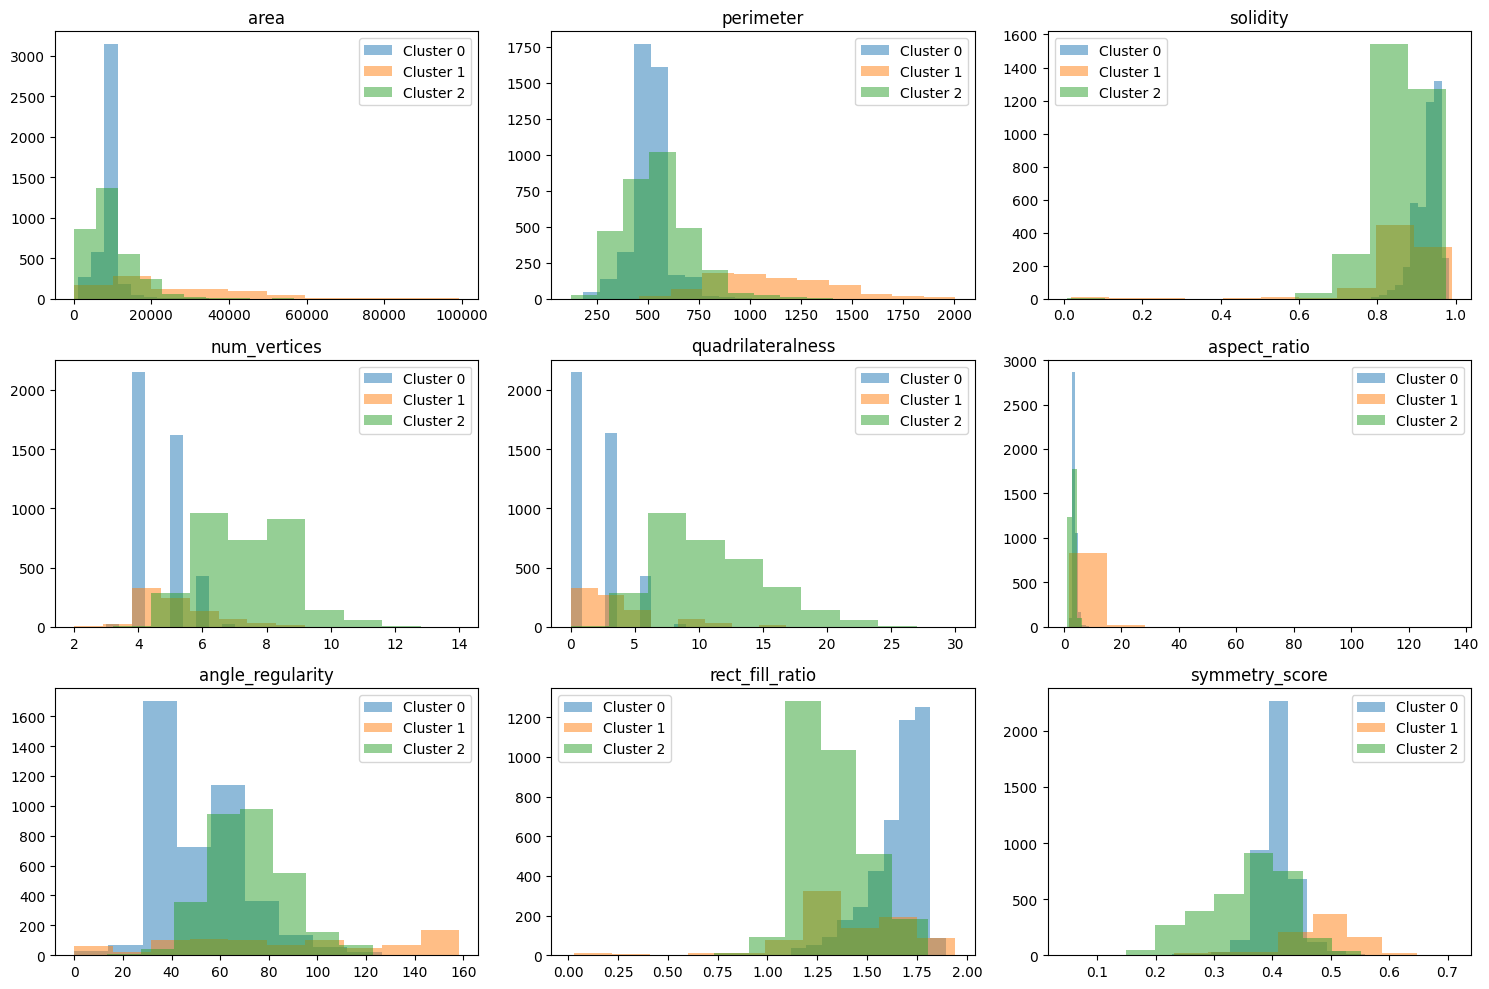

In [ ]:
import os
import json
import random
import copy
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

# --- Configuration ---
INPUT_JSON = "/content/drive/MyDrive/SMAI_Data/segmentation_results.json"
VIDEOS_DIR = "/content/RightVideo"
OUTPUT_RENDER_DIR = "/content/quad_improved_cluster_renders"
OUTPUT_CLUSTERED_JSON = "/content/drive/MyDrive/SMAI_Data/clustered_segmentation_quad_improved.json"

# Drawing settings
POLYGON_THICKNESS = 2
IS_POLYGON_CLOSED = True
CLUSTER_COLORS = [
    (255, 0, 0),    # Blue for Cluster 0 (High-quality tables)
    (0, 255, 0),    # Green for Cluster 1 (Partial/distorted tables)
    (0, 0, 255),    # Red for Cluster 2 (Non-tables/noise)
]

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# --- Helper Functions ---
def load_data(json_path):
    """Loads data from a JSON file."""
    print(f"Loading data from: {json_path}")
    if not os.path.exists(json_path):
        print(f"Error: Input file not found at {json_path}")
        return None
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries.")
        return data
    except Exception as e:
        print(f"An unexpected error occurred while loading {json_path}: {e}")
        return None

def save_data(data, json_path):
    """Saves data to a JSON file."""
    print(f"Saving {len(data)} entries to: {json_path}")
    try:
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        with open(json_path, 'w') as f:
            json.dump(data, f, indent=2)
        print("Data saved successfully.")
    except Exception as e:
        print(f"An error occurred while saving data to {json_path}: {e}")

def draw_polygon_with_label(frame, polygon_points, color, thickness, is_closed, label_text):
    """Draws a polygon and a text label on a given frame."""
    if not polygon_points or len(polygon_points) < 3:
        return frame
    try:
        pts = np.array(polygon_points, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(frame, [pts], isClosed=is_closed, color=color, thickness=thickness)
    except Exception as e:
        print(f"Error drawing polygon: {e}")
    try:
        min_x = min(p[0] for p in polygon_points)
        min_y = min(p[1] for p in polygon_points)
        text_x = int(min_x) + 5
        text_y = int(min_y) + 20
        h, w = frame.shape[:2]
        text_y = max(20, min(text_y, h - 10))
        text_x = max(5, min(text_x, w - 50))
        cv2.putText(frame, label_text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, thickness)
    except Exception as e:
        print(f"Error drawing label '{label_text}': {e}")
    return frame

# --- Quadrilateral-Focused Feature Extraction ---
def calculate_quadrilateral_features(polygon_points):
    """
    Calculates features with focus on quadrilateral properties.

    Args:
        polygon_points (list): List of [x, y] coordinates

    Returns:
        dict: Dictionary with enhanced features or None if invalid
    """
    if not polygon_points or len(polygon_points) < 4:  # Need at least 4 points
        return None

    try:
        # Convert to numpy array
        points_array = np.array(polygon_points, dtype=np.float32)
        contour = points_array.reshape((-1, 1, 2)).astype(np.int32)

        # 1. Basic shape metrics
        area = cv2.contourArea(contour)
        if area <= 10:  # Filter tiny shapes
            return None

        perimeter = cv2.arcLength(contour, closed=True)
        if perimeter <= 10:  # Filter degenerate shapes
            return None

        # 2. Convex Hull analysis
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        if hull_area <= 10:
            return None

        # Solidity: ratio of contour area to hull area (1.0 = fully convex)
        solidity = area / hull_area

        # 3. Approximated polygon analysis (key for quadrilateral detection)
        epsilon = 0.02 * perimeter  # Approximation precision parameter
        approx_poly = cv2.approxPolyDP(contour, epsilon, True)
        num_vertices = len(approx_poly)

        # 4. Calculate quadrilateralness - how close is it to having 4 corners?
        # Lower value = closer to being a quadrilateral
        quadrilateralness = abs(num_vertices - 4)

        # 5. Calculate aspect ratio using minimum area rectangle
        rect = cv2.minAreaRect(contour)
        width, height = rect[1]
        aspect_ratio = max(width, height) / (min(width, height) + 1e-5)  # Avoid division by zero

        # 6. Angle analysis of the polygon's sides
        # Get a measure of how close the angles are to 90 degrees (for rectangular tables)
        angle_regularity = 0.0
        if num_vertices >= 4:
            angles = []
            points = approx_poly.reshape(-1, 2)
            for i in range(len(points)):
                p1 = points[i]
                p2 = points[(i + 1) % len(points)]
                p3 = points[(i + 2) % len(points)]

                # Calculate vectors
                v1 = p1 - p2
                v2 = p3 - p2

                # Calculate angle between vectors (in degrees)
                dot = np.dot(v1, v2)
                norm = np.linalg.norm(v1) * np.linalg.norm(v2)
                if norm > 1e-5:  # Avoid division by zero
                    angle = np.arccos(max(-1.0, min(1.0, dot / norm))) * 180 / np.pi
                    angles.append(angle)

            if angles:
                # For rectangles, angles should be close to 90° or 270°
                angle_diffs = [min(abs(angle - 90), abs(angle - 270)) for angle in angles]
                angle_regularity = np.mean(angle_diffs)  # Lower = more rectangular

        # 7. Calculate the minimum area rectangle fill ratio
        # Higher values mean the polygon fills its bounding rectangle well (like a table should)
        min_rect_area = width * height
        rect_fill_ratio = area / (min_rect_area + 1e-5)

        # 8. Calculate approximate symmetry (tables are usually symmetric)
        # Get the centroid of the polygon
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])

            # Calculate distances from centroid to each point
            centroid = np.array([cx, cy])
            points_flat = points_array.reshape(-1, 2)
            dists = np.sqrt(np.sum((points_flat - centroid)**2, axis=1))

            # Symmetry measure: standard deviation of distances / mean distance
            # Lower values indicate more symmetry
            symmetry_score = np.std(dists) / (np.mean(dists) + 1e-5)
        else:
            symmetry_score = 1.0  # Default for degenerate cases

        # Return features as dictionary
        features = {
            "area": float(area),
            "perimeter": float(perimeter),
            "solidity": float(solidity),
            "num_vertices": int(num_vertices),
            "quadrilateralness": float(quadrilateralness),  # Key feature: 0 means exactly 4 vertices
            "aspect_ratio": float(aspect_ratio),
            "angle_regularity": float(angle_regularity),  # Lower means more rectangular angles
            "rect_fill_ratio": float(rect_fill_ratio),  # Higher means more rectangular filling
            "symmetry_score": float(symmetry_score),  # Lower means more symmetric
        }

        # Final check for NaN/Inf values
        if any(not np.isfinite(v) for v in features.values()):
            return None

        return features

    except Exception as e:
        # Handle any unexpected errors
        print(f"Error calculating quadrilateral features: {e}")
        return None

# --- Feature Visualization Function ---
def visualize_feature_distribution(feature_matrix, cluster_labels, feature_names, output_dir):
    """Visualize the distribution of features by cluster."""
    os.makedirs(output_dir, exist_ok=True)

    # Create a figure for feature histograms by cluster
    plt.figure(figsize=(15, 10))
    for i, feature_name in enumerate(feature_names):
        plt.subplot(3, 3, i+1)
        for cluster_id in range(max(cluster_labels) + 1):
            cluster_data = feature_matrix[cluster_labels == cluster_id, i]
            plt.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster_id}')
        plt.title(feature_name)
        plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "feature_histograms.png"))

    # Create pairwise scatter plots for the most important features
    key_features = ['quadrilateralness', 'rect_fill_ratio', 'angle_regularity', 'aspect_ratio']
    key_indices = [feature_names.index(f) for f in key_features if f in feature_names]

    if len(key_indices) >= 2:
        for i in range(len(key_indices)):
            for j in range(i+1, len(key_indices)):
                plt.figure(figsize=(8, 6))
                idx1, idx2 = key_indices[i], key_indices[j]
                for cluster_id in range(max(cluster_labels) + 1):
                    mask = cluster_labels == cluster_id
                    plt.scatter(
                        feature_matrix[mask, idx1],
                        feature_matrix[mask, idx2],
                        alpha=0.7,
                        label=f'Cluster {cluster_id}'
                    )
                plt.xlabel(feature_names[idx1])
                plt.ylabel(feature_names[idx2])
                plt.title(f'{feature_names[idx1]} vs {feature_names[idx2]}')
                plt.legend()
                plt.savefig(os.path.join(output_dir, f'scatter_{feature_names[idx1]}_{feature_names[idx2]}.png'))
                plt.close()

    # Also create a correlation matrix heatmap
    plt.figure(figsize=(10, 8))
    corr_matrix = np.corrcoef(feature_matrix.T)
    plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.title('Feature Correlation Matrix')
    plt.savefig(os.path.join(output_dir, "feature_correlation.png"))
    plt.close()

# --- Main Execution ---
def main():
    """Main function for improved table tennis surface detection."""
    print("--- Starting Table Tennis Surface Detection ---")

    # 1. Load Data
    segmentation_data = load_data(INPUT_JSON)
    if not segmentation_data:
        print("Exiting due to issues loading input data.")
        return

    # 2. Extract Quadrilateral-Focused Features
    print("Extracting quadrilateral-focused features...")
    feature_list = []
    valid_data_indices = []

    for i, item in enumerate(tqdm(segmentation_data, desc="Feature Extraction")):
        polygon = item.get("segmentation", {}).get("mask_polygon")
        if polygon:
            # Extract features with focus on quadrilateral properties
            features = calculate_quadrilateral_features(polygon)
            if features:
                # Create feature vector, with emphasis on quadrilateral properties
                feature_vector = [
                    features["area"],
                    features["perimeter"],
                    features["solidity"],
                    features["num_vertices"],
                    features["quadrilateralness"] * 3,  # Weighted 3x for importance
                    features["aspect_ratio"],
                    features["angle_regularity"] * 2,   # Weighted 2x for importance
                    features["rect_fill_ratio"] * 2,    # Weighted 2x for importance
                    features["symmetry_score"]
                ]
                feature_list.append(feature_vector)
                valid_data_indices.append(i)

    if not feature_list:
        print("Error: No valid features could be extracted. Exiting.")
        return

    feature_matrix = np.array(feature_list)
    print(f"Extracted features for {len(feature_list)} polygons.")

    # 3. Scale Features
    print("Scaling features...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)

    # 4. Apply initial filtering (optional)
    # Pre-filter obvious non-table polygons based on quadrilateral metrics
    # This is a simple threshold-based pre-filtering step
    filtered_indices = []
    quad_scores = []

    for i, features in enumerate(scaled_features):
        # Create a "table likelihood score" from key features
        # Assuming features order as defined in the feature vector
        quad_feature_index = 4  # quadrilateralness index
        angle_feature_index = 6  # angle_regularity index
        rect_fill_index = 7      # rect_fill_ratio index

        # Lower quadrilateralness is better (closer to 4 vertices)
        # Lower angle_regularity is better (closer to 90 degree angles)
        # Higher rect_fill_ratio is better (fills rectangle better)
        table_score = -features[quad_feature_index] - features[angle_feature_index] + features[rect_fill_index]
        quad_scores.append(table_score)

    quad_scores = np.array(quad_scores)
    filtered_indices = range(len(scaled_features))  # Default: use all

    # 5. Perform Clustering
    print("Performing clustering with K-Means (K=3)...")
    # Use KMeans with 3 clusters: good tables, partial tables, non-tables
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

    # Reorder features to prioritize quadrilateral properties for clustering
    # This creates a new matrix where quadrilateral-specific features are first
    # Priority features get stronger influence on the clustering
    priority_indices = [4, 7, 6, 3]  # quadrilateralness, rect_fill, angle_regularity, num_vertices
    secondary_indices = [i for i in range(scaled_features.shape[1]) if i not in priority_indices]
    reordered_indices = priority_indices + secondary_indices

    reordered_features = scaled_features[:, reordered_indices]
    cluster_labels = kmeans.fit_predict(reordered_features)

    # 6. Analyze clusters to determine which is most likely to be table surfaces
    # Calculate mean quadrilateralness and rectangle fill ratio for each cluster
    print("Analyzing clusters...")
    cluster_stats = {}

    for cluster_id in range(3):
        cluster_mask = cluster_labels == cluster_id
        cluster_features = feature_matrix[cluster_mask]

        if len(cluster_features) > 0:
            # Calculate statistics for this cluster
            quad_scores_in_cluster = quad_scores[cluster_mask]
            mean_quad_score = np.mean(quad_scores_in_cluster)
            mean_quadrilateralness = np.mean(cluster_features[:, 4])  # Using original non-scaled values
            mean_rect_fill = np.mean(cluster_features[:, 7])

            cluster_stats[cluster_id] = {
                "count": np.sum(cluster_mask),
                "mean_quad_score": mean_quad_score,
                "mean_quadrilateralness": mean_quadrilateralness,
                "mean_rect_fill": mean_rect_fill
            }

            print(f"Cluster {cluster_id}: {np.sum(cluster_mask)} polygons")
            print(f"  - Mean quadrilateralness: {mean_quadrilateralness:.2f} (lower is better)")
            print(f"  - Mean rectangle fill ratio: {mean_rect_fill:.2f} (higher is better)")
            print(f"  - Table likelihood score: {mean_quad_score:.2f} (higher is better)")

    # 7. Visualize feature distributions by cluster
    feature_names = [
        "area", "perimeter", "solidity", "num_vertices",
        "quadrilateralness", "aspect_ratio", "angle_regularity",
        "rect_fill_ratio", "symmetry_score"
    ]
    visualize_feature_distribution(feature_matrix, cluster_labels, feature_names, OUTPUT_RENDER_DIR)

    # 8. Reorder clusters by table-likeness for better interpretability
    # We'll define cluster 0 as the most table-like, 1 as partially table-like, and 2 as non-tables
    sorted_clusters = sorted(cluster_stats.keys(),
                            key=lambda k: (-cluster_stats[k]["mean_quad_score"]))

    remapping = {old_id: new_id for new_id, old_id in enumerate(sorted_clusters)}
    remapped_labels = np.array([remapping[label] for label in cluster_labels])

    print("\nCluster remapping for better interpretability:")
    print(f"Original clusters -> New clusters: {remapping}")
    print(f"Cluster 0: Most table-like polygons")
    print(f"Cluster 1: Partially table-like polygons")
    print(f"Cluster 2: Non-table polygons/noise")

    # 9. Add cluster labels to original data
    clustered_data = copy.deepcopy(segmentation_data)
    assigned_count = 0

    for i, original_index in enumerate(valid_data_indices):
        if "segmentation" not in clustered_data[original_index]:
            clustered_data[original_index]["segmentation"] = {}

        # Use a distinctive key
        clustered_data[original_index]["segmentation"]["quad_cluster_label"] = int(remapped_labels[i])
        assigned_count += 1

    print(f"Assigned improved cluster labels to {assigned_count} entries.")
    save_data(clustered_data, OUTPUT_CLUSTERED_JSON)

    # 10. Prepare for visualization
    items_by_cluster = {cluster_id: [] for cluster_id in range(3)}  # Always 3 clusters
    for i, original_index in enumerate(valid_data_indices):
        cluster_id = int(remapped_labels[i])
        items_by_cluster[cluster_id].append(segmentation_data[original_index])

    os.makedirs(OUTPUT_RENDER_DIR, exist_ok=True)

    # 11. Sample and render from each cluster
    print("Sampling and rendering frames for each cluster...")
    samples_per_cluster = 5

    for cluster_id in range(3):
        print(f"\nProcessing Cluster {cluster_id}...")
        cluster_items = items_by_cluster[cluster_id]
        num_items = len(cluster_items)
        print(f"Found {num_items} items in Cluster {cluster_id}.")

        if num_items == 0:
            continue

        num_to_sample = min(num_items, samples_per_cluster)
        sampled_items = random.sample(cluster_items, num_to_sample)

        for item in tqdm(sampled_items, desc=f"Rendering Cluster {cluster_id}"):
            video_name = item.get("video_name")
            frame_idx = item.get("frame_idx")
            frame_key = item.get("frame_key", f"frame_{frame_idx}")
            polygon = item.get("segmentation", {}).get("mask_polygon")

            if not all([video_name, frame_idx is not None, polygon]):
                continue

            video_path = os.path.join(VIDEOS_DIR, video_name)
            if not os.path.exists(video_path):
                print(f"Warning: Video file not found '{video_path}'. Skipping.")
                continue

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                continue

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                cap.release()
                continue

            cluster_color = CLUSTER_COLORS[cluster_id]

            # Add descriptive label based on cluster
            if cluster_id == 0:
                label = "Table (High Quality)"
            elif cluster_id == 1:
                label = "Table (Partial/Distorted)"
            else:
                label = "Non-Table/Noise"

            frame_with_render = draw_polygon_with_label(
                frame, polygon, cluster_color, POLYGON_THICKNESS, IS_POLYGON_CLOSED, label
            )

            output_filename = f"cluster_{cluster_id}__{video_name}__{frame_key}_quad.png"
            output_filepath = os.path.join(OUTPUT_RENDER_DIR, output_filename)

            try:
                cv2.imwrite(output_filepath, frame_with_render)
            except Exception as e:
                print(f"Error saving rendered frame: {e}")

            cap.release()

    print("\n--- Table Tennis Surface Detection Complete ---")
    print(f"Results saved to: {OUTPUT_CLUSTERED_JSON}")
    print(f"Visualizations saved to: {OUTPUT_RENDER_DIR}")

if __name__ == "__main__":
    main()

In [ ]:
# prompt: /content/quad_improved_cluster_renders zip it

!zip -r /content/quad_improved_cluster_renders.zip /content/quad_improved_cluster_renders


  adding: content/quad_improved_cluster_renders/ (stored 0%)
  adding: content/quad_improved_cluster_renders/scatter_rect_fill_ratio_aspect_ratio.png (deflated 12%)
  adding: content/quad_improved_cluster_renders/scatter_quadrilateralness_rect_fill_ratio.png (deflated 8%)
  adding: content/quad_improved_cluster_renders/cluster_2__8.mp4__frame_29576_quad.png (deflated 6%)
  adding: content/quad_improved_cluster_renders/scatter_quadrilateralness_aspect_ratio.png (deflated 15%)
  adding: content/quad_improved_cluster_renders/cluster_1__8.mp4__frame_24268_quad.png (deflated 4%)
  adding: content/quad_improved_cluster_renders/cluster_0__17.mp4__frame_24341_quad.png (deflated 5%)
  adding: content/quad_improved_cluster_renders/cluster_2__10.mp4__frame_10528_quad.png (deflated 3%)
  adding: content/quad_improved_cluster_renders/cluster_2__13.mp4__frame_39856_quad.png (deflated 4%)
  adding: content/quad_improved_cluster_renders/cluster_1__11.mp4__frame_3414_quad.png (deflated 5%)
  adding: co

--- Starting Table Tennis Surface Detection ---
Loading data from: /content/drive/MyDrive/SMAI_Data/segmentation_results.json
Successfully loaded 8216 entries.
Extracting quadrilateral-focused features...


Feature Extraction: 100%|██████████| 8216/8216 [00:05<00:00, 1579.04it/s]


Extracted features for 8216 polygons.
Scaling features...
Performing clustering with K-Means (K=3)...
Analyzing clusters...
Cluster 0: 4243 polygons
  - Mean quadrilateralness: 1.82 (lower is better)
  - Mean rectangle fill ratio: 1.65 (higher is better)
  - Table likelihood score: 1.72 (higher is better)
Cluster 1: 858 polygons
  - Mean quadrilateralness: 3.44 (lower is better)
  - Mean rectangle fill ratio: 1.39 (higher is better)
  - Table likelihood score: -1.13 (higher is better)
Cluster 2: 3115 polygons
  - Mean quadrilateralness: 9.38 (lower is better)
  - Mean rectangle fill ratio: 1.32 (higher is better)
  - Table likelihood score: -2.03 (higher is better)

Cluster remapping for better interpretability:
Original clusters -> New clusters: {0: 0, 1: 1, 2: 2}
Cluster 0: Most table-like polygons (4243 items)
Cluster 1: Partially table-like polygons (858 items)
Cluster 2: Non-table polygons/noise (3115 items)
Assigned improved cluster labels to 8216 entries.
Saving 8216 entries to:

Rendering High-Quality Tables: 100%|██████████| 4243/4243 [07:29<00:00,  9.43it/s]


Successfully rendered 4243 high-quality table surfaces.
Saved metadata to: /content/high_quality_table_renders/high_quality_tables_metadata.json

--- Table Tennis Surface Detection Complete ---
Results saved to: /content/drive/MyDrive/SMAI_Data/clustered_segmentation_quad_improved.json
High-quality table surface renders (4243) saved to: /content/high_quality_table_renders
Last updated: 2025-04-16 11:56:30


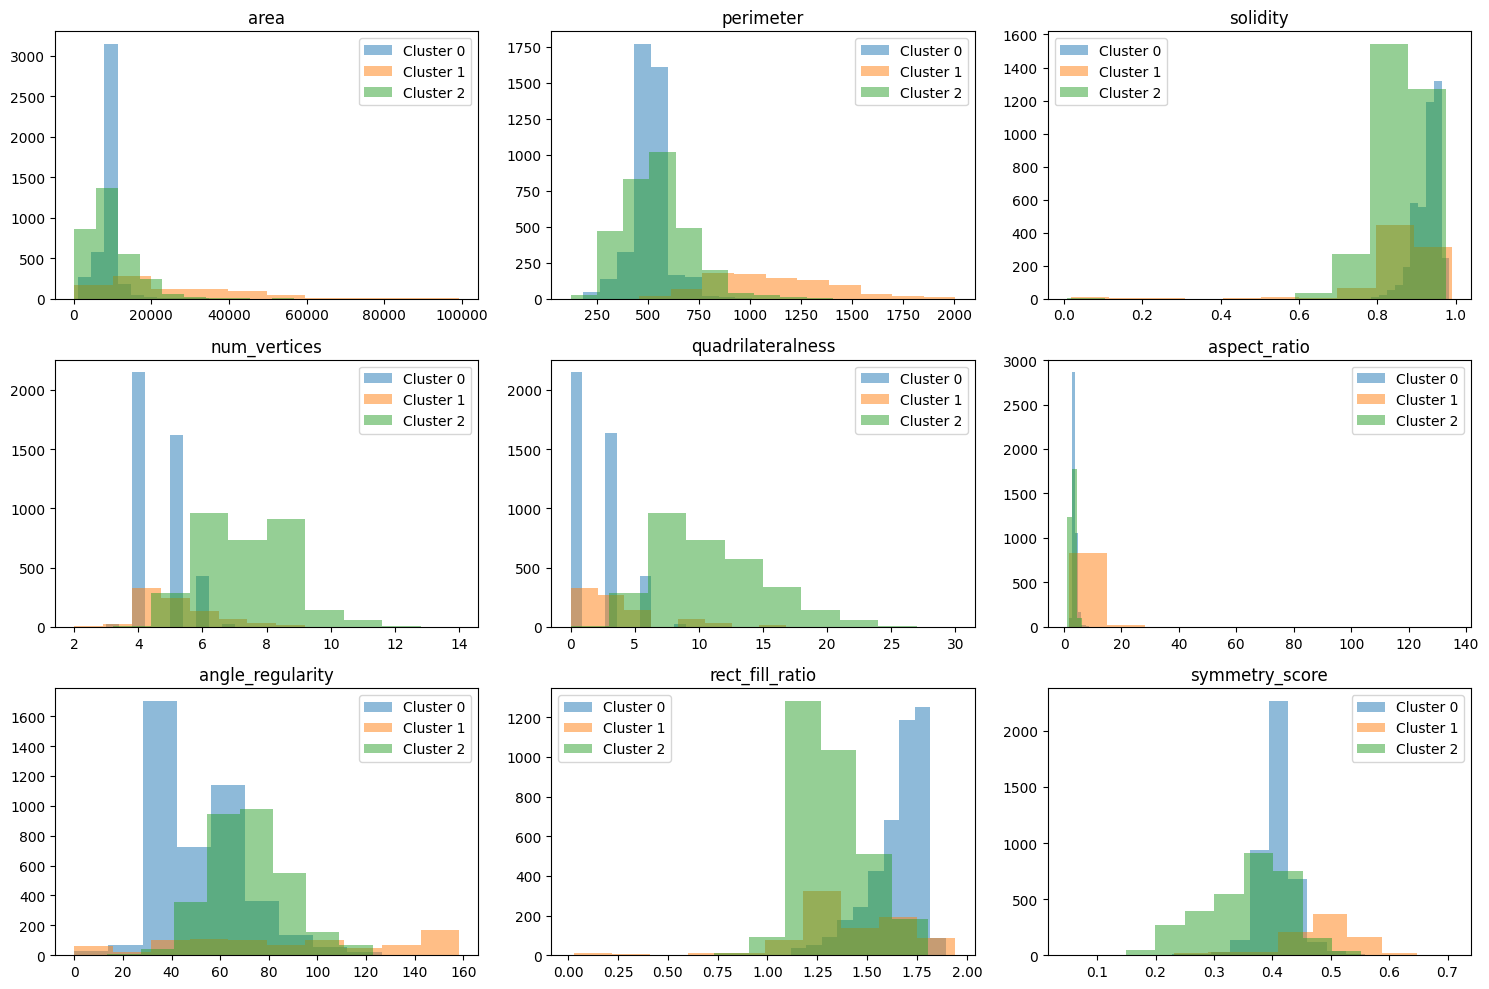

In [ ]:
import os
import json
import random
import copy
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import datetime

# --- Configuration ---
INPUT_JSON = "/content/drive/MyDrive/SMAI_Data/segmentation_results.json"
VIDEOS_DIR = "/content/RightVideo"
OUTPUT_RENDER_DIR = "/content/high_quality_table_renders"  # Updated output directory
OUTPUT_CLUSTERED_JSON = "/content/drive/MyDrive/SMAI_Data/clustered_segmentation_quad_improved.json"

# New configuration for high-quality renders
HIGH_QUALITY_CLUSTER = 0  # The cluster ID representing high-quality table surfaces

# Drawing settings
POLYGON_THICKNESS = 2
IS_POLYGON_CLOSED = True
HIGH_QUALITY_COLOR = (0, 255, 0)  # Green for high-quality tables

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# --- Helper Functions ---
def load_data(json_path):
    """Loads data from a JSON file."""
    print(f"Loading data from: {json_path}")
    if not os.path.exists(json_path):
        print(f"Error: Input file not found at {json_path}")
        return None
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries.")
        return data
    except Exception as e:
        print(f"An unexpected error occurred while loading {json_path}: {e}")
        return None

def save_data(data, json_path):
    """Saves data to a JSON file."""
    print(f"Saving {len(data)} entries to: {json_path}")
    try:
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        with open(json_path, 'w') as f:
            json.dump(data, f, indent=2)
        print("Data saved successfully.")
    except Exception as e:
        print(f"An error occurred while saving data to {json_path}: {e}")

def draw_polygon_with_label(frame, polygon_points, color, thickness, is_closed, label_text):
    """Draws a polygon and a text label on a given frame."""
    if not polygon_points or len(polygon_points) < 3:
        return frame
    try:
        pts = np.array(polygon_points, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(frame, [pts], isClosed=is_closed, color=color, thickness=thickness)
    except Exception as e:
        print(f"Error drawing polygon: {e}")
    try:
        min_x = min(p[0] for p in polygon_points)
        min_y = min(p[1] for p in polygon_points)
        text_x = int(min_x) + 5
        text_y = int(min_y) + 20
        h, w = frame.shape[:2]
        text_y = max(20, min(text_y, h - 10))
        text_x = max(5, min(text_x, w - 50))
        cv2.putText(frame, label_text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, thickness)
    except Exception as e:
        print(f"Error drawing label '{label_text}': {e}")
    return frame

# --- Quadrilateral-Focused Feature Extraction ---
def calculate_quadrilateral_features(polygon_points):
    """
    Calculates features with focus on quadrilateral properties.

    Args:
        polygon_points (list): List of [x, y] coordinates

    Returns:
        dict: Dictionary with enhanced features or None if invalid
    """
    if not polygon_points or len(polygon_points) < 4:  # Need at least 4 points
        return None

    try:
        # Convert to numpy array
        points_array = np.array(polygon_points, dtype=np.float32)
        contour = points_array.reshape((-1, 1, 2)).astype(np.int32)

        # 1. Basic shape metrics
        area = cv2.contourArea(contour)
        if area <= 10:  # Filter tiny shapes
            return None

        perimeter = cv2.arcLength(contour, closed=True)
        if perimeter <= 10:  # Filter degenerate shapes
            return None

        # 2. Convex Hull analysis
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        if hull_area <= 10:
            return None

        # Solidity: ratio of contour area to hull area (1.0 = fully convex)
        solidity = area / hull_area

        # 3. Approximated polygon analysis (key for quadrilateral detection)
        epsilon = 0.02 * perimeter  # Approximation precision parameter
        approx_poly = cv2.approxPolyDP(contour, epsilon, True)
        num_vertices = len(approx_poly)

        # 4. Calculate quadrilateralness - how close is it to having 4 corners?
        # Lower value = closer to being a quadrilateral
        quadrilateralness = abs(num_vertices - 4)

        # 5. Calculate aspect ratio using minimum area rectangle
        rect = cv2.minAreaRect(contour)
        width, height = rect[1]
        aspect_ratio = max(width, height) / (min(width, height) + 1e-5)  # Avoid division by zero

        # 6. Angle analysis of the polygon's sides
        # Get a measure of how close the angles are to 90 degrees (for rectangular tables)
        angle_regularity = 0.0
        if num_vertices >= 4:
            angles = []
            points = approx_poly.reshape(-1, 2)
            for i in range(len(points)):
                p1 = points[i]
                p2 = points[(i + 1) % len(points)]
                p3 = points[(i + 2) % len(points)]

                # Calculate vectors
                v1 = p1 - p2
                v2 = p3 - p2

                # Calculate angle between vectors (in degrees)
                dot = np.dot(v1, v2)
                norm = np.linalg.norm(v1) * np.linalg.norm(v2)
                if norm > 1e-5:  # Avoid division by zero
                    angle = np.arccos(max(-1.0, min(1.0, dot / norm))) * 180 / np.pi
                    angles.append(angle)

            if angles:
                # For rectangles, angles should be close to 90° or 270°
                angle_diffs = [min(abs(angle - 90), abs(angle - 270)) for angle in angles]
                angle_regularity = np.mean(angle_diffs)  # Lower = more rectangular

        # 7. Calculate the minimum area rectangle fill ratio
        # Higher values mean the polygon fills its bounding rectangle well (like a table should)
        min_rect_area = width * height
        rect_fill_ratio = area / (min_rect_area + 1e-5)

        # 8. Calculate approximate symmetry (tables are usually symmetric)
        # Get the centroid of the polygon
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])

            # Calculate distances from centroid to each point
            centroid = np.array([cx, cy])
            points_flat = points_array.reshape(-1, 2)
            dists = np.sqrt(np.sum((points_flat - centroid)**2, axis=1))

            # Symmetry measure: standard deviation of distances / mean distance
            # Lower values indicate more symmetry
            symmetry_score = np.std(dists) / (np.mean(dists) + 1e-5)
        else:
            symmetry_score = 1.0  # Default for degenerate cases

        # Return features as dictionary
        features = {
            "area": float(area),
            "perimeter": float(perimeter),
            "solidity": float(solidity),
            "num_vertices": int(num_vertices),
            "quadrilateralness": float(quadrilateralness),  # Key feature: 0 means exactly 4 vertices
            "aspect_ratio": float(aspect_ratio),
            "angle_regularity": float(angle_regularity),  # Lower means more rectangular angles
            "rect_fill_ratio": float(rect_fill_ratio),  # Higher means more rectangular filling
            "symmetry_score": float(symmetry_score),  # Lower means more symmetric
        }

        # Final check for NaN/Inf values
        if any(not np.isfinite(v) for v in features.values()):
            return None

        return features

    except Exception as e:
        # Handle any unexpected errors
        print(f"Error calculating quadrilateral features: {e}")
        return None

# --- Feature Visualization Function ---
def visualize_feature_distribution(feature_matrix, cluster_labels, feature_names, output_dir):
    """Visualize the distribution of features by cluster."""
    os.makedirs(output_dir, exist_ok=True)

    # Create a figure for feature histograms by cluster
    plt.figure(figsize=(15, 10))
    for i, feature_name in enumerate(feature_names):
        plt.subplot(3, 3, i+1)
        for cluster_id in range(max(cluster_labels) + 1):
            cluster_data = feature_matrix[cluster_labels == cluster_id, i]
            plt.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster_id}')
        plt.title(feature_name)
        plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "feature_histograms.png"))

    # Create pairwise scatter plots for the most important features
    key_features = ['quadrilateralness', 'rect_fill_ratio', 'angle_regularity', 'aspect_ratio']
    key_indices = [feature_names.index(f) for f in key_features if f in feature_names]

    if len(key_indices) >= 2:
        for i in range(len(key_indices)):
            for j in range(i+1, len(key_indices)):
                plt.figure(figsize=(8, 6))
                idx1, idx2 = key_indices[i], key_indices[j]
                for cluster_id in range(max(cluster_labels) + 1):
                    mask = cluster_labels == cluster_id
                    plt.scatter(
                        feature_matrix[mask, idx1],
                        feature_matrix[mask, idx2],
                        alpha=0.7,
                        label=f'Cluster {cluster_id}'
                    )
                plt.xlabel(feature_names[idx1])
                plt.ylabel(feature_names[idx2])
                plt.title(f'{feature_names[idx1]} vs {feature_names[idx2]}')
                plt.legend()
                plt.savefig(os.path.join(output_dir, f'scatter_{feature_names[idx1]}_{feature_names[idx2]}.png'))
                plt.close()

    # Also create a correlation matrix heatmap
    plt.figure(figsize=(10, 8))
    corr_matrix = np.corrcoef(feature_matrix.T)
    plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.title('Feature Correlation Matrix')
    plt.savefig(os.path.join(output_dir, "feature_correlation.png"))
    plt.close()

# --- Function to render high-quality table surfaces ---
def render_high_quality_tables(data, cluster_labels, valid_indices, videos_dir, output_dir):
    """
    Renders and saves only high-quality table surfaces.

    Args:
        data (list): Original segmentation data
        cluster_labels (ndarray): Cluster labels after remapping
        valid_indices (list): Indices of valid entries in original data
        videos_dir (str): Directory containing videos
        output_dir (str): Directory to save renders
    """
    os.makedirs(output_dir, exist_ok=True)
    print(f"Rendering high-quality table surfaces to: {output_dir}")

    # Get current timestamp for output filename
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Create a list of high-quality table entries
    high_quality_items = []
    for i, original_index in enumerate(valid_indices):
        if cluster_labels[i] == HIGH_QUALITY_CLUSTER:
            high_quality_items.append(data[original_index])

    print(f"Found {len(high_quality_items)} high-quality table surfaces.")

    # Save all high-quality items
    successful_renders = 0
    for i, item in enumerate(tqdm(high_quality_items, desc="Rendering High-Quality Tables")):
        video_name = item.get("video_name")
        frame_idx = item.get("frame_idx")
        frame_key = item.get("frame_key", f"frame_{frame_idx}")
        polygon = item.get("segmentation", {}).get("mask_polygon")

        if not all([video_name, frame_idx is not None, polygon]):
            continue

        video_path = os.path.join(videos_dir, video_name)
        if not os.path.exists(video_path):
            print(f"Warning: Video file not found '{video_path}'. Skipping.")
            continue

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            continue

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if not ret:
            cap.release()
            continue

        # Draw the polygon with a label
        frame_with_render = draw_polygon_with_label(
            frame, polygon, HIGH_QUALITY_COLOR, POLYGON_THICKNESS,
            IS_POLYGON_CLOSED, "High-Quality Table Surface"
        )

        # Save with video name, frame number and polygon index
        output_filename = f"table_surface_{video_name}__frame{frame_idx:05d}_{i:03d}.png"
        output_filepath = os.path.join(output_dir, output_filename)

        try:
            cv2.imwrite(output_filepath, frame_with_render)
            successful_renders += 1
        except Exception as e:
            print(f"Error saving rendered frame: {e}")

        cap.release()

    # Save metadata JSON with list of all high-quality table frames
    high_quality_metadata = {
        "timestamp": timestamp,
        "total_detected": len(high_quality_items),
        "successfully_rendered": successful_renders,
        "table_surfaces": [
            {
                "video_name": item.get("video_name"),
                "frame_idx": item.get("frame_idx"),
                "frame_key": item.get("frame_key", f"frame_{item.get('frame_idx')}")
            } for item in high_quality_items
        ]
    }

    metadata_path = os.path.join(output_dir, "high_quality_tables_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(high_quality_metadata, f, indent=2)

    print(f"Successfully rendered {successful_renders} high-quality table surfaces.")
    print(f"Saved metadata to: {metadata_path}")

    return successful_renders

# --- Main Execution ---
def main():
    """Main function for improved table tennis surface detection, rendering only high-quality tables."""
    print("--- Starting Table Tennis Surface Detection ---")

    # 1. Load Data
    segmentation_data = load_data(INPUT_JSON)
    if not segmentation_data:
        print("Exiting due to issues loading input data.")
        return

    # 2. Extract Quadrilateral-Focused Features
    print("Extracting quadrilateral-focused features...")
    feature_list = []
    valid_data_indices = []

    for i, item in enumerate(tqdm(segmentation_data, desc="Feature Extraction")):
        polygon = item.get("segmentation", {}).get("mask_polygon")
        if polygon:
            # Extract features with focus on quadrilateral properties
            features = calculate_quadrilateral_features(polygon)
            if features:
                # Create feature vector, with emphasis on quadrilateral properties
                feature_vector = [
                    features["area"],
                    features["perimeter"],
                    features["solidity"],
                    features["num_vertices"],
                    features["quadrilateralness"] * 3,  # Weighted 3x for importance
                    features["aspect_ratio"],
                    features["angle_regularity"] * 2,   # Weighted 2x for importance
                    features["rect_fill_ratio"] * 2,    # Weighted 2x for importance
                    features["symmetry_score"]
                ]
                feature_list.append(feature_vector)
                valid_data_indices.append(i)

    if not feature_list:
        print("Error: No valid features could be extracted. Exiting.")
        return

    feature_matrix = np.array(feature_list)
    print(f"Extracted features for {len(feature_list)} polygons.")

    # 3. Scale Features
    print("Scaling features...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)

    # 4. Apply initial filtering (optional)
    # Pre-filter obvious non-table polygons based on quadrilateral metrics
    # This is a simple threshold-based pre-filtering step
    filtered_indices = []
    quad_scores = []

    for i, features in enumerate(scaled_features):
        # Create a "table likelihood score" from key features
        # Assuming features order as defined in the feature vector
        quad_feature_index = 4  # quadrilateralness index
        angle_feature_index = 6  # angle_regularity index
        rect_fill_index = 7      # rect_fill_ratio index

        # Lower quadrilateralness is better (closer to 4 vertices)
        # Lower angle_regularity is better (closer to 90 degree angles)
        # Higher rect_fill_ratio is better (fills rectangle better)
        table_score = -features[quad_feature_index] - features[angle_feature_index] + features[rect_fill_index]
        quad_scores.append(table_score)

    quad_scores = np.array(quad_scores)
    filtered_indices = range(len(scaled_features))  # Default: use all

    # 5. Perform Clustering
    print("Performing clustering with K-Means (K=3)...")
    # Use KMeans with 3 clusters: good tables, partial tables, non-tables
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

    # Reorder features to prioritize quadrilateral properties for clustering
    # This creates a new matrix where quadrilateral-specific features are first
    # Priority features get stronger influence on the clustering
    priority_indices = [4, 7, 6, 3]  # quadrilateralness, rect_fill, angle_regularity, num_vertices
    secondary_indices = [i for i in range(scaled_features.shape[1]) if i not in priority_indices]
    reordered_indices = priority_indices + secondary_indices

    reordered_features = scaled_features[:, reordered_indices]
    cluster_labels = kmeans.fit_predict(reordered_features)

    # 6. Analyze clusters to determine which is most likely to be table surfaces
    # Calculate mean quadrilateralness and rectangle fill ratio for each cluster
    print("Analyzing clusters...")
    cluster_stats = {}

    for cluster_id in range(3):
        cluster_mask = cluster_labels == cluster_id
        cluster_features = feature_matrix[cluster_mask]

        if len(cluster_features) > 0:
            # Calculate statistics for this cluster
            quad_scores_in_cluster = quad_scores[cluster_mask]
            mean_quad_score = np.mean(quad_scores_in_cluster)
            mean_quadrilateralness = np.mean(cluster_features[:, 4])  # Using original non-scaled values
            mean_rect_fill = np.mean(cluster_features[:, 7])

            cluster_stats[cluster_id] = {
                "count": np.sum(cluster_mask),
                "mean_quad_score": mean_quad_score,
                "mean_quadrilateralness": mean_quadrilateralness,
                "mean_rect_fill": mean_rect_fill
            }

            print(f"Cluster {cluster_id}: {np.sum(cluster_mask)} polygons")
            print(f"  - Mean quadrilateralness: {mean_quadrilateralness:.2f} (lower is better)")
            print(f"  - Mean rectangle fill ratio: {mean_rect_fill:.2f} (higher is better)")
            print(f"  - Table likelihood score: {mean_quad_score:.2f} (higher is better)")

    # 7. Visualize feature distributions by cluster
    feature_names = [
        "area", "perimeter", "solidity", "num_vertices",
        "quadrilateralness", "aspect_ratio", "angle_regularity",
        "rect_fill_ratio", "symmetry_score"
    ]
    visualize_feature_distribution(feature_matrix, cluster_labels, feature_names, OUTPUT_RENDER_DIR)

    # 8. Reorder clusters by table-likeness for better interpretability
    # We'll define cluster 0 as the most table-like, 1 as partially table-like, and 2 as non-tables
    sorted_clusters = sorted(cluster_stats.keys(),
                            key=lambda k: (-cluster_stats[k]["mean_quad_score"]))

    remapping = {old_id: new_id for new_id, old_id in enumerate(sorted_clusters)}
    remapped_labels = np.array([remapping[label] for label in cluster_labels])

    print("\nCluster remapping for better interpretability:")
    print(f"Original clusters -> New clusters: {remapping}")
    print(f"Cluster 0: Most table-like polygons ({np.sum(remapped_labels == 0)} items)")
    print(f"Cluster 1: Partially table-like polygons ({np.sum(remapped_labels == 1)} items)")
    print(f"Cluster 2: Non-table polygons/noise ({np.sum(remapped_labels == 2)} items)")

    # 9. Add cluster labels to original data
    clustered_data = copy.deepcopy(segmentation_data)
    assigned_count = 0

    for i, original_index in enumerate(valid_data_indices):
        if "segmentation" not in clustered_data[original_index]:
            clustered_data[original_index]["segmentation"] = {}

        # Use a distinctive key
        clustered_data[original_index]["segmentation"]["quad_cluster_label"] = int(remapped_labels[i])
        assigned_count += 1

    print(f"Assigned improved cluster labels to {assigned_count} entries.")
    save_data(clustered_data, OUTPUT_CLUSTERED_JSON)

    # 10. Render only high-quality table surfaces
    num_rendered = render_high_quality_tables(
        segmentation_data, remapped_labels, valid_data_indices,
        VIDEOS_DIR, OUTPUT_RENDER_DIR
    )

    print("\n--- Table Tennis Surface Detection Complete ---")
    print(f"Results saved to: {OUTPUT_CLUSTERED_JSON}")
    print(f"High-quality table surface renders ({num_rendered}) saved to: {OUTPUT_RENDER_DIR}")
    print(f"Last updated: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

if __name__ == "__main__":
    main()

In [ ]:
# prompt: zip /content/high_quality_table_renders

!zip -r /content/high_quality_table_renders.zip /content/high_quality_table_renders


  adding: content/high_quality_table_renders/ (stored 0%)
  adding: content/high_quality_table_renders/table_surface_9.mp4__frame40077_2233.png (deflated 7%)
  adding: content/high_quality_table_renders/table_surface_8.mp4__frame09745_1597.png (deflated 5%)
  adding: content/high_quality_table_renders/table_surface_5.mp4__frame00126_736.png (deflated 6%)
  adding: content/high_quality_table_renders/table_surface_4.mp4__frame32422_2929.png (deflated 4%)
  adding: content/high_quality_table_renders/table_surface_7.mp4__frame13682_3246.png (deflated 6%)
  adding: content/high_quality_table_renders/table_surface_19.mp4__frame07561_161.png (deflated 6%)
  adding: content/high_quality_table_renders/table_surface_0.mp4__frame08534_3612.png (deflated 7%)
  adding: content/high_quality_table_renders/table_surface_0.mp4__frame24287_3829.png (deflated 6%)
  adding: content/high_quality_table_renders/table_surface_3.mp4__frame40254_1389.png (deflated 6%)
  adding: content/high_quality_table_render

In [ ]:
# prompt: copy /content/high_quality_table_renders to /content/drive/MyDrive/SmaiResult command linux

!cp -r /content/high_quality_table_renders /content/drive/MyDrive/SmaiResult
